# DSW response to upper cell thickening

This notebook evaluates how the DSW formation and its shelf overflow plume responds to the thickening of the surface cell of the model. The thickness of the uppemost cell only was increased between runs here, from 1m thick to 5m thick. The comparisson is done using two models - MOM5 and MOM6

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1, sigma2
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [2]:
client = Client(n_workers = 48, memory_limit = '1350gb')

2025-05-05 08:56:26,285 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35609'.
2025-05-05 08:56:26,308 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:34805'.
2025-05-05 08:56:26,312 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37919'.
2025-05-05 08:56:26,315 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:42627'.
2025-05-05 08:56:26,344 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37341'.
2025-05-05 08:56:26,346 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37761'.
2025-05-05 08:56:26,347 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33095'.
2025-05-05 08:56:26,385 - distributed.scheduler - WARNING - Received heartbeat from unregistered 

# Set up

## 1. Defining surface water-mass transformation

The surface water-mass transformation framework described here follows [Newsom *et al* (2016)](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-15-0513.1) and [Abernathey *et al* (2016)](https://www.nature.com/articles/ngeo2749). Surface water-mass transformation may be defined as the volume flux into a given density class ($\sigma$) from lighter density classes ($\sigma'<\sigma$) due to surface buoyancy forcing. Integrated over a region of the ocean surface, this volume flux can be expressed as,

$$
\begin{equation}
\Omega(\sigma, t) = \frac{\partial}{\partial\sigma} \iint_{\sigma'<\sigma} \Big(\frac{\partial\sigma}{\partial\theta}\theta + \frac{\partial\sigma}{\partial S}S\Big) \, \mathrm{d}x \, \mathrm{d}y
\end{equation}
$$

where $t$ is time, and the terms in the integrand are the potential temperature ($\theta$) flux and salinity ($S$) flux components of the surface buoyancy flux. The linearity of this expression means we can extract the relative contributions of heat ($\Omega_\text{heat}$) and salinity ($\Omega_\text{fw}$) fluxes to surface water-mass transformation, highlighting driving mechanisms.


# Part 1 : Importing data

### 1.1 SWMT between runs

#### Importing MOM6

In [3]:
import glob
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_1dz=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [4]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01_5mtop/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_5dz=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [5]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01_5m_weakwinds/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_5dz_weakwinds=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


9 netcdf data files


2025-05-05 08:56:26,291 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-05-05 08:56:26,301 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 452, in retry_operation
    return await retry(
  File "/g/data/hh5/public/app

#### Separating shelf

In [6]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks variales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [7]:
SHeat_5dz_shelf, shelf_mask_MOM6 = shelf_mask_isobath(P01_5dz.binned_heat_transformation, 1000, '01', output_mask=True)
Ssalt_5dz_shelf = shelf_mask_isobath(P01_5dz.binned_salt_transformation, 1000, '01')


SHeat_5dz_shelf_weakwinds = shelf_mask_isobath(P01_5dz_weakwinds.binned_heat_transformation, 1000, '01')
Ssalt_5dz_shelf_weakwinds = shelf_mask_isobath(P01_5dz_weakwinds.binned_salt_transformation, 1000, '01')

SHeat_1dz_shelf = shelf_mask_isobath(P01_1dz.binned_heat_transformation, 1000, '01')
Ssalt_1dz_shelf = shelf_mask_isobath(P01_1dz.binned_salt_transformation, 1000, '01')

ShelfWMT_1dz_3d = shelf_mask_isobath(Ssalt_1dz_shelf+SHeat_1dz_shelf,1000, '01')

In [8]:
ShelfWMT_5dz = (SHeat_5dz_shelf+Ssalt_5dz_shelf).sum('xh').sum('yh')
ShelfWMT_5dz_weakwinds = (SHeat_5dz_shelf_weakwinds+Ssalt_5dz_shelf_weakwinds).sum('xh').sum('yh')
ShelfWMT_1dz = (SHeat_1dz_shelf+Ssalt_1dz_shelf).sum('xh').sum('yh')

In [9]:
#defining multiline plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [10]:
isopycnal_bin_midy=np.tile(ShelfWMT_5dz.isopycnal_bins,(10,1))
np.shape(isopycnal_bin_midy)


isopycnal_bin_midy2=np.tile(ShelfWMT_1dz.isopycnal_bins,(10,1))

#### Importing MOM5

In [11]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/01deg_jra55v13_ryf9091_21mbath/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
c21mbath=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [12]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_5mtoponly/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
r5mtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [13]:
#FWFDist
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_FWFdist/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
FWFdist=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

10 netcdf data files


In [14]:
#Halfmtop
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_halfmtop/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
ryf_halfmtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

10 netcdf data files


In [15]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [16]:
session = cc.database.create_session()
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091', 'area_t', session, n=1) # needed for the plots I'll provide.

In [17]:
#masking outside the shelf
swmt21mbath_shelf, shelf_mask = shelf_mask_isobath(c21mbath.surface_water_mass_transformation)
swmt5mtop_shelf, shelf_mask = shelf_mask_isobath(r5mtop.surface_water_mass_transformation)
swmtFWFdist_shelf, shelf_mask = shelf_mask_isobath(FWFdist.surface_water_mass_transformation)
swmthalfMtop_shelf, shelf_mask = shelf_mask_isobath(ryf_halfmtop.surface_water_mass_transformation)
areat_shelf, shelf_mask = shelf_mask_isobath(area_t)

#multiplying SWMT by area to get m3/s
swmt21mbath_sum = (swmt21mbath_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmt5mtop_sum = (swmt5mtop_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmtFWFdist_sum = (swmtFWFdist_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmthalfMtop_sum = (swmthalfMtop_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()

In [18]:
isopycnal_bin_midmom5_ctrl=np.tile(swmt21mbath_shelf.isopycnal_bins,(10,1))
isopycnal_bin_midmom5_5mtop=np.tile(swmt5mtop_shelf.isopycnal_bins,(10,1))
isopycnal_bin_midmom5_FWFdist=np.tile(swmtFWFdist_shelf.isopycnal_bins,(10,1))
isopycnal_bin_midmom5_halfMtop=np.tile(swmthalfMtop_shelf.isopycnal_bins,(3,1))

In [19]:
swmt21mbath_sum['time']=ShelfWMT_1dz.time
swmt5mtop_sum['time']=ShelfWMT_1dz.time
swmtFWFdist_sum['time']=ShelfWMT_1dz.time
swmthalfMtop_sum['time']=ShelfWMT_1dz.time

In [20]:
figpath='/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/figs/'

### 1.2 Volume transport accross the 1km isobath

#### Importing MOM6

In [21]:
#Overflow files for panan01

#full file
Overflow_P5mtop= xr.open_mfdataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports/panan01_5mtop/*')
Overflow_P1mtop= xr.open_mfdataset('/g/data/e14/cs6673/mom6_comparison/data_DSW/vol_transp_across_1000m_isobath_panan_01deg_jra55_ryf_1m_*')
#contour sum, yearly mean
Overflowsum_P5mtop=Overflow_P5mtop.sum('contour_index').groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))
Overflowsum_P1mtop=Overflow_P1mtop.sum('contour_index').isel(time=slice(0,120)).groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))

In [22]:
P1rho = np.tile(Overflowsum_P1mtop.rho2_l,[10,1])
P5rho = np.tile(Overflowsum_P5mtop.rho2_l,[9,1])


#### Importing MOM5

In [23]:
basedir='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports'

#OM2_21mbath (1mtop
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_21mbath_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

#OM2_5mtop (5mtop)
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath_5mtop/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_5mtop_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

#OM2_FWFdist 
gl =sorted(glob.glob(basedir + "/ryf_FWFdist/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_FWFdist_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans



#OM2_halmtop (halfmtop)
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath_halfmtop/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested').isel(time=slice(0,120))
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_halfMtop_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans


In [24]:
# The sum of overflow will be
Overflowsum_OM5mtop=OM2_5mtop_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop=OM2_21mbath_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_FWFdist=OM2_FWFdist_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OMhalfMtop=OM2_halfMtop_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))

In [25]:
OM1rho = np.tile(Overflowsum_OM1mtop.isopycnal_bins,[10,1])
OM5rho = np.tile(Overflowsum_OM5mtop.isopycnal_bins,[10,1])
FWFdistrho = np.tile(Overflowsum_FWFdist.isopycnal_bins,[10,1])
OMHalfrho = np.tile(Overflowsum_OMhalfMtop.isopycnal_bins,[10,1])

### 1.3 Circumpolar densities

In [26]:
gdata_db='/home/156/wf4500/databases/access/DSW.db'
temporary_db='/home/156/wf4500/databases/access/temporary_DSW.db'

temp_session = cc.database.create_session(temporary_db)
session = cc.database.create_session()

start_time='1908-01'
end_time='1910-12'
time_slice=slice(start_time,end_time)
lat_slice=slice(-90,-55)

start_timeMOM6='1997-01'
end_timeMOM6='1999-12'
time_sliceMOM6=slice(start_timeMOM6,end_timeMOM6)

In [27]:
#last may densities
#MOM5
σ0_OM2_1m_winter = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pot_rho_0', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).sel(yt_ocean=lat_slice).isel(time=25).load()




#MOM6
σ0_MOM6_1m_winter = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot2', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).sel(yh=lat_slice).isel(time=25).load()

In [28]:
tarea = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'area_t', session, n=1)
areacello = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'areacello',session,n=1)

#MOM5
σ0_OM2_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pot_rho_0', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).mean('time').sel(yt_ocean=lat_slice)

σ0_OM2_5m  = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'pot_rho_0', session, start_time=start_time,\
                                end_time=end_time,frequency='1 monthly',chunks= {"time":  '200MB'})\
.sel(time=time_slice).mean('time').sel(yt_ocean=lat_slice)



#MOM6
σ0_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot2', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).mean('time').sel(yh=lat_slice)

σ0_MOM6_5m  = cc.querying.getvar('mom6-panan', 'rhopot2', temp_session, start_time=start_timeMOM6,\
                                end_time=end_timeMOM6,frequency='1 monthly',chunks= {"time":  '200MB'})\
.sel(time=time_sliceMOM6).mean('time').sel(yh=lat_slice)


In [29]:
%%time
#doing the zonal means
#MOM5
σ0_OM2_1m_zm=σ0_OM2_1m.weighted(tarea.fillna(0)).mean('xt_ocean').load()
σ0_OM2_5m_zm=σ0_OM2_5m.weighted(tarea.fillna(0)).mean('xt_ocean').load()
#MOM6
σ0_MOM6_1m_zm=σ0_MOM6_1m.weighted(areacello.fillna(0)).mean('xh').load()
σ0_MOM6_5m_zm=σ0_MOM6_5m.weighted(areacello.fillna(0)).mean('xh').load()

CPU times: user 36.2 s, sys: 5.07 s, total: 41.3 s
Wall time: 47.3 s


Importing age at the bottom

In [30]:
################# MOM5 ####################################
age_OM2_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'age_global', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).isel(time=slice(24,36)).mean('time').sel(yt_ocean=slice(-90,-50))

# Separating the age at the bottom 
depth_array_1m = age_OM2_1m * 0 + age_OM2_1m.st_ocean
max_depth = depth_array_1m.max(dim = 'st_ocean', skipna= True)
ageob_OM2_1m = age_OM2_1m.where(depth_array_1m.st_ocean >= max_depth)
ageob_OM2_1m = ageob_OM2_1m.sum(dim = 'st_ocean')




################# MOM6 ####################################
age_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'agessc', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).isel(time=slice(24,36)).mean('time').sel(yh=slice(-90,-50))


# Separating the age at the bottom 
del depth_array_1m
depth_array_1m = age_MOM6_1m * 0 + age_MOM6_1m.z_l
max_depth = depth_array_1m.max(dim = 'z_l', skipna= True)
ageob_MOM6_1m = age_MOM6_1m.where(depth_array_1m.z_l >= max_depth)
ageob_MOM6_1m = ageob_MOM6_1m.sum(dim = 'z_l')

In [31]:
ageob_OM2_1m.load()
ageob_MOM6_1m.load()

<xarray.DataArray 'agessc' (yh: 666, xh: 3600)> Size: 10MB
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [8.473404, 8.47395 , 8.474434, ..., 8.471577, 8.472112, 8.47269 ],
       [8.473785, 8.474414, 8.474811, ..., 8.471884, 8.472182, 8.473039],
       [8.474437, 8.475048, 8.475553, ..., 8.471816, 8.472085, 8.473221]],
      dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03

# Figure 1

In [32]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=lat_slice)
ht_50S = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=slice(-90,-50)).load()
deptho = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'deptho', session, n=1).sel(yh=slice(-90,-50)).load()
land_mask = (ht*0).fillna(1)

In [33]:
swmt21mbath_shelf_spatialplot=(swmt21mbath_shelf.mean('time') * area_t).load() #m3/s
ShelfWMT_1dz_spatialplot = ShelfWMT_1dz_3d.mean('time').load()
shelf_mask_off = shelf_mask.where(shelf_mask<1)+1
shelf_mask_MOM6_nan = shelf_mask_MOM6.where(shelf_mask_MOM6>0)
shelf_mask_off_MOM6 = shelf_mask_MOM6.where(shelf_mask_MOM6<1)+1
#ageob_OM2_1m_offshelf = shelf_mask_off*ageob_OM2_1m
ageob_OM2_1m_offshelf = ageob_OM2_1m.where(ht_50S.fillna(0)>1000)
# ageob_MOM6_1m_offshelf = shelf_mask_off_MOM6*ageob_MOM6_1m
ageob_MOM6_1m_offshelf = ageob_MOM6_1m.where(deptho.fillna(0)>1000)

Transformation of densities fields to be a function of distance to the coast in degrees

In [34]:
# Find the index of the first 0 value in each column of xt_ocean
def find_first_zero_index(shelf_mask):
    # Initialize an array to store the indices
    first_zero_indices = np.full(shelf_mask.shape[1], -1)

    # Iterate over each column (xt_ocean)
    for xt in range(shelf_mask.shape[1]):
        # Find the indices of all 0s in the current column
        zero_indices = np.where(shelf_mask[:, xt] == 0)[0]
        
        # If there are any 1s, take the last one
        if zero_indices.size > 0:
            first_zero_indices[xt] = zero_indices[0]
    
    return first_zero_indices


# Find the index of the last 1 value in each column of xt_ocean
def find_last_zero_index(shelf_mask):
    # Initialize an array to store the indices
    last_zero_indices = np.full(shelf_mask.shape[1], -1)

    # Iterate over each column (xt_ocean)
    for xt in range(shelf_mask.shape[1]):
        # Find the indices of all 0s in the current column
        zero_indices = np.where(shelf_mask[:, xt] == 1)[0]
        
        # If there are any 1s, take the last one
        if zero_indices.size > 0:
            last_zero_indices[xt] = zero_indices[-1]
    
    return last_zero_indices



In [35]:
# Apply the function to the shelf_mask
first_zero_indices_om2 = find_first_zero_index(shelf_mask)
last_zero_indices_om2 = find_last_zero_index(shelf_mask)

first_zero_indices_MOM6 = find_first_zero_index(shelf_mask_MOM6)
last_zero_indices_MOM6 = find_last_zero_index(shelf_mask_MOM6)

#getting the latitude coodinate for extraction
yt_ocean_om2 = σ0_OM2_1m.yt_ocean
yh_ocean_MOM6 = shelf_mask_MOM6.yh

In [36]:
#for OM2

# Create a new yt_ocean coordinate array for temp
new_yt_ocean_coords_om2 = np.empty((584, 3600))
for xt, idx in enumerate(last_zero_indices_om2):
    if idx != -1:  # Make sure there was a 0 in this xt_ocean column
        offset = σ0_OM2_1m.coords["yt_ocean"].values[idx]
        new_yt_ocean_coords_om2 [:, xt] = σ0_OM2_1m.coords["yt_ocean"].values - offset
        
        

# Assign the new yt_ocean coordinates to the temp xarray
new_yt_ocean_coords_da_om2 = xr.DataArray(new_yt_ocean_coords_om2, dims=["yt_ocean", "xt_ocean"],coords = [σ0_OM2_1m.yt_ocean, σ0_OM2_1m.xt_ocean])

new_coord_om2 = np.zeros((75,584,3600))
for i in range(75):
    new_coord_om2[i,:,:] = new_yt_ocean_coords_om2

new_coord_om2 = xr.DataArray(new_coord_om2, dims = ['st_ocean','yt_ocean','xt_ocean'], coords = [σ0_OM2_1m.st_ocean, σ0_OM2_1m.yt_ocean,σ0_OM2_1m.xt_ocean])


In [37]:
# for MOM6

# Create a new yt_ocean coordinate array for temp
new_yt_ocean_coords_MOM6 = np.empty((460, 3600))
for xt, idx in enumerate(last_zero_indices_MOM6):
    if idx != -1:  # Make sure there was a 0 in this xt_ocean column
        offset = σ0_MOM6_1m.sel(yh=slice(shelf_mask_MOM6.yh.min(),shelf_mask_MOM6.yh.max())).coords["yh"].values[idx]
        new_yt_ocean_coords_MOM6 [:, xt] =  σ0_MOM6_1m.sel(yh=slice(shelf_mask_MOM6.yh.min(),shelf_mask_MOM6.yh.max())).coords["yh"].values - offset


# Assign the new yt_ocean coordinates to the temp xarray
new_yt_ocean_coords_da_MOM6 = xr.DataArray(new_yt_ocean_coords_MOM6, dims=["yh", "xh"],coords = [shelf_mask_MOM6.yh, σ0_MOM6_1m.xh])

new_coord_MOM6 = np.zeros((75,460,3600))
for i in range(75):
    new_coord_MOM6[i,:,:] = new_yt_ocean_coords_MOM6

new_coord_MOM6 = xr.DataArray(new_coord_MOM6, dims = ['z_l','yh','xh'], coords = [σ0_MOM6_1m.z_l, shelf_mask_MOM6.yh, σ0_MOM6_1m.xh])


In [38]:
#saving it
file_path = '/g/data/v45/wf4500/DSW_collaborative/Additional_data/'

# Save the DataArray to NetCDF
new_coord_om2.to_netcdf(file_path + 'lat_to_shelf_bin_om2.nc')
new_coord_MOM6.to_netcdf(file_path + 'lat_to_shelf_bin_MOM6.nc')

In [39]:
from xgcm import Grid
def Trans_lat_to_shelf(var,new_coord):
    target_bin = np.arange(-20.,160.,0.1)
    ds = xr.Dataset({'var': var, 'new_coord': new_coord})
    grid = Grid(ds, coords={'Y': {'center':'yt_ocean'}}, periodic=False)
    # transfer vars 
    var_new = grid.transform(ds['var'], 'Y', target_bin, target_data=ds['new_coord'],method='linear')
    var_new = var_new.rename({'new_coord': 'yt_ocean'})
    var_max  = var_new.max('xt_ocean').load()

    return [var_new,var_max]

def Trans_lat_to_shelf_MOM6(var,new_coord):
    target_bin = np.arange(-20.,160.,0.1)
    ds = xr.Dataset({'var': var, 'new_coord': new_coord})
    grid = Grid(ds, coords={'Y': {'center':'yh'}}, periodic=False)
    # transfer vars 
    var_new = grid.transform(ds['var'], 'Y', target_bin, target_data=ds['new_coord'],method='linear')
    var_new = var_new.rename({'new_coord': 'yh'})
    var_max  = var_new.max('xh').load()

    return [var_new,var_max]

def Trans_lat_to_shelf_nomean(var,new_coord):
    target_bin = np.arange(-20.,160.,0.1)
    ds = xr.Dataset({'var': var, 'new_coord': new_coord})
    grid = Grid(ds, coords={'Y': {'center':'yt_ocean'}}, periodic=False)
    # transfer vars 
    var_new = grid.transform(ds['var'], 'Y', target_bin, target_data=ds['new_coord'],method='linear')
    var_new = var_new.rename({'new_coord': 'yt_ocean'})

    return [var_new]

In [40]:
σ0_OM2_1m_lat_align, σ0_OM2_1m_ZM_lat_aligned = Trans_lat_to_shelf(σ0_OM2_1m.chunk({'yt_ocean':584}),new_coord_om2)

In [41]:
ht.load()
print('loaded ocean depth')

loaded ocean depth


In [42]:
#last may densities
#MOM5

ind=27
σ0_OM2_1m_winter = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pot_rho_0', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).sel(yt_ocean=lat_slice).isel(time=ind).load()




#MOM6
σ0_MOM6_1m_winter = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot2', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).sel(yh=lat_slice).isel(time=ind).load()

We will define the DSW formation as the SWMT averaged between two density tresholds. 

**- The lightest $\sigma$ threshold is the mean density of waters at 4000 m depth , South of 60$^o$S** [Shanmugam 2021](https://www.sciencedirect.com/science/article/abs/pii/B9780128225769000035). This level, by the definition of the cumulative sum of the SWMT will mark not only the lightest DSW, but the density with the highest integrate rate of formation.

**- The densest threshold for the DSW formation will be defined as the  $0.05\ kg\ m^{-3}$ above the minimum $\sigma$** 

How does that lok like for $\sigma_0$ in MOM5?

In [43]:
σ0_OM2_1m.load()
σ0_MOM6_1m.load()
print('loaded densities')

loaded densities


In [44]:
maxdensdelta = .1

σ0_DSW_1m_mindens = np.round((σ0_OM2_1m.sel(st_ocean=slice(3500,6000)).isel(st_ocean=0) -1000).\
sel(yt_ocean=slice(-90,-60)).weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).values,2)
σ0_ref = σ0_DSW_1m_mindens
yearind=slice(8,10)



σ0_DSW_1m_maxdens = np.round(σ0_DSW_1m_mindens+maxdensdelta,2)



σ2_DSW_1m_mindens = np.round((σ0_MOM6_1m.sel(z_l=slice(3500,6000)).isel(z_l=0) -1000).\
sel(yh=slice(-90,-60)).weighted(areacello.fillna(0)).mean(('xh','yh')).values,2)
σ2_ref = σ2_DSW_1m_mindens
yearind=slice(8,10)

σ2_DSW_1m_maxdens = np.round(σ2_DSW_1m_mindens+maxdensdelta,2)

In [45]:
#DSW filteres series
swmt21mbath_sum_DSW=swmt21mbath_sum.where(swmt21mbath_sum.isopycnal_bins>σ0_DSW_1m_mindens).\
where(swmt21mbath_sum.isopycnal_bins<σ0_DSW_1m_maxdens)

In [46]:
#DSW filteres series
ShelfWMT_1dz_DSW=ShelfWMT_1dz.where(ShelfWMT_1dz.isopycnal_bins>σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz.isopycnal_bins<σ2_DSW_1m_maxdens)

In [47]:
levels_MOM5=[σ0_DSW_1m_mindens,
            σ0_DSW_1m_maxdens]
levels_MOM5_n=np.arange(27.7,27.88,.01)
# (σ0_OM2_1m.sel(xt_ocean=lonref ,method='nearest') -1000).plot(y='st_ocean',levels=levels_MOM5_n)
# (σ0_OM2_1m.sel(xt_ocean=lonref ,method='nearest') -1000).plot.contour(levels=levels_MOM5,colors='black'); 
# plt.ylim(6000,0);

In [48]:
σ0_DSW_1m_mindens, σ0_DSW_1m_maxdens

(27.85, 27.95)

In [49]:
lon_slice_ross=slice(-190,-180)
lon_slice_Weddel=slice(-50,-40)
σ0_OM2_1m_lat_align_ross, σ0_OM2_1m_ZM_lat_aligned_ross = Trans_lat_to_shelf(\
    σ0_OM2_1m_winter.chunk({'yt_ocean':584}).sel(xt_ocean=lon_slice_ross),new_coord_om2.sel(xt_ocean=lon_slice_ross))


σ0_MOM6_1m_lat_align_ross, σ0_MOM6_1m_ZM_lat_aligned_ross = Trans_lat_to_shelf_MOM6(\
    σ0_MOM6_1m_winter.sel(yh=slice(shelf_mask_MOM6.yh.min(),shelf_mask_MOM6.yh.max())).sel(xh=lon_slice_ross),new_coord_MOM6.sel(xh=lon_slice_ross))




In [50]:
# (σ0_OM2_1m_ZM_lat_aligned_ross-1000).plot.contourf(levels=levels_MOM5_n,\
#                                        cmap=cmo.haline_r); 
# (σ0_OM2_1m_ZM_lat_aligned_ross -1000).plot.contour(levels=levels_MOM5,colors='black'); 
# plt.ylim(6000,0);plt.xlim(-10,20);

In [51]:
levels_MOM6=[σ2_DSW_1m_mindens]
levels_MOM6_n=np.arange(37.0,37.2,.015)
# (σ0_MOM6_1m_ZM_lat_aligned_ross-1000).plot.contourf(levels=levels_MOM6_n,\
#                                        cmap=cmo.haline_r); 
# (σ0_MOM6_1m_ZM_lat_aligned_ross -1000).plot.contour(levels=levels_MOM6,colors='black'); 
# plt.ylim(6000,0);plt.xlim(-10,20);

In [52]:
σ2_DSW_1m_mindens, σ2_DSW_1m_maxdens

(37.18, 37.28)

In [53]:
σ0_DSW_1m_mindens, σ0_DSW_1m_maxdens

(27.85, 27.95)

In [54]:
from matplotlib.patches import Polygon

In [55]:
σ0_ref

27.85

Text(0.5, 1.0, '$\\bf{MOM6}$_$\\bf{1m}$  \n \n[b] Bottom age and SWMT for $\\sigma_2>$37.18 $kg\\ m^{-3}$')

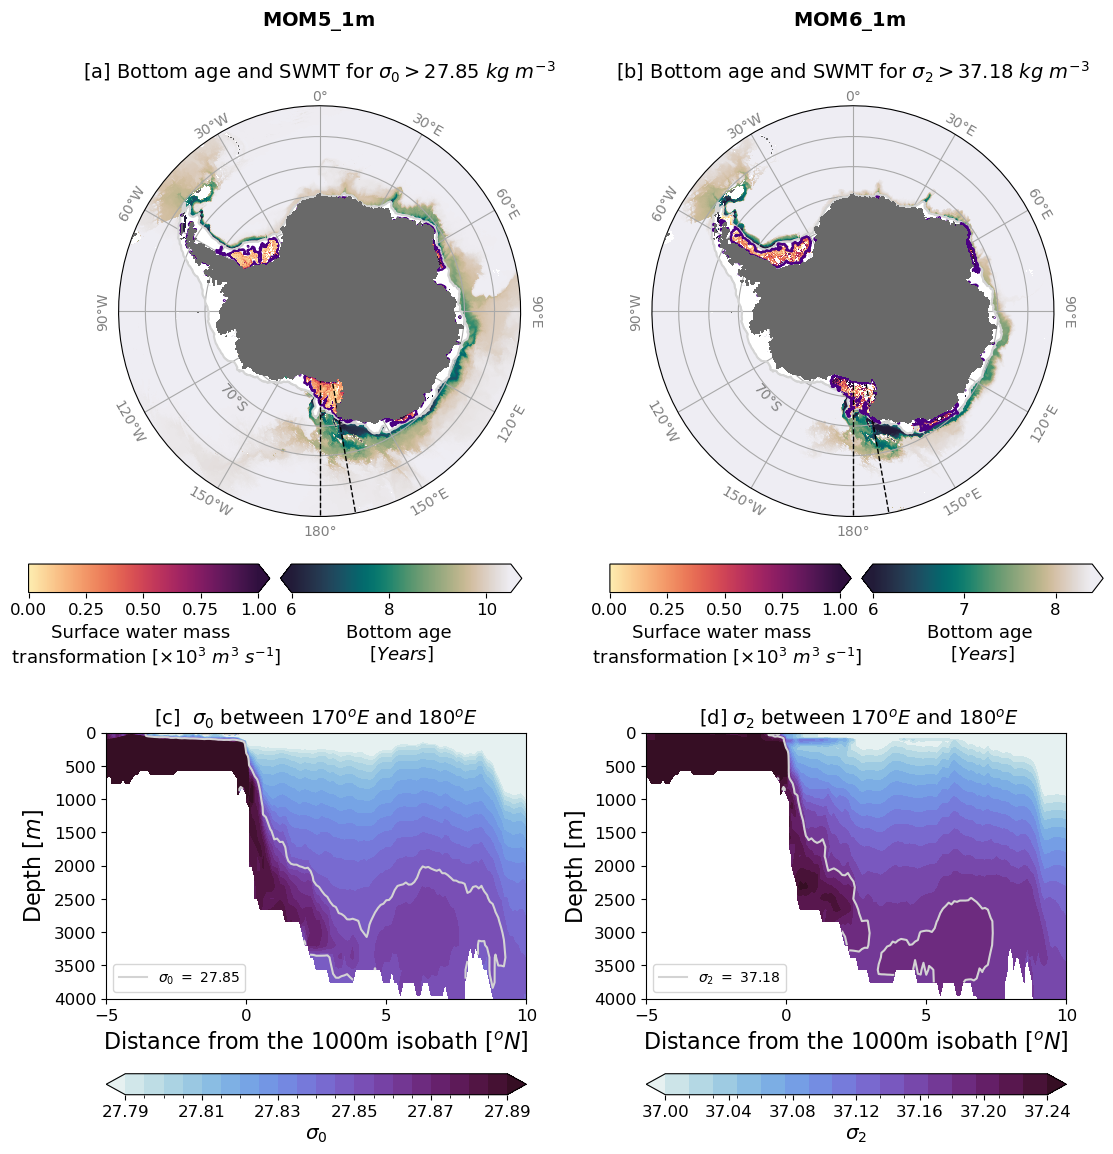

In [56]:
figure = plt.figure(num = 1, figsize = (12, 19))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.35)

SWMT_contour_color = 'indigo'
SWMT_contour_thickness = 1.6

#DSW definition polygon for MOM5
MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

#DSW definition polygon for MOM6
MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

yearind=slice(8,10)
#plots a and b, zonal means of density
#ax_bl = plt.subplot(3,2,5)
ax_bl = figure.add_axes([0.1, 0.37, 0.35, 0.2]) 
#levels_MOM5=[σ0_ref]
levels_MOM5=[σ0_DSW_1m_mindens]
levels_MOM5_n=np.arange(27.79,27.89,.005) #np.arange(27.8,27.86,.005)
σ0_ref = np.round(σ0_DSW_1m_mindens,2)
cf = (σ0_OM2_1m_ZM_lat_aligned_ross-1000).plot.contourf(levels=levels_MOM5_n,\
                                       add_colorbar=False,cmap=cmo.dense,ax = ax_bl); 
plt.xticks([-5, 0, 5, 10],fontsize=12); 

plt.yticks(fontsize=12);
cb = plt.colorbar(cf,ticks=[27.79, 27.81, 27.83, 27.85, 27.87, 27.89]\
                 , orientation='horizontal',anchor =  (0.5,0.5));
cb.set_label(label=r'$\sigma_0$',size='x-large', weight='bold')
cb.ax.tick_params(labelsize='large')
cl = (σ0_OM2_1m_ZM_lat_aligned_ross -1000).plot.contour(levels=levels_MOM5,colors='lightgray',ax = ax_bl);
plt.plot([-20,-20],[0,0],color='lightgray',label=r'$\sigma_0 \ = \ $' + str(np.round(levels_MOM5[0]*100)/100));
plt.ylabel(r'Depth [$m$]',fontsize=16);
plt.xlabel(r'Distance from the 1000m isobath [$^oN$]', fontsize=16)
#plt.clabel(cl); 
plt.ylim(4000,0);plt.xlim(-5,10)
plt.title(r'[c]  $\sigma_0$' + r' between $170^oE$ and $180^oE$', fontsize=14)
plt.legend(loc=3)

ax_br = figure.add_axes([0.55, 0.37, 0.35, 0.2]) 
levels_MOM6=[σ2_DSW_1m_mindens]
σ2_ref = σ2_DSW_1m_mindens
levels_MOM6_n=np.arange(37.0,37.24,.015) #np.arange(37.0,37.2,.015)
cf2 = (σ0_MOM6_1m_ZM_lat_aligned_ross-1000).plot.contourf(levels=levels_MOM6_n,\
                                       add_colorbar=False,cmap=cmo.dense,ax = ax_br); 
plt.xticks([-5, 0, 5, 10],fontsize=12); 
plt.yticks(fontsize=12);
cb2 = plt.colorbar(cf2,ticks=[37.0, 37.04, 37.08, 37.12,  37.16,  37.20, 37.24],\
                   orientation='horizontal',anchor =  (0.5,0.5)); cb2.set_label(label=r'$\sigma_2$',size='x-large', weight='bold')
cb2.ax.tick_params(labelsize='large')
plt.plot([-20,-20],[0,0],color='lightgray',label=r'$\sigma_2 \ = \ $' + str(np.round(levels_MOM6[0]*100)/100));
clMOM6 = (σ0_MOM6_1m_ZM_lat_aligned_ross-1000).plot.contour(levels=levels_MOM6,colors='lightgray',ax = ax_br); 
plt.ylabel('Depth [m]',fontsize=16);
plt.xlabel(r'Distance from the 1000m isobath [$^oN$]',fontsize=16)
#plt.clabel(clMOM6); 
plt.ylim(4000,0);plt.xlim(-5,10)
plt.title(r' [d] $\sigma_2$' + r' between $170^oE$ and $180^oE$', fontsize=14)
plt.legend(loc=3)


# # SWMT + mass transport in the same density level
# ax_c = plt.subplot(3,2,5)
# plt.plot(Overflowsum_OM1mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
#          Overflowsum_OM1mtop.isopycnal_bins,linestyle='-.', label='Overflow')
# plt.plot(swmt21mbath_sum.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_ctrl[0,:],\
#          color='tab:blue', label='SWMT')
# # plt.plot(swmt21mbath_sum_DSW.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_ctrl[0,:],\
# #          color='royalblue', linewidth = 4, linestyle= '--', label='DSW formation')
# plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
# ax_c.add_patch(MOM5_σ0_poly)
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# plt.xlim(-1,9)
# #plt.scatter(3.6, σ0_ref, color='tab:blue',label=r'$\sigma_0 =$'+str(σ0_ref)); 
# plt.ylim((28.2,27.4))
# plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel(r'$Sv$', fontsize=16)
# plt.legend(fontsize=12)
# plt.title(r"[e] Volume flux per $\sigma_0$ layer",fontsize=14)


# ax_d = plt.subplot(3,2,6)
# plt.plot(ShelfWMT_1dz.isel(time=yearind).mean('time')/1e6, \
#          ShelfWMT_1dz.isopycnal_bins, color='tab:blue', label='SWMT')
# plt.plot(Overflowsum_P1mtop.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l'),\
#          Overflowsum_P1mtop.rho2_l-1000,linestyle='-.', label='Overflow')
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# # plt.plot(ShelfWMT_1dz_DSW.isel(time=yearind).mean('time')/1e6, \
# #          ShelfWMT_1dz_DSW.isopycnal_bins,color='royalblue',\
# #          linewidth = 4, linestyle= '--', label='DSW formation')
# ax_d.add_patch(MOM6_σ2_poly)
# plt.ylim((37.55,36.8));plt.xlim(-1,9)
# plt.legend(fontsize=12)
# plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel(r'$Sv$', fontsize=16)
# plt.title(r"[f] Volume flux per $\sigma_2$ layer",fontsize=14)
# plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)


#maps with SWMT + ageOB ( Gee!)
proj = ccrs.PlateCarree()
ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax325.set_extent([-180, 180, -90, -55], proj)
ax325.set_boundary(circle, transform=ax325.transAxes)

gl = ax325.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                 -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)


plt.plot([-180,-180],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)
plt.plot([-190,-190],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)

ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj,)


p325_contour = ax325.contour(swmt21mbath_shelf_spatialplot.xt_ocean, swmt21mbath_shelf_spatialplot.yt_ocean,
                   swmt21mbath_shelf_spatialplot.sel(isopycnal_bins=slice(σ0_ref-.05,2000)).sum('isopycnal_bins')\
                             /1e3,\
                        levels=1,
                   colors=SWMT_contour_color, transform=proj,linewidths=SWMT_contour_thickness,
                   rasterized=True, zorder=2)

p325 = ax325.pcolormesh(swmt21mbath_shelf_spatialplot.xt_ocean, swmt21mbath_shelf_spatialplot.yt_ocean,
                   swmt21mbath_shelf_spatialplot.sel(isopycnal_bins=σ0_ref,method='nearest')/1e3,\
                        vmin=0, vmax=1,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)







pos = ax325.get_position()
cax = plt.axes([pos.xmin-.075, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])


cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax, extend='max')
cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)


p325_1 = ax325.pcolormesh(ageob_OM2_1m_offshelf.xt_ocean, ageob_OM2_1m_offshelf.yt_ocean,
                   ageob_OM2_1m_offshelf,\
                        vmin=6, vmax=10.5,
                   cmap=cmo.rain_r, transform=proj,
                   rasterized=True, zorder=0)

cax_0T = plt.axes([pos.xmin+0.135, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])
cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
cb325_1.ax.tick_params(labelsize=12)
cb325_1.ax.set_xlabel('Bottom age \n' +
                 r'[$Years$]',fontsize=13)
ax325.set_title(r'$\bf{MOM5}$_$\bf{1m}$' \
          +' \n \n'+'[a] Bottom age and SWMT for ' +  r'$\sigma_0>$' + str(σ0_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)









## subplot MOM6
ax326 = plt.subplot(3,2,2, projection=ccrs.SouthPolarStereo())

ax326.set_extent([-180, 180, -90, -55], proj)
ax326.set_boundary(circle, transform=ax326.transAxes)

gl2 = ax326.gridlines(draw_labels=False, color='darkgray')
gl2.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)

plt.plot([-180,-180],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj,zorder=4)
plt.plot([-190,-190],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj,zorder=4)


ax326.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)

plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj)

p326_contour = ax326.contour(ShelfWMT_1dz_spatialplot.xh, ShelfWMT_1dz_spatialplot.yh+0.2,
                   (shelf_mask_MOM6_nan * \
                    ShelfWMT_1dz_spatialplot.sel(isopycnal_bins=slice(σ2_ref+.012,2000)).sum('isopycnal_bins'))\
                             /1e3,\
                        levels=[0,],
                   colors=SWMT_contour_color, transform=proj,linewidths=SWMT_contour_thickness,
                   rasterized=True, zorder=4)


p326 = ax326.pcolormesh(ShelfWMT_1dz_spatialplot.xh, ShelfWMT_1dz_spatialplot.yh,
                   (shelf_mask_MOM6_nan * \
                    ShelfWMT_1dz_spatialplot.sel(isopycnal_bins=σ2_ref,method='nearest'))/1e3,\
                        vmin=0, vmax=1,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)
pos_2 = ax326.get_position()
cax_2 = plt.axes([pos_2.xmin-.035, pos_2.ymin-0.04,
                .6*(pos_2.xmax-pos_2.xmin), 0.015])
cb326 = plt.colorbar(p326, orientation='horizontal', cax=cax_2, extend='max')
cb326.ax.tick_params(labelsize=12)
cb326.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)

p326_1 = ax326.pcolormesh(ageob_MOM6_1m_offshelf.xh, ageob_MOM6_1m_offshelf .yh,
                   ageob_MOM6_1m_offshelf ,\
                        vmin=6, vmax=8.4,
                   cmap=cmo.rain_r, transform=proj,
                   rasterized=True, zorder=0)

cax_0T2 = plt.axes([pos_2.xmin+0.175, pos_2.ymin-0.04,
                .6*(pos_2.xmax-pos_2.xmin), 0.015])
cb326_1 = plt.colorbar(p326_1, orientation='horizontal', cax=cax_0T2, extend='both')
cb326_1.ax.tick_params(labelsize=12)
cb326_1.ax.set_xlabel('Bottom age \n' +
                 r'[$Years$]',fontsize=13)

ax326.set_title(r'$\bf{MOM6}$_$\bf{1m}$' +'  \n \n'+'[b] Bottom age and SWMT for ' +  r'$\sigma_2>$' + str(σ2_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)

# plt.savefig(figpath+'Rv0_Figure_1.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'Rv0_Figure_1.pdf',dpi=300,bbox_inches='tight')


In [57]:
#Logical test with KDS75 + 0.25 deg

lastdata_025_kds = xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS75/output115/ocean/ocean.nc')
lastdata_025_GFDL = xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_spinup_A/output008/ocean/ocean.nc')


# KDS75
age_025_KDS  = lastdata_025_kds.age_global.isel(time=0).sel(yt_ocean=slice(-90,-40))

depth_array_025 = age_025_KDS * 0 + age_025_KDS.st_ocean
max_depth_025 = depth_array_025.max(dim = 'st_ocean', skipna= True)
ageob_025_KDS = age_025_KDS.where(depth_array_025.st_ocean >= max_depth_025)
ageob_025_KDS = ageob_025_KDS.sum(dim = 'st_ocean')

# GFDL50
age_025_GFDL  = lastdata_025_GFDL.age_global.isel(time=0).sel(yt_ocean=slice(-90,-40))

depth_array_GFDL = (age_025_GFDL * 0) + age_025_GFDL.st_ocean
max_depth_GFDL = depth_array_GFDL.max(dim = 'st_ocean', skipna= True)
ageob_025_GFDL = age_025_GFDL.where(depth_array_GFDL.st_ocean >= max_depth_GFDL)
ageob_025_GFDL = ageob_025_GFDL.sum(dim = 'st_ocean')




In [58]:
# figure = plt.figure(num = 1, figsize = (12, 19))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.25,
#                     hspace=0.35)

# #maps with SWMT + ageOB ( Gee!)
# proj = ccrs.PlateCarree()
# ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
# ax325.set_extent([-180, 180, -90, -55], proj)
# ax325.set_boundary(circle, transform=ax325.transAxes)

# gl = ax325.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)


# plt.plot([-180,-180],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)
# plt.plot([-190,-190],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)

# ax325.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'lightgray', linewidth=.7,
#             transform=proj,)





# p325_1 = ax325.pcolormesh(ageob_025_KDS.xt_ocean, ageob_025_KDS.yt_ocean,
#                    ageob_025_KDS.where(max_depth_025>1000),\
#                         vmin=6, vmax=20.5,
#                    cmap=cmo.rain_r, transform=proj,
#                    rasterized=True, zorder=0)


# cax_0T = plt.axes([pos.xmin+0.05, pos.ymin-0.04,
#                 .6*(pos.xmax-pos.xmin), 0.015])
# cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
# cb325_1.ax.tick_params(labelsize=12)
# cb325_1.ax.set_xlabel('Bottom age \n' +
#                  r'[$Years$]',fontsize=13)
# ax325.set_title(r'$\bf{MOM5}$_$\bf{0.25^0}$_$\bf{KDS75}$' \
#           +' \n \n'+'[a] Bottom age for z > 1000m, year 199', pad=20, fontsize=14)



In [59]:
# figure = plt.figure(num = 1, figsize = (12, 19))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.25,
#                     hspace=0.35)


# #maps with SWMT + ageOB ( Gee!)
# proj = ccrs.PlateCarree()
# ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
# ax325.set_extent([-180, 180, -90, -55], proj)
# ax325.set_boundary(circle, transform=ax325.transAxes)

# gl = ax325.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)


# plt.plot([-180,-180],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)
# plt.plot([-190,-190],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)

# ax325.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'lightgray', linewidth=.7,
#             transform=proj,)





# p325_1 = ax325.pcolormesh(ageob_025_KDS.xt_ocean, ageob_025_KDS.yt_ocean,
#                    ageob_025_KDS.where(max_depth_025>1000),\
#                         vmin=6, vmax=10.2,
#                    cmap=cmo.rain_r, transform=proj,
#                    rasterized=True, zorder=0)


# cax_0T = plt.axes([pos.xmin+0.05, pos.ymin-0.04,
#                 .6*(pos.xmax-pos.xmin), 0.015])
# cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
# cb325_1.ax.tick_params(labelsize=12)
# cb325_1.ax.set_xlabel('Bottom age \n' +
#                  r'[$Years$]',fontsize=13)
# ax325.set_title(r'$\bf{MOM5}$_$\bf{0.25^0}$_$\bf{KDS75}$' \
#           +' \n \n'+'[a] Bottom age for z > 1000m, year 11', pad=20, fontsize=14)








# #maps with SWMT + ageOB ( Gee!)
# proj = ccrs.PlateCarree()
# ax326 = plt.subplot(3,2,2, projection=ccrs.SouthPolarStereo())
# ax326.set_extent([-180, 180, -90, -55], proj)
# ax326.set_boundary(circle, transform=ax326.transAxes)

# gl = ax326.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)


# plt.plot([-180,-180],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)
# plt.plot([-190,-190],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)

# ax326.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'lightgray', linewidth=.7,
#             transform=proj,)


# p326_1 = ax326.pcolormesh(ageob_025_GFDL.xt_ocean, ageob_025_GFDL.yt_ocean,
#                    ageob_025_GFDL.where(max_depth_GFDL>1000),\
#                         vmin=6, vmax=10.2,
#                    cmap=cmo.rain_r, transform=proj,
#                    rasterized=True, zorder=0)


# cax_0T = plt.axes([pos.xmin+0.05, pos.ymin-0.04,
#                 .6*(pos.xmax-pos.xmin), 0.015])
# cb326_1 = plt.colorbar(p326_1, orientation='horizontal', cax=cax_0T, extend='both')
# cb326_1.ax.tick_params(labelsize=12)
# cb326_1.ax.set_xlabel('Bottom age \n' +
#                  r'[$Years$]',fontsize=13)
# ax326.set_title(r'$\bf{MOM5}$_$\bf{0.25^0}$_$\bf{GFDL}$' \
#           +' \n \n'+'[a] Bottom age for z > 1000m, year 11', pad=20, fontsize=14)



____________________________
____________________________

# Figure 2


Lets create a filtered SWMT variable for MOM5 and MOM6 for DSW formation alone

In [60]:
#and for OM2, 1m case ##################################
#σ0_DSW_1m_mindens.values, σ0_DSW_1m_maxdens.values

swmt21mbath_sum_DSW =  swmt21mbath_sum.where(swmt21mbath_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt21mbath_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)



# #and for OM2, 0.5m case ##################################
swmthalfMtop_sum_DSW =  swmthalfMtop_sum.where(swmthalfMtop_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmthalfMtop_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)




# #and for OM2, 5m case ##################################
swmt5mtop_sum_DSW =  swmt5mtop_sum.where(swmt5mtop_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt5mtop_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)

In [61]:
## for MOM6  1m case ####################
ShelfWMT_1dz_DSW  =ShelfWMT_1dz.where(ShelfWMT_1dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz.isopycnal_bins<=σ2_DSW_1m_maxdens)


## for MOM6  5m case ####################
ShelfWMT_5dz_DSW  =ShelfWMT_5dz.where(ShelfWMT_5dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_5dz.isopycnal_bins<=σ2_DSW_1m_maxdens)

In [62]:
ShelfWMT_1dz.load()
ShelfWMT_5dz.load()

<xarray.DataArray (time: 10, isopycnal_bins: 160)> Size: 13kB
array([[2.20806195e+06, 2.36186755e+06, 2.38071922e+06, ...,
        7.28581473e+03, 1.09304657e+04, 7.72585880e+03],
       [2.26404308e+06, 2.50493490e+06, 2.67539015e+06, ...,
        3.13547633e+03, 1.32579150e+04, 0.00000000e+00],
       [2.76086912e+06, 2.72753616e+06, 2.82528349e+06, ...,
        0.00000000e+00, 1.93355280e+04, 1.53655596e+04],
       ...,
       [3.03985019e+06, 3.08639622e+06, 3.15498270e+06, ...,
        4.18356835e+03, 4.45101157e+03, 6.68256583e+03],
       [2.87672055e+06, 2.91705690e+06, 2.98750816e+06, ...,
        0.00000000e+00, 1.02267013e+04, 0.00000000e+00],
       [3.03089945e+06, 3.18400722e+06, 2.86198025e+06, ...,
        6.79859644e+03, 6.65558326e+03, 0.00000000e+00]])
Coordinates:
  * time            (time) int64 80B 1991 1992 1993 1994 ... 1997 1998 1999 2000
  * isopycnal_bins  (isopycnal_bins) float64 1kB 36.8 36.81 36.81 ... 37.59 37.6

In [63]:
import matplotlib.image as mpimg

In [64]:
ShelfWMT_5dz_weakwinds.load()
print('data loaded')

data loaded


this shows that weakening the winds to the level of the 1m simulation dont fix the problem (SWMT still the same). so the total transport perhaps do not matter.

Next: try a 1 meter simulation with stronger winds.... i.e., if this simulation has the same SWMT as 1m then that means that what matter is solving the spiral, not the total transport.

Text(0.5, 0, 'Simulation year')

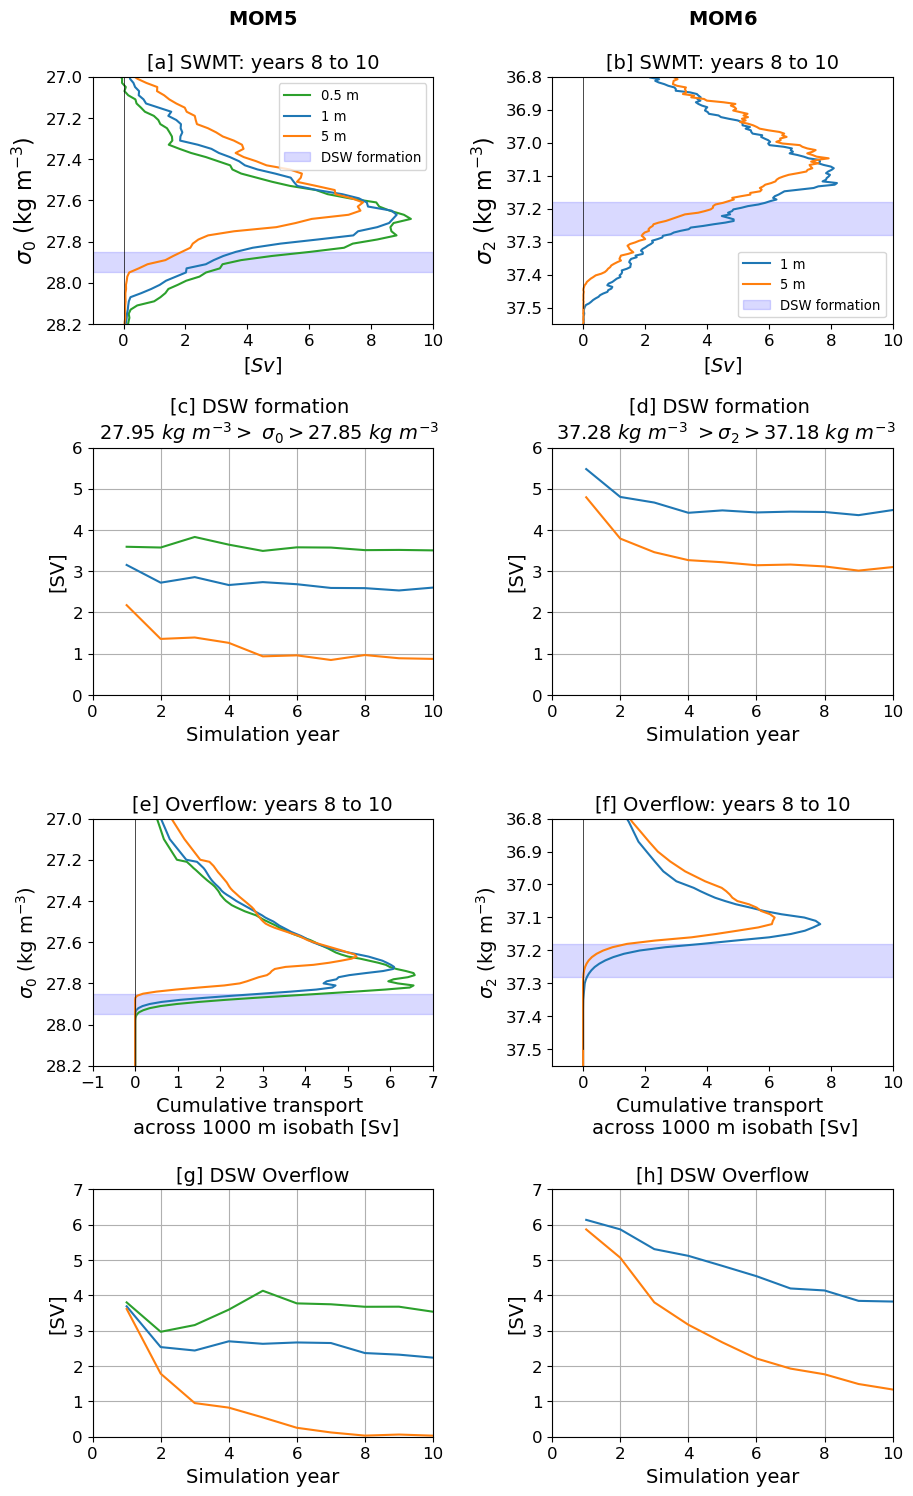

In [65]:
figure = plt.figure(num=1, figsize = (10,17))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.35, 
                    hspace=0.5)


#DSW definition polygon for MOM5
MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')


### MOM5 first
ax_421 = plt.subplot(4,2,1)
plt.plot(swmthalfMtop_sum.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:green',label='0.5 m')
plt.plot(swmt21mbath_sum.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(swmt5mtop_sum.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_421.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27)); plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title(r"$\bf{MOM5}$" +"\n \n" + r"[a] SWMT: years 8 to 10",fontsize=14)



MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15)
ax_423 = plt.subplot(4,2,5)
plt.plot(Overflowsum_OMhalfMtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OMhalfMtop.isopycnal_bins,color='tab:green')
plt.plot(Overflowsum_OM1mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM1mtop.isopycnal_bins, color='tab:blue')
plt.plot(Overflowsum_OM5mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM5mtop.isopycnal_bins,color='tab:orange')
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_423.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,7); #plt.legend(fontsize=12)
plt.ylim((28.2,27)); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Cumulative transport \n across 1000 m isobath [Sv]', fontsize=14)
plt.title(r"[e] Overflow: years 8 to 10",fontsize=14)




plt.subplot(4,2,3)
#SWMT:
(swmthalfMtop_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:green')
(swmt21mbath_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:blue')
(swmt5mtop_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:orange')
plt.xlim(1990.5,2000); plt.ylim(0,6)
#plt.legend(fontsize=10); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14)
plt.title("[c] DSW formation \n " + r' $27.95\ kg \ m^{-3} >$ $\sigma_0 >$' + str(σ0_ref) + r' $kg \ m^{-3}$',fontsize=14)
plt.xlabel('Simulation year', fontsize=14)



plt.subplot(4,2,7)
#overflow:
(Overflowsum_OMhalfMtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OMhalfMtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:green',label='MOM5_halfm')
(Overflowsum_OM1mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM1mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:blue',label='MOM5_1m')
(Overflowsum_OM5mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM5mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:orange',label='MOM5_5m')
plt.xlim(1990.5,2000); plt.ylim(0,7)
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.title("[g] DSW Overflow",fontsize=14)
plt.xlabel('Simulation year', fontsize=14)


##MOM6 now
#DSW definition polygon for MOM6
MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

ax_422 = plt.subplot(4,2,2)
plt.plot(ShelfWMT_1dz.isel(time=yearind).mean('time')/1e6, ShelfWMT_1dz.isopycnal_bins, color='tab:blue',label='1 m')
plt.plot(ShelfWMT_5dz.isel(time=yearind).mean('time')/1e6, ShelfWMT_5dz.isopycnal_bins, color='tab:orange',label='5 m')
plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)
ax_422.add_patch(MOM6_σ2_poly)
#plt.plot([-1, 10], [σ2_ref,σ2_ref], 'b', linewidth=0.5,label=r'$\sigma_2 =$'+str(σ2_ref)); 
plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((37.55,36.8)); plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title(r"$\bf{MOM6}$" +"\n \n" + r"[b] SWMT: years 8 to 10",fontsize=14)


MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15)

ax_424 = plt.subplot(4,2,6)
plt.plot(Overflowsum_P1mtop.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l')\
         ,Overflowsum_P1mtop.rho2_l-1000, color='tab:blue')
plt.plot(Overflowsum_P5mtop.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l'),\
         Overflowsum_P5mtop.rho2_l-1000,color='tab:orange')
plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)
ax_424.add_patch(MOM6_σ2_poly)
#plt.plot([-1, 10], [σ2_ref,σ2_ref], 'b', linewidth=0.5,label=r'$\sigma_2 =$'+str(σ2_ref)); 
plt.xlim(-1,10); #plt.legend(fontsize=12)
plt.ylim((37.55,36.8)); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Cumulative transport \n across 1000 m isobath [Sv]', fontsize=14)
plt.title(r"[f] Overflow: years 8 to 10",fontsize=14)


plt.subplot(4,2,4)
#SWMT:
(ShelfWMT_1dz_DSW.mean('isopycnal_bins')/1e6).plot(color='tab:blue')
(ShelfWMT_5dz_DSW.mean('isopycnal_bins')/1e6).plot(color='tab:orange')
plt.xlim(1990.5,2000); plt.ylim(0,6)
#plt.legend(fontsize=10); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14)
plt.title("[d] DSW formation \n" +r' $37.28\ kg \ m^{-3}\ >$' + r'$\sigma_2>$' + str(σ2_ref) + r' $kg \ m^{-3}$',fontsize=14)
plt.xlabel('Simulation year', fontsize=14)



plt.subplot(4,2,8)
#overflow:
(Overflowsum_P1mtop.vol_trans_across_contour.cumsum('rho2_l').\
 where(Overflowsum_P1mtop.rho2_l>σ2_DSW_1m_mindens+1000).max('rho2_l'))\
.plot(color='tab:blue',label='MOM5_1m')
(Overflowsum_P5mtop.vol_trans_across_contour.cumsum('rho2_l').\
 where(Overflowsum_P5mtop.rho2_l>σ2_DSW_1m_mindens+1000).max('rho2_l'))\
.plot(color='tab:orange',label='MOM5_5m')
plt.xlim(1990.5,2000); plt.ylim(0,7)
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.title("[h] DSW Overflow" ,fontsize=14)
plt.xlabel('Simulation year', fontsize=14)

# plt.savefig(figpath+'Rv0_Figure_2.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'Rv0_Figure_2.pdf',dpi=300,bbox_inches='tight')



____________________________
____________________________

# Figure 3

In this figure, we will how the SWMT in the 1mtop cases would look like if we decrease teh surface fluxes to the 5mtop levels. The goal here is to diagnose if the DSW halting comes from weaker sea ice formation

#### Edits in the SWMT for the decreased sea ice formation case

After calcualting the density flux through the SWMT ($\Omega(\sigma, t)$), this flux is binned into the surface densities of the ocean model, in order to be able to classify in which density class that density flux goes into. That efectively gives us the rate of transforamtion per density class, as seen in figures 1 and 2.

In this figurem one eddit will be applied to that approach.... we will caclculate the density fluxes in each one of the 5m top simulations ($\Omega_{5m}(\sigma, t)$), and bin thos fsurface fluxes from the 5m simulations into the surface densities of the 1m simulations. That approach allows us to diagnose if a weakening in the surface fluxes in the 5m case simulation would be enough to cause the weaker rate of transformation we see in the 5m case, in the dense locations where the 1m simulation forms DSW.



In [66]:
def shelf_mask_isobath_MOM5(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

def shelf_mask_isobathMOM6(var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

**Importing the SWMT for decreased sea ice in MOM6**

In [67]:

gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panant-01-1mdensities_5mfluxes/SWMT*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_lowSI=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
P01_lowSI = (P01_lowSI.binned_salt_transformation + P01_lowSI.binned_heat_transformation)


#get here the total SWMT saved
ShelfWMT_lowSI_3d = shelf_mask_isobathMOM6(P01_lowSI,1000, '01')
ShelfWMT_lowSI = ShelfWMT_lowSI_3d.sum('xh').sum('yh').load()


10 netcdf data files


**Importing the SWMT for decreased sea ice in MOM5**

In [68]:

gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_OM2-1mdensities_5mfluxes/SWMT*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
OM2_lowSI=xr.open_mfdataset(gl, concat_dim='time',combine='nested').SWMT/1e6



#OM2_lowSI_shelf, shelf_mask = shelf_mask_isobath_MOM5(OM2_lowSI)
OM2_lowSI_sum = (OM2_lowSI).sum(['xt_ocean', 'yt_ocean']).load()

10 netcdf data files


Importing freshwater fluxes from sea ice in MOM5 and MOM6

In [69]:
#for MOM5
from gsw import beta
from gsw import p_from_z
start_time_OM2 = '1907-01'
end_time_OM2 = '1909-12'
time_slice_OM2 = slice(start_time_OM2,end_time_OM2)


start_month = int(start_time_OM2[5:7])
end_month = int(end_time_OM2[5:7])


########### MOM5_1m ##############################################
SST = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'temp', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).isel(st_ocean=0).\
sel(time=time_slice_OM2) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
SSS_PSU = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'salt', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).isel(st_ocean=0).\
sel(time=time_slice_OM2) # SSS - practical salinity (not absolute)
pme_river = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pme_river', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).sel(time=time_slice_OM2)       # mass flux of precip - evap + river
sfc_salt_flux_ice = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'sfc_salt_flux_ice', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).sel(time=time_slice_OM2)         # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'sfc_salt_flux_restore', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).sel(time=time_slice_OM2) # mass flux of salt from surface salinity restoring

depth_tile_1m = (((σ0_OM2_1m*0)+1) * σ0_OM2_1m.st_ocean).isel(st_ocean=0)
lat_t_1m = (((σ0_OM2_1m*0)+1) * σ0_OM2_1m.yt_ocean).isel(st_ocean=0)
lon_t_1m = (((σ0_OM2_1m*0)+1) * σ0_OM2_1m.xt_ocean).isel(st_ocean=0)
pressure_1m = p_from_z(depth_tile_1m, lat_t_1m)



SSS = SA_from_SP(SSS_PSU, pressure_1m, lon_t_1m, lat_t_1m)

time_monthly = SST.time.values

n_years = int(len(SST.time)/12)
months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
if start_month != 1:
    months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
else:
    months_offset_noleap = months_standard_noleap

    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')



haline_contraction_1m = beta(SSS, SST, pressure_1m)
FWF_1m = haline_contraction_1m * (SSS * pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)*1000) * days_per_month #! before was PSU, why?
FWF_1m = (FWF_1m * areat_shelf).sum(('xt_ocean','yt_ocean'))
FWF_1m.load()

del haline_contraction_1m, SSS, SSS_PSU, SST, pme_river, sfc_salt_flux_ice, sfc_salt_flux_restore
del depth_tile_1m, lat_t_1m, lon_t_1m, pressure_1m


########### MOM5_5m ##############################################
SST = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'temp', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).isel(st_ocean=0).\
sel(time=time_slice_OM2) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
SSS_PSU = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'salt', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).isel(st_ocean=0).\
sel(time=time_slice_OM2) # SSS - practical salinity (not absolute)
pme_river = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'pme_river', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).sel(time=time_slice_OM2)       # mass flux of precip - evap + river
sfc_salt_flux_ice = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'sfc_salt_flux_ice', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).sel(time=time_slice_OM2)         # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'sfc_salt_flux_restore', session,\
                         start_time = start_time_OM2, end_time  = end_time_OM2).sel(time=time_slice_OM2) # mass flux of salt from surface salinity restoring

depth_tile_5m = (((σ0_OM2_5m*0)+1) * σ0_OM2_5m.st_ocean).isel(st_ocean=0)
lat_t_5m = (((σ0_OM2_5m*0)+1) * σ0_OM2_5m.yt_ocean).isel(st_ocean=0)
lon_t_5m = (((σ0_OM2_5m*0)+1) * σ0_OM2_5m.xt_ocean).isel(st_ocean=0)
pressure_5m = p_from_z(depth_tile_5m, lat_t_5m)



SSS = SA_from_SP(SSS_PSU, pressure_5m, lon_t_5m, lat_t_5m)


haline_contraction_5m = beta(SSS, SST, pressure_5m)
FWF_5m = haline_contraction_5m * (SSS * pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)*1000) * days_per_month
FWF_5m = (FWF_5m * areat_shelf).sum(('xt_ocean','yt_ocean'))
FWF_5m.load()

del haline_contraction_5m, SSS, SSS_PSU, SST, pme_river, sfc_salt_flux_ice, sfc_salt_flux_restore
del depth_tile_5m, lat_t_5m, lon_t_5m, pressure_5m


print('OM2 freshwater fluxes loaded')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

OM2 freshwater fluxes loaded


In [70]:
areacello_shelf = ShelfWMT_lowSI_3d = shelf_mask_isobathMOM6(areacello,1000, '01')
areacello_shelf.load()

<xarray.DataArray (yh: 533, xh: 3600)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07

In [71]:
# for MOM6
from gsw import CT_from_pt

start_time_MOM6 = '1997-01'
end_time_MOM6 = '1999-12'
time_slice_MOM6 = slice(start_time_MOM6,end_time_MOM6)

start_month = int(start_time_MOM6[5:7])
end_month = int(end_time_MOM6[5:7])


########### MOM6_1m ##############################################
SST = cc.querying.getvar(
    'panant-01-zstar-ACCESSyr2', 'thetao', session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).isel(z_l=0).sel(time=time_slice_MOM6)
# practical salinity
SSS_PSU =  cc.querying.getvar(
    'panant-01-zstar-ACCESSyr2', 'so', session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).isel(z_l=0).sel(time=time_slice_MOM6)

# mass flux of precip - evap + river ((kg of water)/m^2/s )
pme_river = cc.querying.getvar(
    'panant-01-zstar-ACCESSyr2', 'wfo', session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).sel(time=time_slice_MOM6)
# Net salt flux into ocean at surface (restoring + sea-ice) 
# ((kg of salt)/m^2/s )
salt_flux = cc.querying.getvar(
    'panant-01-zstar-ACCESSyr2', 'salt_flux', session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).sel(time=time_slice_MOM6)

# extract coordinate arrays
time_monthly = SST.time.values
yh = SST.yh.values
xh = SST.xh.values

months_standard_noleap = np.tile(np.array(
    [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]),3)
days_per_month = xr.DataArray(
    months_standard_noleap,
    coords=[time_monthly], dims=['time'], name='days per month')


depth_tile_1m = (((σ0_MOM6_1m*0)+1) * σ0_MOM6_1m.z_l).isel(z_l=0)
yh_1m = (((σ0_MOM6_1m*0)+1) * σ0_MOM6_1m.yh).isel(z_l=0)
xh_1m = (((σ0_MOM6_1m*0)+1) * σ0_MOM6_1m.xh).isel(z_l=0)

pressure = p_from_z(depth_tile_1m, yh_1m)

SSS = SA_from_SP(SSS_PSU, pressure, xh_1m, yh_1m)
SST_Conservative = CT_from_pt(SSS, SST)
haline_contraction = beta(SSS, SST_Conservative, pressure)

FWF_MOM6_1m  = (days_per_month * haline_contraction * (SSS * pme_river - 1000 * salt_flux)) *areacello_shelf
FWF_MOM6_1m = FWF_MOM6_1m.sum(('xh','yh')).load()

del haline_contraction, SSS, SSS_PSU, SST, pme_river, salt_flux, SST_Conservative
del depth_tile_1m, yh_1m, xh_1m



########### MOM6_5m ##############################################
SST = cc.querying.getvar(
    'mom6-panan', 'thetao', temp_session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).isel(z_l=0).sel(time=time_slice_MOM6)
# practical salinity
SSS_PSU =  cc.querying.getvar(
    'mom6-panan', 'so', temp_session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).isel(z_l=0).sel(time=time_slice_MOM6)

# mass flux of precip - evap + river ((kg of water)/m^2/s )
pme_river = cc.querying.getvar(
    'mom6-panan', 'wfo', temp_session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).sel(time=time_slice_MOM6)
# Net salt flux into ocean at surface (restoring + sea-ice) 
# ((kg of salt)/m^2/s )
salt_flux = cc.querying.getvar(
    'mom6-panan', 'salt_flux', temp_session, frequency='1 monthly',
    start_time=start_time_MOM6, end_time=end_time_MOM6,
    chunks={'yh': '200MB', 'xh': '200MB'}).sel(time=time_slice_MOM6)

# extract coordinate arrays
time_monthly = SST.time.values
yh = SST.yh.values
xh = SST.xh.values

months_standard_noleap = np.tile(np.array(
    [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]),3)
days_per_month = xr.DataArray(
    months_standard_noleap,
    coords=[time_monthly], dims=['time'], name='days per month')


depth_tile_5m = (((σ0_MOM6_5m*0)+1) * σ0_MOM6_5m.z_l).isel(z_l=0)
yh_5m = (((σ0_MOM6_5m*0)+1) * σ0_MOM6_5m.yh).isel(z_l=0)
xh_5m = (((σ0_MOM6_5m*0)+1) * σ0_MOM6_5m.xh).isel(z_l=0)

pressure = p_from_z(depth_tile_5m, yh_5m)

SSS = SA_from_SP(SSS_PSU, pressure, xh_5m, yh_5m)
SST_Conservative = CT_from_pt(SSS, SST)
haline_contraction = beta(SSS, SST_Conservative, pressure)

FWF_MOM6_5m  = (days_per_month * haline_contraction * (SSS * pme_river - 1000 * salt_flux)) *areacello_shelf
FWF_MOM6_5m = FWF_MOM6_5m.sum(('xh','yh')).load()

del haline_contraction, SSS, SSS_PSU, SST, pme_river, salt_flux, SST_Conservative
del depth_tile_5m, yh_5m, xh_5m



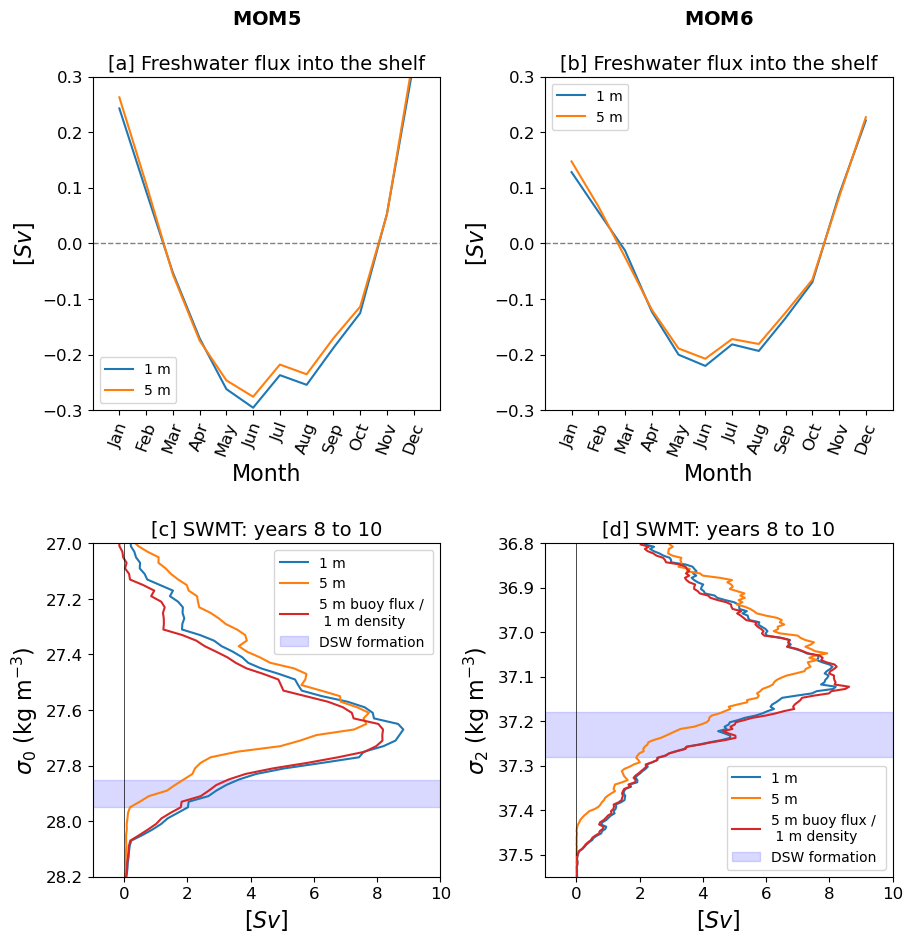

In [80]:
figure = plt.figure(num=1, figsize = (10,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

#DSW definition polygon for MOM5
MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')
Yrs_crossSWMT = slice(8,10)

### MOM5 first
ax_221 = plt.subplot(2,2,3)
plt.plot(swmt21mbath_sum.isel(time=Yrs_crossSWMT).mean('time'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(swmt5mtop_sum.isel(time=Yrs_crossSWMT).mean('time'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')
plt.plot(OM2_lowSI_sum.isel(time=Yrs_crossSWMT).mean('time'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:red',label='5 m buoy flux / \n 1 m density')
# plt.plot(swmt21mbath_sum_DSW.isel(time=slice(0,3)).mean('time'), isopycnal_bin_midmom5_ctrl[0,:],\
#          color='royalblue', linewidth = 4, linestyle= '--')
ax_221.add_patch(MOM5_σ0_poly)
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27)); plt.legend(fontsize=10)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=16)
plt.title(r"[c] SWMT: years 8 to 10",fontsize=14)


MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

ax_222 = plt.subplot(2,2,4)
plt.plot(ShelfWMT_1dz.isel(time=Yrs_crossSWMT).mean('time')/1e6, ShelfWMT_1dz.isopycnal_bins, color='tab:blue',label='1 m')
plt.plot(ShelfWMT_5dz.isel(time=Yrs_crossSWMT).mean('time')/1e6, ShelfWMT_5dz.isopycnal_bins, color='tab:orange',label='5 m')
plt.plot(ShelfWMT_lowSI.isel(time=Yrs_crossSWMT).mean('time')/1e6, ShelfWMT_5dz.isopycnal_bins, color='tab:red',label='5 m buoy flux / \n 1 m density')
# plt.plot(ShelfWMT_1dz_DSW.isel(time=slice(0,3)).mean('time')/1e6, \
#          ShelfWMT_1dz_DSW.isopycnal_bins,color='royalblue',\
#          linewidth = 4, linestyle= '--')
ax_222.add_patch(MOM6_σ2_poly)
plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)

plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((37.55,36.8)); plt.legend(fontsize=10)
plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=16)
plt.title(r"[d] SWMT: years 8 to 10",fontsize=14)


plt.subplot(2,2,1)
(FWF_1m.groupby('time.month').mean()*1e-6/1035).plot(color='tab:blue',label='1 m')
(FWF_5m.groupby('time.month').mean()*1e-6/1035).plot(color='tab:orange',label='5 m')
plt.plot([0,13],[0,0],color='grey',linestyle = '--', linewidth=1)
plt.ylabel(r'[$Sv$]', fontsize = 16)
plt.xlabel( r'Month', fontsize=16)
plt.title(r"$\bf{MOM5}$" +"\n \n" + r"[a] Freshwater flux into the shelf",fontsize=14)
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],\
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],\
           rotation = 70, fontsize=12); 
plt.yticks(fontsize=12);
plt.xlim(0,13)
plt.ylim(-.3,.3); plt.legend(fontsize=10)

plt.subplot(2,2,2)
(FWF_MOM6_1m.groupby('time.month').mean()*1e-6/1035).plot(color='tab:blue',label='1 m')
(FWF_MOM6_5m.groupby('time.month').mean()*1e-6/1035).plot(color='tab:orange',label='5 m')
plt.plot([0,13],[0,0],color='grey',linestyle = '--', linewidth=1)

plt.ylabel(r'[$Sv$]', fontsize = 16)
plt.xlabel( r'Month', fontsize=16)
plt.title(r"$\bf{MOM6}$" +"\n \n" + r"[b] Freshwater flux into the shelf",fontsize=14)
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],\
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],\
           rotation = 70, fontsize=12); 
plt.yticks(fontsize=12);
plt.xlim(0,13)
plt.ylim(-.3,.3); plt.legend(fontsize=10)

plt.savefig(figpath+'Rv0_Figure_3.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'Rv0_Figure_3.pdf',dpi=300,bbox_inches='tight')



What percentage of changes in DSW formation can be attributed to the differences in sea ice formation?

In [78]:

Reduced_sea_ice_OM2 = OM2_lowSI_sum.where(OM2_lowSI_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(OM2_lowSI_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)

#first 3-year mean changes in DSW due to lower sea ice formation
Reduced_sea_ice_OM2 =  Reduced_sea_ice_OM2.isel(time = Yrs_crossSWMT).mean('time').mean('isopycnal_bins')
#first 3-year mean DSW formation in OM2_1m
OM2_1mtop_first3years  = swmt21mbath_sum_DSW.isel(time = Yrs_crossSWMT).mean('time').mean('isopycnal_bins')
#first 3-year mean DSW formation in OM2_5m
OM2_5mtop_first3years  = swmt5mtop_sum_DSW.isel(time = Yrs_crossSWMT).mean('time').mean('isopycnal_bins')

reduction_5to1m = OM2_1mtop_first3years - OM2_5mtop_first3years
reduction_sea_ice = OM2_1mtop_first3years - Reduced_sea_ice_OM2
reduction_fraction = (reduction_sea_ice/reduction_5to1m)*100
reduction_sea_ice.values,reduction_5to1m.values , reduction_fraction.values

print('In MOM5, the differences in sea ice fluxes between simulations explain ' +\
     str(int(reduction_fraction.values)) + '% of the DSW reduction. \nSpecifically: \n \n ' +\
     '- DSW formation reduction from 5m to 1m = ' + str(np.round(reduction_5to1m.values,1)) + ' Sv' + \
     '\n - DSW formation reduction from lower sea ice formation in 5m = ' +\
      str(np.round(reduction_sea_ice.values,1)) + ' Sv')





In MOM5, the differences in sea ice fluxes between simulations explain 14% of the DSW reduction. 
Specifically: 
 
 - DSW formation reduction from 5m to 1m = 1.7 Sv
 - DSW formation reduction from lower sea ice formation in 5m = 0.2 Sv


In [79]:

Reduced_sea_ice_MOM6 = ShelfWMT_lowSI.where(ShelfWMT_lowSI.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_lowSI.isopycnal_bins<=σ2_DSW_1m_maxdens)



# plt.plot(ShelfWMT_1dz.isel(time=Yrs_crossSWMT).mean('time')/1e6, ShelfWMT_1dz.isopycnal_bins, color='tab:blue',label='1 m')
# plt.plot(ShelfWMT_5dz.isel(time=Yrs_crossSWMT).mean('time')/1e6, ShelfWMT_5dz.isopycnal_bins, color='tab:orange',label='5 m')
# plt.plot(ShelfWMT_lowSI.is

#first 3-year mean changes in DSW due to lower sea ice formation
Reduced_sea_ice_MOM6 =  Reduced_sea_ice_MOM6.isel(time = Yrs_crossSWMT).mean('time').mean('isopycnal_bins')/1e6
#first 3-year mean DSW formation in OM2_1m
MOM6_1mtop_first3years  = ShelfWMT_1dz.where(ShelfWMT_lowSI.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_lowSI.isopycnal_bins<=σ2_DSW_1m_maxdens).isel(time = Yrs_crossSWMT).mean('time').mean('isopycnal_bins')/1e6
#first 3-year mean DSW formation in OM2_5m
MOM6_5mtop_first3years  = ShelfWMT_5dz.where(ShelfWMT_lowSI.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_lowSI.isopycnal_bins<=σ2_DSW_1m_maxdens).isel(time = Yrs_crossSWMT).mean('time').mean('isopycnal_bins')/1e6

reduction_5to1m =MOM6_1mtop_first3years - MOM6_5mtop_first3years
reduction_sea_ice = MOM6_1mtop_first3years - Reduced_sea_ice_MOM6
reduction_fraction = (reduction_sea_ice/reduction_5to1m)*100
reduction_sea_ice.values,reduction_5to1m.values , reduction_fraction.values

print('In MOM6, the differences in sea ice fluxes between simulations explain ' +\
     str(int(reduction_fraction.values)) + '% of the DSW reduction. \nSpecifically: \n \n ' +\
     '- DSW formation reduction from 5m to 1m = ' + str(np.round(reduction_5to1m.values,1)) + ' Sv' + \
     '\n - DSW formation reduction from lower sea ice formation in 5m = ' +\
      str(np.round(reduction_sea_ice.values,1)) + ' Sv')



In MOM6, the differences in sea ice fluxes between simulations explain -10% of the DSW reduction. 
Specifically: 
 
 - DSW formation reduction from 5m to 1m = 1.4 Sv
 - DSW formation reduction from lower sea ice formation in 5m = -0.1 Sv


____________________________
____________________________

# Figure 5

In this figure, we will show that in the beggining of the summer, in the control simulation, offshore waters are fresher than waters on the shelf, likely due to sea ice melt dueing the summer. These fresher waters comibined with a stronger Ekman transport towards the shelf makes the shelf fresher, and DSW resistant

Let's import the first month salinity in each simulation

In [76]:
#importing first month salinity field in MOM5and MOM6
large_lat_slice=slice(-90,-50)
depth_slice_20m = slice(0,50)
depth_slice_5m = slice(0,50)


#define here the timescale used for the averages
meanchoice = 0 #  0  = first monthly mean of daily data, 1 first 6 months mean



if meanchoice== 0:
    print('using first month salinity means')
#MOM6 first month Salinity ############################
    S_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'so', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yh=large_lat_slice).mean('time').sel(z_l=depth_slice_5m) #before it was .isel(time=0).sel(z_l=depth_slice_5m)
    #volcello for vertical averaging
    volcello_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'volcello', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yh=large_lat_slice).mean('time').sel(z_l=depth_slice_5m)#before it was .isel(time=0).sel(z_l=depth_slice_5m)
    #dzt for averaging will be volcello/arecallo
    dzt_MOM6_1m = volcello_MOM6_1m/areacello
    
    #average of the top 20m salinity
    S_MOM6_1m_20m_mean = S_MOM6_1m.weighted(dzt_MOM6_1m.fillna(0)).mean('z_l').load()
    
    
    #MOM5 first month Salinity ############################
    S_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'salt', session, n=6,frequency='1 monthly',chunks = {})\
    .sel(yt_ocean=large_lat_slice).isel(time=slice(0,6)).mean('time').sel(st_ocean=depth_slice_5m) # before it was cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'salt', session, n=1,frequency='1 monthly',chunks = {}).sel(yt_ocean=large_lat_slice).isel(time=0).sel(st_ocean=depth_slice_5m)
    
    dzt_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dzt', session, n=6,frequency='1 monthly',chunks = {})\
    .sel(yt_ocean=large_lat_slice).isel(time=slice(0,6)).mean('time').sel(st_ocean=depth_slice_5m) # before it was cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dzt', session, n=1,frequency='1 monthly',chunks = {}).sel(yt_ocean=large_lat_slice).isel(time=0).sel(st_ocean=depth_slice_5m)
    
    
    S_MOM5_1m_20m_mean = S_MOM5_1m.weighted(dzt_MOM5_1m.fillna(0)).mean('st_ocean').load()
elif meanchoice == 1:
    print('using 6 months means')
    #MOM6 6 months Salinity ############################
    S_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'so', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yh=large_lat_slice).sel(z_l=depth_slice_5m).mean('time')
    #volcello for vertical averaging
    volcello_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'volcello', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yh=large_lat_slice).sel(z_l=depth_slice_5m).mean('time')
    #dzt for averaging will be volcello/arecallo
    dzt_MOM6_1m = volcello_MOM6_1m/areacello
    
    # #average of the top 20m salinity
    S_MOM6_1m_20m_mean = S_MOM6_1m.weighted(dzt_MOM6_1m.fillna(0)).mean('z_l').load()
    
    
    #MOM5 6 months Salinity ############################
    S_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'salt', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yt_ocean=large_lat_slice).sel(st_ocean=depth_slice_5m).mean('time')
    
    dzt_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dzt', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yt_ocean=large_lat_slice).sel(st_ocean=depth_slice_5m).mean('time')
    
    S_MOM5_1m_20m_mean = S_MOM5_1m.weighted(dzt_MOM5_1m.fillna(0)).mean('st_ocean').load()

using first month salinity means


In [77]:
# full depth salinity

if meanchoice== 0:
    #MOM6 first month Salinity ############################
    # S_MOM6_1m_fulldepth = xr.open_dataset('/g/data/v45/wf4500/DSW_collaborative/'+\
    #                                       'panan01_1m_run_daily_3months/mom6-panan/archive/output000/'+\
    #                                       '19910101.ocean_daily_z_1991_001.nc').so.\
    # sel(yh=slice(-90,-55.009)).isel(time=0).load()
    
    S_MOM6_1m_fulldepth = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/'+\
                                          'panant-01-zstar-ACCESSyr2/output000/19910101.ocean_month_z.nc').so.\
    sel(yh=slice(-90,-55.009)).mean('time').load()


    # S_MOM6_5m_fulldepth = xr.open_dataset('/g/data/v45/wf4500/DSW_collaborative/'+\
    #                                       'panan01_run_daily_3months/panan_5m_daily/'+\
    #                                       'archive/output000/19910101.ocean_daily_z_1991_001.nc').so.\
    # sel(yh=slice(-90,-55.009)).isel(time=0).load()
    
    S_MOM6_5m_fulldepth = xr.open_dataset('/g/data/v45/wf4500/DSW_collaborative/'+\
                                          'panan01_run/mom6-panan/archive/output000/'+\
                                          '19910101.ocean_month_z.nc').so.\
    sel(yh=slice(-90,-55.009)).mean('time').load()

    # S_MOM6_5m_fulldepth = xr.open_mfdataset('/g/data/v45/wf4500/DSW_collaborative/'+\
    #                                       'panan01_run_daily_3months/panan_5m_daily/archive/output000/'+\
    #                                       '*daily_z*.nc').so.\
    # sel(yh=slice(-90,-55.009)).mean('time').load()
    
    # cc.querying.getvar('mom6-panan', 'so', temp_session, n=1,frequency='1 daily',chunks = {})\
    # .sel(yh=large_lat_slice).isel(time=0).load()
    
    #MOM5 first month Salinity ############################
    yt_ocean_sub01 = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'yt_ocean', session, n=1\
                                        ,chunks = {}).sel(yt_ocean=slice(-90,-55.009)).load()
    # S_MOM5_1m_fulldepth = xr.open_dataset('/scratch/x77/wf4500/rundir/ryf_relwinds_dzt'+\
    #                                       '/archive/output000/ocean/rregionocean_tendency_daily.nc').\
    # salt.isel(time=0).rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'})
    # S_MOM5_1m_fulldepth['yt_ocean']=yt_ocean_sub01.values
    
    # S_MOM5_1m_fulldepth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/'+\
    #                                       '01deg_jra55v13_ryf9091_21mbath/output001/ocean/ocean.nc').\
    # salt.mean('time').sel(yt_ocean=slice(-90,-55.009))
    

    
    S_MOM5_1m_fulldepth = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'salt', session, n=6,frequency='1 monthly',chunks = {})\
    .sel(yt_ocean=slice(-90,-55.009)).isel(time=slice(0,6)).mean('time')
    # S_MOM5_5m_fulldepth = xr.open_dataset('/scratch/x77/wf4500/rundir/ryf_5mtop_relwinds_dzt/'\
    #                                       'archive/output000/ocean/rregionocean_tendency_daily.nc').\
    # salt.isel(time=0).rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'})
    # S_MOM5_5m_fulldepth['yt_ocean']=yt_ocean_sub01.values
    
    # S_MOM5_5m_fulldepth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/'+\
    #                                       '01deg_jra55v13_ryf9091_21mbath_5mtop/output001/ocean/ocean.nc').\
    # salt.mean('time').sel(yt_ocean=slice(-90,-55.009))
    S_MOM5_5m_fulldepth = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'salt', session, n=6,frequency='1 monthly',chunks = {})\
    .sel(yt_ocean=slice(-90,-55.009)).isel(time=slice(0,6)).mean('time')
    
if meanchoice== 1:
    db = '/home/156/wf4500/databases/access/panan5_DSW.db'
    panan5_session = cc.database.create_session(db)
    S_MOM6_1m_fulldepth = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output000/'+\
                                          '*.ocean_month_z.nc').so.\
    sel(yh=slice(-90,-55.009)).mean('time').load()
    S_MOM6_5m_fulldepth = cc.querying.getvar('mom6-panan', 'so', panan5_session,frequency='1 monthly',n=1,chunks = {})\
    .sel(yh=slice(-90,-55.009)).mean('time').load() # do a time mean!
    
    S_MOM5_1m_fulldepth = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','salt',session,\
                                             frequency='1 monthly',n=2,chunks = {})\
    .sel(yt_ocean=slice(-90,-55.009)).mean('time').load()
    
    S_MOM5_5m_fulldepth = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop','salt',session,\
                                             frequency='1 monthly',n=2,chunks = {})\
    .sel(yt_ocean=slice(-90,-55.009)).mean('time').load()

Let's import the first month U,V, zonal and meridional amss transports, and $\tau_x$ and $\tau_y$  velocities in each simulation

***When using 6 months means the cells below take a looong time. be mindfull fo that!***

In [78]:
%%time
#MOM5 first month U, V and umo, vmo ############################
## some grid data is required, a little complicated because these variables don't behave well with some 
dyt = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
dxt = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dxt',session, n=1, ncfile = 'ocean_grid.nc')

# select latitude range:
dxt = dxt.isel(yt_ocean=slice(0,511)).load()
dyt = dyt.isel(yt_ocean=slice(0,511)).load()

if meanchoice== 0:
    ### 1m ###
    u_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'u', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
    v_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'v', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
    
    umo_MOM5_1m = ((cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'uhrho_et', session, n=1,\
                                     ncfile='rregionocean%',chunks = {})\
    .isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035) ).load() #m2/s
    umo_MOM5_1m['yt_ocean']= dyt.yt_ocean
    umo_MOM5_1m = umo_MOM5_1m*dyt #m3/s
    
    
    vmo_MOM5_1m = ( cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'vhrho_nt', session, n=1,\
                                     ncfile='rregionocean%',chunks = {})\
    .isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
    vmo_MOM5_1m['yt_ocean']= dxt.yt_ocean
    vmo_MOM5_1m = vmo_MOM5_1m*dxt #m3/s
    
    
    𝜏x_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'tau_x', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).load()
    𝜏y_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'tau_y', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).load()
    
    
    ### 5m ###
    u_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'u', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
    v_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'v', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
    
    umo_MOM5_5m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'uhrho_et', session, n=1,\
                                     ncfile='rregionocean%',chunks = {})\
    .isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
    umo_MOM5_5m['yt_ocean']= dyt.yt_ocean
    umo_MOM5_5m = umo_MOM5_5m*dyt #m3/s
    
    
    vmo_MOM5_5m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'vhrho_nt', session, n=1,\
                                     ncfile='rregionocean%',chunks = {})\
    .isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m3/s
    vmo_MOM5_5m['yt_ocean']= dxt.yt_ocean
    vmo_MOM5_5m = vmo_MOM5_5m*dxt #m3/s
    
    
    𝜏x_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'tau_x', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).load()
    𝜏y_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'tau_y', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).isel(time=0).load()
if meanchoice== 1:
    ### 1m ###
    u_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'u', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).sel(st_ocean=depth_slice_20m).mean('time').load()
    v_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'v', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).sel(st_ocean=depth_slice_20m).mean('time').load()
    
    umo_MOM5_1m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'uhrho_et', session, n=2,\
                                     ncfile='%rregionocean%',chunks = {})\
    .sel(st_ocean=depth_slice_20m).mean('time').\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'})/1035).load() #m2/s
    umo_MOM5_1m['yt_ocean']= dyt.yt_ocean
    umo_MOM5_1m = umo_MOM5_1m*dyt #m3/s
    
    vmo_MOM5_1m = ( cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'vhrho_nt', session, n=2,\
                                     ncfile='rregionocean%',chunks = {})\
    .sel(st_ocean=depth_slice_20m).mean('time').\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'})/1035).load() #m2/s
    vmo_MOM5_1m['yt_ocean']= dxt.yt_ocean
    vmo_MOM5_1m = vmo_MOM5_1m*dxt #m3/s
    
    𝜏x_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'tau_x', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).mean('time').load()
    𝜏y_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'tau_y', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).mean('time').load()
    
    ### 5m ###
    u_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'u', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).sel(st_ocean=depth_slice_20m).mean('time').load()
    v_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'v', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).sel(st_ocean=depth_slice_20m).mean('time').load()
    
    umo_MOM5_5m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'uhrho_et', session, n=2,\
                                     ncfile='rregionocean%',chunks = {})\
    .sel(st_ocean=depth_slice_20m).mean('time').\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'})/1035).load() #m2/s
    umo_MOM5_5m['yt_ocean']= dyt.yt_ocean
    umo_MOM5_5m = umo_MOM5_5m*dyt #m3/s
    
    vmo_MOM5_5m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'vhrho_nt', session, n=2,\
                                     ncfile='rregionocean%',chunks = {})\
    .sel(st_ocean=depth_slice_20m).mean('time').\
    rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'})/1035).load() #m3/s
    vmo_MOM5_5m['yt_ocean']= dxt.yt_ocean
    vmo_MOM5_5m = vmo_MOM5_5m*dxt #m3/s
    
    
    𝜏x_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'tau_x', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).mean('time').load()
    𝜏y_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'tau_y', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yu_ocean=lat_slice).mean('time').load()



CPU times: user 6min 13s, sys: 31.2 s, total: 6min 45s
Wall time: 6min 47s


In [79]:
### 1m absolute###
absolute_1m_uh= xr.open_dataset('/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m_abswinds_dzt' +
                             '/wf4500/access-om2/archive/ryf_abswinds_dzt/output000/ocean/' +
                             'rregionocean_daily_3d_uhrho_et.nc')
absolute_1m_vh= xr.open_dataset('/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m_abswinds_dzt' +
                             '/wf4500/access-om2/archive/ryf_abswinds_dzt/output000/ocean/' +
                             'rregionocean_daily_3d_vhrho_nt.nc')

umo_MOM5_1m_abs = (absolute_1m_uh.uhrho_et\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
umo_MOM5_1m_abs ['yt_ocean']= dyt.yt_ocean
umo_MOM5_1m_abs  = umo_MOM5_1m_abs *dyt #m3/s


vmo_MOM5_1m_abs  = (absolute_1m_vh.vhrho_nt\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m3/s
vmo_MOM5_1m_abs ['yt_ocean']= dxt.yt_ocean
vmo_MOM5_1m_abs  = vmo_MOM5_1m_abs *dxt #m3/s


In [80]:
### 5m absolute###
absolute_5m_uh= xr.open_dataset('/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m_5mtop_abswinds_dzt' +
                             '/wf4500/access-om2/archive/ryf_5mtop_abswinds_dzt/output000/ocean/' +
                             'rregionocean_daily_3d_uhrho_et.nc')
absolute_5m_vh= xr.open_dataset('/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m_5mtop_abswinds_dzt' +
                             '/wf4500/access-om2/archive/ryf_5mtop_abswinds_dzt/output000/ocean/' +
                             'rregionocean_daily_3d_vhrho_nt.nc')

umo_MOM5_5m_abs = (absolute_5m_uh.uhrho_et\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
umo_MOM5_5m_abs ['yt_ocean']= dyt.yt_ocean
umo_MOM5_5m_abs  = umo_MOM5_5m_abs *dyt #m3/s


vmo_MOM5_5m_abs  = (absolute_5m_vh.vhrho_nt\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m3/s
vmo_MOM5_5m_abs ['yt_ocean']= dxt.yt_ocean
vmo_MOM5_5m_abs  = vmo_MOM5_5m_abs *dxt #m3/s

In [81]:
%%time
direct_session = cc.database.create_session('/home/156/wf4500/databases/access/DIRECT_DSW.db')

if meanchoice== 0:
    ### 1m ###
    u_MOM6_1m = cc.querying.getvar('panan01_1mtop_daily', 'uo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).\
    mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
    v_MOM6_1m = cc.querying.getvar('panan01_1mtop_daily', 'vo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yq=lat_slice).isel(time=slice(0,31)).\
    mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
    
    
    
    rho0_MOM6_1m_x = (cc.querying.getvar('panan01_1mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_1m.xq).drop('xh').load() 
    rho0_MOM6_1m_y = (cc.querying.getvar('panan01_1mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_1m.yq).drop('yh').load() 
    
    
    umo_MOM6_1m = (cc.querying.getvar('panan01_1mtop_daily', 'umo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_x).load() #m3/s
    
    vmo_MOM6_1m = (cc.querying.getvar('panan01_1mtop_daily', 'vmo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_y).load() #m3/s
    
    
    𝜏x_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'tauuo', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yh=lat_slice).isel(time=0).load()
    𝜏y_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'tauvo', session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yq=lat_slice).isel(time=0).load()
    
    
    
    ### 5m ###
    u_MOM6_5m = cc.querying.getvar('panan01_5mtop_daily', 'uo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).\
    mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
    v_MOM6_5m = cc.querying.getvar('panan01_5mtop_daily', 'vo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yq=lat_slice).isel(time=slice(0,31)).\
    mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
    
    
    rho_MOM6_5m_x = (cc.querying.getvar('panan01_5mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_5m.xq).drop('xh').load() #m3/s
    rho_MOM6_5m_y = (cc.querying.getvar('panan01_5mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_5m.yq).drop('yh').load() #m3/s
    
    
    umo_MOM6_5m = (cc.querying.getvar('panan01_5mtop_daily', 'umo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)/rho_MOM6_5m_x ).load() #m3/s
    
    vmo_MOM6_5m = (cc.querying.getvar('panan01_5mtop_daily', 'vmo', direct_session, n=31,frequency='1 daily',chunks = {})\
    .sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)/rho_MOM6_5m_y ).load() #m3/s
    
    
    
    𝜏x_MOM6_5m = cc.querying.getvar('mom6-panan', 'tauuo', temp_session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yh=lat_slice).isel(time=0).load()
    𝜏y_MOM6_5m = cc.querying.getvar('mom6-panan', 'tauvo', temp_session, n=1,frequency='1 monthly',chunks = {})\
    .sel(yq=lat_slice).isel(time=0).load()
if meanchoice== 1:
    db = '/home/156/wf4500/databases/access/panan5_DSW.db'
    panan5_session = cc.database.create_session(db)
    
    ### 1m ###
    u_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'uo', session,frequency='1 monthly',n=1,chunks = {})\
    .sel(yh=lat_slice).mean('time')\
    .sel(z_l=depth_slice_20m).load() # do a time mean!
    v_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'vo', session,frequency='1 monthly',n =1, chunks = {})\
    .sel(yq=lat_slice).\
    mean('time').sel(z_l=depth_slice_20m).load()
    
    
    
    rho0_MOM6_1m_x = (cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot0', session,frequency='1 monthly',n=1, chunks = {})\
    .sel(yh=lat_slice).\
                      mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_1m.xq).drop('xh').load() 
    rho0_MOM6_1m_y = (cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot0', session,frequency='1 monthly',n=1, chunks = {})\
    .sel(yh=lat_slice).\
                      mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_1m.yq).drop('yh').load() 
    
    # I will have to calculate UMO/VMO offline in this case. it will be calcualted by U*VOL/Dxt
    vol_MOM6_1m_x = (cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'volcello', session,ncfile ='%ocean_month_z.nc',frequency='1 monthly',n=1, chunks = {})\
    .sel(yh=lat_slice).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_1m.xq).drop('xh').load() 
    vol_MOM6_1m_y = (cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'volcello',\
                                        session,ncfile ='%.ocean_month_z.nc',frequency='1 monthly',n=1, chunks = {})\
    .sel(yh=lat_slice).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_1m.yq).drop('yh').load()
    
    dx_MOM6_1m_x = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'dxCu', session,n=1).sel(yh=lat_slice)
    dy_MOM6_1m_y = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'dyCv', session,n=1).sel(yq=lat_slice)
    
    #umo will be
    umo_MOM6_1m = (u_MOM6_1m * vol_MOM6_1m_x / dx_MOM6_1m_x).compute()
    vmo_MOM6_1m = (v_MOM6_1m * vol_MOM6_1m_y /dy_MOM6_1m_y).compute()
    
    𝜏x_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'tauuo', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yh=lat_slice).isel(time=0).load()
    𝜏y_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'tauvo', session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yq=lat_slice).isel(time=0).load()
    
    # ### 5m ###
    u_MOM6_5m = cc.querying.getvar('mom6-panan', 'uo', panan5_session,frequency='1 monthly',n=1,chunks = {})\
    .sel(yh=lat_slice).mean('time').\
    sel(z_l=depth_slice_20m).load() # do a time mean!
    v_MOM6_5m = cc.querying.getvar('mom6-panan', 'vo', panan5_session,frequency='1 monthly',n=1,chunks = {})\
    .sel(yq=lat_slice).mean('time').\
    sel(z_l=depth_slice_20m).load()
    
    # I will have to calculate UMO/VMO offline in this case. it will be calcualted by U*VOL/Dxt
    vol_MOM6_5m_x = (cc.querying.getvar('mom6-panan', 'volcello', panan5_session,ncfile ='%ocean_month_z.nc',frequency='1 monthly',n=1, chunks = {})\
    .sel(yh=lat_slice).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_5m.xq).drop('xh').load() 
    vol_MOM6_5m_y = (cc.querying.getvar('mom6-panan', 'volcello',\
                                        panan5_session,ncfile ='%.ocean_month_z.nc',frequency='1 monthly',n=1, chunks = {})\
    .sel(yh=lat_slice).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_5m.yq).drop('yh').load()
    #umo will be
    umo_MOM6_5m = (u_MOM6_5m * vol_MOM6_5m_x / dx_MOM6_1m_x).compute()
    vmo_MOM6_5m = (v_MOM6_5m * vol_MOM6_5m_y / dy_MOM6_1m_y).compute()
    
    𝜏x_MOM6_5m = cc.querying.getvar('mom6-panan', 'tauuo', temp_session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yh=lat_slice).isel(time=0).load()
    𝜏y_MOM6_5m = cc.querying.getvar('mom6-panan', 'tauvo', temp_session, n=2,frequency='1 monthly',chunks = {})\
    .sel(yq=lat_slice).isel(time=0).load()


CPU times: user 1min 12s, sys: 14.7 s, total: 1min 27s
Wall time: 1min 31s


extracting the MOM5 values along the isobath

In [82]:
#extrating the values 
outfile = '/g/data/g40/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','yt_ocean',session,n=1)
yt_ocean = yt_ocean.isel(yt_ocean=slice(0,510))
yu_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','yu_ocean',session,n=1)
yu_ocean1 = yu_ocean.isel(yu_ocean=slice(0,511))
yu_ocean = yu_ocean.isel(yu_ocean=slice(0,510))
xt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','xu_ocean',session,n=1)


mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

In [83]:
##### getting the transports across isobath

####  MOM5_1M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (umo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (vmo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)
vol_trans_across_contour_1m = xr.concat((x_transport_1m, y_transport_1m), dim = 'contour_index').sum('contour_index')



# ####  MOM5_5M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (umo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (vmo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)

vol_trans_across_contour_5m = xr.concat((x_transport_5m, y_transport_5m), dim = 'contour_index').sum('contour_index')



####  MOM5_1M abs##############
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (umo_MOM5_1m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (vmo_MOM5_1m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)
vol_trans_across_contour_1m_abs = xr.concat((x_transport_1m, y_transport_1m), dim = 'contour_index').sum('contour_index')

In [84]:
####  MOM5_5M abs##############
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (umo_MOM5_5m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (vmo_MOM5_5m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)
vol_trans_across_contour_5m_abs = xr.concat((x_transport_5m, y_transport_5m), dim = 'contour_index').sum('contour_index')

In [85]:
##### getting the mean zonal and meridional transport across the isobath


####  MOM5_1M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (umo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (vmo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)


U_transport_1m = x_transport_1m.sum('contour_index')
V_transport_1m = y_transport_1m.sum('contour_index')



# ####  MOM5_5M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (umo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (vmo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)

U_transport_5m = x_transport_5m.sum('contour_index')
V_transport_5m = y_transport_5m.sum('contour_index')



####  MOM5_1M abs##############
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (umo_MOM5_1m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (vmo_MOM5_1m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)


U_transport_1m_abs = x_transport_1m.sum('contour_index')
V_transport_1m_abs = y_transport_1m.sum('contour_index')



####  MOM5_5M abs##############
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (umo_MOM5_5m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (vmo_MOM5_5m_abs.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)


U_transport_5m_abs = x_transport_5m.sum('contour_index')
V_transport_5m_abs = y_transport_5m.sum('contour_index')

In [86]:
#Getting the area along the contour in MOM5
area_t.load()
x_area = (area_t.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_area = x_area.where(mask_x_numbered_1d>0, drop = True)
y_area = (area_t.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_area = y_area.where(mask_y_numbered_1d>0, drop = True)
MOM5_area_contour = xr.concat((x_area, y_area), dim = 'contour_index') #non-ordenated

In [87]:
#mean salinity along the contour - MOM5_1m
x_S_1m = (S_MOM5_1m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_S_1m = x_S_1m.where(mask_x_numbered_1d>0, drop = True)
y_S_1m = (S_MOM5_1m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_S_1m = y_S_1m.where(mask_y_numbered_1d>0, drop = True)
S_1m_MOM5_contour = xr.concat((x_S_1m, y_S_1m), dim = 'contour_index') #non-ordenated
S_1m_MOM5_contourmean=S_1m_MOM5_contour.weighted(MOM5_area_contour.fillna(0)).mean('contour_index')
    
#mean salinity along the contour - MOM5_5m
x_S_5m = (S_MOM5_5m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_S_5m = x_S_5m.where(mask_x_numbered_1d>0, drop = True)
y_S_5m = (S_MOM5_5m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_S_5m = y_S_5m.where(mask_y_numbered_1d>0, drop = True)
S_5m_MOM5_contour = xr.concat((x_S_5m, y_S_5m), dim = 'contour_index') #non-ordenated
S_5m_MOM5_contourmean=S_5m_MOM5_contour.weighted(MOM5_area_contour.fillna(0)).mean('contour_index')


LEts also calculate the mean salinity on the shelf, and off the shelf

In [88]:
#on the shelf
S_MOM5_1m_shelfmean_day0 = S_MOM5_1m_fulldepth.where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_shelfmean_day0 = S_MOM5_5m_fulldepth.where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()

## We will impose a nirthward limit of 60S into the offshore mean salinity
offshore_lat_limit=slice(-90,-66)
#off the shelf
S_MOM5_1m_offshoremean_day0 = S_MOM5_1m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(shelf_mask==0).weighted(area_t.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_offshoremean_day0 = S_MOM5_5m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(shelf_mask==0).weighted(area_t.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()


In [89]:
#Getting the mean U, V, tau_x and tau_y along contour


################ MOM5 1m  U,V #######################################
#interpolating into the t grid)
u_MOM5_1m_tg = u_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})
v_MOM5_1m_tg = v_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})

#getting the values along the grid
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (u_MOM5_1m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (v_MOM5_1m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)

MOM5_umean_1m = (x_transport_1m *x_area).sum('contour_index')/(x_area.sum('contour_index'))
MOM5_vmean_1m = (y_transport_1m *y_area).sum('contour_index')/(y_area.sum('contour_index'))


################ MOM5 5m   U,V #######################################
#interpolating into the t grid)
u_MOM5_5m_tg = u_MOM5_5m.interp(xu_ocean=umo_MOM5_5m.xt_ocean,yu_ocean=umo_MOM5_5m.yt_ocean).drop({'xu_ocean','yu_ocean'})
v_MOM5_5m_tg = v_MOM5_5m.interp(xu_ocean=umo_MOM5_5m.xt_ocean,yu_ocean=umo_MOM5_5m.yt_ocean).drop({'xu_ocean','yu_ocean'})

#getting the values along the grid
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (u_MOM5_5m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (v_MOM5_5m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)

MOM5_umean_5m = (x_transport_5m *x_area).sum('contour_index')/(x_area.sum('contour_index'))
MOM5_vmean_5m = (y_transport_5m *y_area).sum('contour_index')/(y_area.sum('contour_index'))


del x_transport_1m, y_transport_1m, x_transport_5m, y_transport_5m

################ MOM5 1m  𝜏x,𝜏y #######################################
#interpolating into the t grid)
𝜏x_MOM5_1m_tg = 𝜏x_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})
𝜏y_MOM5_1m_tg = 𝜏y_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})

#getting the values along the grid
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (𝜏x_MOM5_1m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (𝜏y_MOM5_1m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)

MOM5_𝜏xmean_1m = (x_transport_1m *x_area).sum('contour_index')/(x_area.sum('contour_index'))
MOM5_𝜏ymean_1m = (y_transport_1m *y_area).sum('contour_index')/(y_area.sum('contour_index'))


################ MOM5 5m  𝜏x,𝜏y #######################################
#interpolating into the t grid)
𝜏x_MOM5_5m_tg = 𝜏x_MOM5_5m.interp(xu_ocean=umo_MOM5_5m.xt_ocean,yu_ocean=umo_MOM5_5m.yt_ocean).drop({'xu_ocean','yu_ocean'})
𝜏y_MOM5_5m_tg = 𝜏y_MOM5_5m.interp(xu_ocean=umo_MOM5_5m.xt_ocean,yu_ocean=umo_MOM5_5m.yt_ocean).drop({'xu_ocean','yu_ocean'})

#getting the values along the grid
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (𝜏x_MOM5_5m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (𝜏y_MOM5_5m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)

MOM5_𝜏xmean_5m = (x_transport_5m *x_area).sum('contour_index')/(x_area.sum('contour_index'))
MOM5_𝜏ymean_5m = (y_transport_5m *y_area).sum('contour_index')/(y_area.sum('contour_index'))



Transport across isobath from MOM6

In [90]:
#getting the contour
ds_contour = xr.open_dataset(
    '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
    'Antarctic_slope_contour_1000m_MOM6_01deg.nc')

# load data and rename coordinates to general x/y to be able to multiply them
mask_y_transport = ds_contour.mask_y_transport.rename(
    {'yq': 'y', 'xh': 'x'})
mask_x_transport = ds_contour.mask_x_transport.rename(
    {'yh': 'y', 'xq': 'x'})
mask_y_transport_numbered = ds_contour.mask_y_transport_numbered.rename(
    {'yq': 'y', 'xh': 'x'})
mask_x_transport_numbered = ds_contour.mask_x_transport_numbered.rename(
    {'yh': 'y', 'xq': 'x'})

# number of points along contour:
num_points = int(np.maximum(
    np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))


# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y', 'x'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y', 'x'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

In [91]:
lat_u = ((umo_MOM6_1m*0)+1) * umo_MOM6_1m.yh
lat_v = ((vmo_MOM6_1m*0)+1) * vmo_MOM6_1m.yq

#for MOM6_1m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (lat_u.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (lat_v.rename({'yq':'y','xh':'x'})*mask_y_transport)\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

lat_along_contour_1m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').isel(z_l=0)


In [92]:
#for MOM6_1m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_1m.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m.rename({'yq':'y','xh':'x'})*mask_y_transport)\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_1m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')

del x_transport_1d_i, y_transport_1d_i

#for MOM6_5m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_5m.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_5m.rename({'yq':'y','xh':'x'})*mask_y_transport)\
.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_5m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')


In [93]:
##### getting the mean zonal and meridional transport across the isobath
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_1m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_U_transport_1m = x_transport_1d_i.sum('contour_index')
MOM6_V_transport_1m = y_transport_1d_i.sum('contour_index')

del x_transport_1d_i, y_transport_1d_i


#for MOM6_5m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_5m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_5m.rename({'yq':'y','xh':'x'}))\
.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)


MOM6_U_transport_5m = x_transport_1d_i.sum('contour_index')
MOM6_V_transport_5m = y_transport_1d_i.sum('contour_index')

In [94]:
#getting the area along the contour in MOM6 for averaging
grid_MOM6=xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output000/19910101.ocean_static.nc')
areacello_xu = grid_MOM6.areacello_cu.isel(yh=slice(0,584)).load()
areacello_yu = grid_MOM6.areacello_cv.isel(yq=slice(0,584)).load()
# stack transports into 1d and drop any points not on contour:
x_area_MOM6 = (areacello_xu.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_area_MOM6 = x_area_MOM6.where(mask_x_numbered_1d>0, drop=True)
y_area_MOM6 = (areacello_yu.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_area_MOM6 = y_area_MOM6.where(mask_y_numbered_1d>0, drop=True)
MOM6_area_contour = xr.concat((x_area_MOM6, y_area_MOM6), dim = 'contour_index') #non-ordenated

In [95]:
#### Mean u, v for MOM6_1m #############################################
del x_transport_1d_i, y_transport_1d_i
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (u_MOM6_1m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (v_MOM6_1m.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_umean_1m = (x_transport_1d_i *x_area_MOM6).sum('contour_index')/(x_area_MOM6.sum('contour_index'))
MOM6_vmean_1m = (y_transport_1d_i *y_area_MOM6).sum('contour_index')/(y_area_MOM6.sum('contour_index'))



#### Mean u, v for MOM6_5m #############################################
del x_transport_1d_i, y_transport_1d_i
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (u_MOM6_5m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (v_MOM6_5m.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_umean_5m = (x_transport_1d_i *x_area_MOM6).sum('contour_index')/(x_area_MOM6.sum('contour_index'))
MOM6_vmean_5m = (y_transport_1d_i *y_area_MOM6).sum('contour_index')/(y_area_MOM6.sum('contour_index'))




#### Mean 𝜏x,𝜏y for MOM6_1m #############################################
del x_transport_1d_i, y_transport_1d_i
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (𝜏x_MOM6_1m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (𝜏y_MOM6_1m.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_𝜏xmean_1m = (x_transport_1d_i *x_area_MOM6).sum('contour_index')/(x_area_MOM6.sum('contour_index'))
MOM6_𝜏ymean_1m = (y_transport_1d_i *y_area_MOM6).sum('contour_index')/(y_area_MOM6.sum('contour_index'))

#### Mean 𝜏x,𝜏y for MOM6_5m #############################################
del x_transport_1d_i, y_transport_1d_i
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (𝜏x_MOM6_5m.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (𝜏y_MOM6_5m.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_𝜏xmean_5m = (x_transport_1d_i *x_area_MOM6).sum('contour_index')/(x_area_MOM6.sum('contour_index'))
MOM6_𝜏ymean_5m = (y_transport_1d_i *y_area_MOM6).sum('contour_index')/(y_area_MOM6.sum('contour_index'))



Salinity means in MOM6

In [96]:
#on the shelf
S_MOM6_1m_shelfmean_day0 = S_MOM6_1m_fulldepth.where(shelf_mask_MOM6==1).\
weighted(areacello_shelf.fillna(0)).mean(('xh','yh')).load()

S_MOM6_5m_shelfmean_day0 = S_MOM6_5m_fulldepth.where(shelf_mask_MOM6==1).\
weighted(areacello_shelf.fillna(0)).mean(('xh','yh')).load()


#off the shelf
S_MOM6_1m_offshoremean_day0 = S_MOM6_1m_fulldepth.sel(yh=offshore_lat_limit)\
.where(shelf_mask_MOM6==0).\
weighted(areacello.fillna(0)).mean(('xh','yh')).load()

S_MOM6_5m_offshoremean_day0 = S_MOM6_5m_fulldepth.sel(yh=offshore_lat_limit)\
.where(shelf_mask_MOM6==0).\
weighted(areacello.fillna(0)).mean(('xh','yh')).load()

In [97]:
#### Mean S for MOM6_1m #############################################
del x_transport_1d_i, y_transport_1d_i
S_MOM6_1m_fulldepth_xu=S_MOM6_1m_fulldepth.interp(xh=𝜏x_MOM6_1m.xq,method='nearest').drop('xh')
S_MOM6_1m_fulldepth_yu=S_MOM6_1m_fulldepth.interp(yh=𝜏y_MOM6_1m.yq,method='nearest').drop('yh')

# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (S_MOM6_1m_fulldepth_xu.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (S_MOM6_1m_fulldepth_yu.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

S_1m_MOM6_contourmean =xr.concat((x_transport_1d_i, y_transport_1d_i), dim = 'contour_index')

S_1m_MOM6_contourmean = S_1m_MOM6_contourmean.weighted(MOM6_area_contour.fillna(0)).mean(('contour_index'))



#### Mean S for MOM6_5m #############################################
del x_transport_1d_i, y_transport_1d_i
S_MOM6_5m_fulldepth_xu=S_MOM6_5m_fulldepth.interp(xh=𝜏x_MOM6_5m.xq,method='nearest').drop('xh')
S_MOM6_5m_fulldepth_yu=S_MOM6_5m_fulldepth.interp(yh=𝜏y_MOM6_5m.yq,method='nearest').drop('yh')

# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (S_MOM6_5m_fulldepth_xu.rename({'yh':'y','xq':'x'}))\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (S_MOM6_5m_fulldepth_yu.rename({'yq':'y','xh':'x'}))\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

S_5m_MOM6_contourmean =xr.concat((x_transport_1d_i, y_transport_1d_i), dim = 'contour_index')

S_5m_MOM6_contourmean = S_5m_MOM6_contourmean.weighted(MOM6_area_contour.fillna(0)).mean(('contour_index'))


In [98]:
# S_MOM6_1m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:blue')
# S_MOM6_5m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:orange')

# # S_1m_MOM6_contourmean.plot(y='z_l',marker='.',color='tab:blue')
# # S_5m_MOM6_contourmean.plot(y='z_l',marker='.',color='tab:orange')

# S_MOM6_1m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:blue')
# S_MOM6_5m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:orange')

# plt.scatter([0,0],[0,0],color='black',marker='*', s=40, label = 'Shelf')
# # plt.scatter([0,0],[0,0],color='black',marker='.', s=40, label = 'Isobath')
# plt.scatter([0,0],[0,0],color='black',marker='s', s=40, label = 'Offshore')
# plt.ylim(8,0)
# plt.xlim(33.45,33.7)
# plt.legend()

In [99]:

MOM5_𝜏xmean_1m.values,MOM5_𝜏ymean_1m.values, MOM5_𝜏xmean_5m.values,MOM5_𝜏ymean_5m.values

(array(-0.02820435), array(0.01090634), array(-0.02854022), array(0.01115241))

In [100]:
MOM6_𝜏xmean_1m.values,MOM6_𝜏ymean_1m.values, MOM6_𝜏xmean_5m.values,MOM6_𝜏ymean_5m.values

(array(-0.02855518, dtype=float32),
 array(0.01252769, dtype=float32),
 array(-0.02905267, dtype=float32),
 array(0.01267279, dtype=float32))

In [101]:
#mean 𝜏 magintudes for each model 1m cases are
MOM5_𝜏mag_1m =( (MOM5_𝜏xmean_1m**2) + (MOM5_𝜏ymean_1m**2) ) **0.5
MOM6_𝜏mag_1m =( (MOM6_𝜏xmean_1m**2) + (MOM6_𝜏ymean_1m**2) ) **0.5

MOM5_𝜏mag_1m.values, MOM6_𝜏mag_1m.values

(array(0.0302396), array(0.03118239, dtype=float32))

standardizing the resolution in the 1m and 5m cases

In [102]:
#for MOM5
vol_trans_across_contour_1m_into5 = vol_trans_across_contour_5m.copy()
vol_trans_across_contour_1m_into5[0] = vol_trans_across_contour_1m[0:4].sum('st_ocean')
vol_trans_across_contour_1m_into5[1:] = vol_trans_across_contour_1m[4:].values
#for MOM6
MOM6_vol_trans_across_contour_1m_into5 = MOM6_vol_trans_across_contour_5m.copy()
MOM6_vol_trans_across_contour_1m_into5[0] = MOM6_vol_trans_across_contour_1m[0:4].sum('z_l')
MOM6_vol_trans_across_contour_1m_into5[1:] = MOM6_vol_trans_across_contour_1m[4:].values

In [103]:
# ((vol_trans_across_contour_1m_into5*1e-6)).plot(y='st_ocean')
# plt.ylim(50,0)

In [104]:
((vol_trans_across_contour_1m_into5*1e-6)).sum()

<xarray.DataArray ()> Size: 4B
array(-4.7019973, dtype=float32)

In [105]:

# ((vol_trans_across_contour_5m*1e-6) - (vol_trans_across_contour_1m_into5*1e-6)).plot(y='st_ocean')
# plt.ylim(50,0)

In [106]:
((vol_trans_across_contour_5m*1e-6) - (vol_trans_across_contour_1m_into5*1e-6)).sum()

<xarray.DataArray ()> Size: 4B
array(-0.12277914, dtype=float32)

In [107]:
Transport_1m_5mdepth = np.round((vol_trans_across_contour_1m_into5*1e-6).\
                                isel(st_ocean=0).values,2)

Transport_5m_5mdepth = np.round((vol_trans_across_contour_5m*1e-6).\
                                isel(st_ocean=0).values,2)
Transport_1m_5mdepth ,Transport_5m_5mdepth 

(-0.87, -0.97)

In [108]:
MOM6_Transport_1m_5mdepth = np.round((MOM6_vol_trans_across_contour_1m_into5*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_5m_5mdepth = np.round((MOM6_vol_trans_across_contour_5m*1e-6).\
                                isel(z_l=0).values,2)
MOM6_Transport_1m_5mdepth ,MOM6_Transport_5m_5mdepth 

(-0.94, -0.98)

In [109]:
#creating polygins for separating visually the layered transports
from matplotlib.patches import Polygon


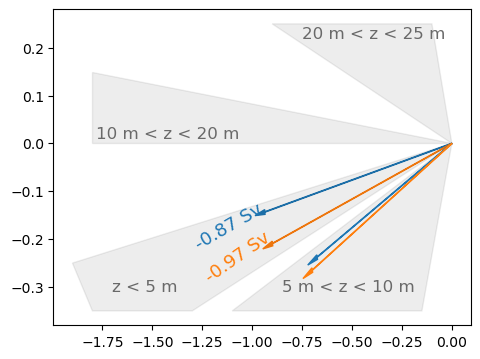

In [110]:
figure = plt.figure(num = 1, figsize = (12, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)

#creating polygons 

#5m polygons
MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.8,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)
MOM6_5m_poly = Polygon([(0,0), (-2,-.3),(-1.8,-.3), (-1.9,-.12)],color='black',edgecolor=None,alpha=0.07)

#10m polygons
MOM5_10m_poly = Polygon([(-1.1,-.35), (0,0),(-.15,-.35), (-1,-.35)],color='black',edgecolor=None,alpha=0.07)
MOM6_10m_poly = Polygon([(-2.1,-.35), (0,0),(-1.15,-.35), (-2.1,-.35)],color='black',edgecolor=None,alpha=0.07)

#20m polygons
MOM5_20m_poly = Polygon([(0,0), (-1.8,0),(-1.8,0.15), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_20m_poly = Polygon([(0,0), (-1.8,0),(-1.8,0.15), (0,0)],color='black',edgecolor=None,alpha=0.07)

#25m polygons
MOM5_25m_poly = Polygon([(0,0), (-.9,.25),(-.1,0.25), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_25m_poly = Polygon([(0,0), (-.9,.25),(-.1,0.25), (0,0)],color='black',edgecolor=None,alpha=0.07)

ax5 = plt.subplot(325)

### top 5m 


plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
          V_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')
plt.text(-1.3,-.22,str(Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
         rotation = 30,fontsize=13)

plt.arrow(0,0,U_transport_5m.isel(st_ocean=0)/1e6,V_transport_5m.isel(st_ocean=0)/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:orange')

plt.text(-1.25,-.29,str(Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
         rotation = 35,fontsize=13)

ax5.add_patch(MOM5_5m_poly)
plt.text(-1.7, -0.31,r'z < 5 m ',color='dimgray',fontsize=12)

ax5.add_patch(MOM5_10m_poly)
plt.text(-.85, -0.31,r'5 m < z < 10 m ',color='dimgray',fontsize=12)

ax5.add_patch(MOM5_20m_poly)
plt.text(-1.78, 0.01,r'10 m < z < 20 m ',color='dimgray',fontsize=12)

ax5.add_patch(MOM5_25m_poly )
plt.text(-.75, 0.22,r'20 m < z < 25 m ',color='dimgray',fontsize=12)

# 5 to 10 m
depth_slice_5to10 = slice(5,10)
plt.arrow(0,0,U_transport_1m.sel(st_ocean=depth_slice_5to10).sum('st_ocean')/1e6,\
          V_transport_1m.sel(st_ocean=depth_slice_5to10).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

plt.arrow(0,0,U_transport_5m.sel(st_ocean=depth_slice_5to10).sum('st_ocean')/1e6,\
          V_transport_5m.sel(st_ocean=depth_slice_5to10).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:orange')



# # 10 to 20 m
# depth_slice_10to20 = slice(10,20)
# plt.arrow(0,0,U_transport_1m.sel(st_ocean=depth_slice_10to20).sum('st_ocean')/1e6,\
#           V_transport_1m.sel(st_ocean=depth_slice_10to20).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.arrow(0,0,U_transport_5m.sel(st_ocean=depth_slice_10to20).sum('st_ocean')/1e6,\
#           V_transport_5m.sel(st_ocean=depth_slice_10to20).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')


# plt.yticks(fontsize=13);
# plt.xticks(fontsize=13);
# plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
# plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
# plt.xlim(-1.4,.5)
# plt.ylim(-.3,.1)

# # 20 to 25 m
# depth_slice_20to25 = slice(20,25)
# plt.arrow(0,0,U_transport_1m.sel(st_ocean=depth_slice_20to25).sum('st_ocean')/1e6,\
#           V_transport_1m.sel(st_ocean=depth_slice_20to25).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.arrow(0,0,U_transport_5m.sel(st_ocean=depth_slice_20to25).sum('st_ocean')/1e6,\
#           V_transport_5m.sel(st_ocean=depth_slice_20to25).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')



# plt.yticks(fontsize=13);
# plt.xticks(fontsize=13);
# plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
# plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
# plt.xlim(-1.8,.1)
# plt.ylim(-.32,.25)
# plt.title('[e] Surface transports',fontsize=14)


# ax6 = plt.subplot(326)
# ### top 5m 
# plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
#           MOM6_V_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.text(-1.63,-.19,str(MOM6_Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
#          rotation = 25,fontsize=13)

# plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=0)/1e6,MOM6_V_transport_5m.isel(z_l=0)/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')

# plt.text(-1.58,-.225,str(MOM6_Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
#          rotation = 23,fontsize=13)

# ax6.add_patch(MOM6_5m_poly)
# plt.text(-1.78, -0.25,r'z < 5 m ',color='dimgray',fontsize=12,  rotation= -90)

# ax6.add_patch(MOM6_10m_poly)
# plt.text(-1.71, -0.315,r'5 m < z < 10 m ',color='dimgray',fontsize=12)

# ax6.add_patch(MOM6_20m_poly)
# plt.text(-1.78, 0.01,r'10 m < z < 20 m ',color='dimgray',fontsize=12)

# ax6.add_patch(MOM6_25m_poly)
# plt.text(-.75, 0.22,r'20 m < z < 25 m ',color='dimgray',fontsize=12)

# # 5 to 10 m
# plt.arrow(0,0,MOM6_U_transport_1m.sel(z_l=depth_slice_5to10).sum('z_l')/1e6,\
#           MOM6_V_transport_1m.sel(z_l=depth_slice_5to10).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.arrow(0,0,MOM6_U_transport_5m.sel(z_l=depth_slice_5to10).sum('z_l')/1e6,\
#           MOM6_V_transport_5m.sel(z_l=depth_slice_5to10).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')

# # 10 to 20 m
# plt.arrow(0,0,MOM6_U_transport_1m.sel(z_l=depth_slice_10to20).sum('z_l')/1e6,\
#           MOM6_V_transport_1m.sel(z_l=depth_slice_10to20).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.arrow(0,0,MOM6_U_transport_5m.sel(z_l=depth_slice_10to20).sum('z_l')/1e6,\
#           MOM6_V_transport_5m.sel(z_l=depth_slice_10to20).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')

# # 20 to 25 m
# plt.arrow(0,0,MOM6_U_transport_1m.sel(z_l=depth_slice_20to25).sum('z_l')/1e6,\
#           MOM6_V_transport_1m.sel(z_l=depth_slice_20to25).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.arrow(0,0,MOM6_U_transport_5m.sel(z_l=depth_slice_20to25).sum('z_l')/1e6,\
#           MOM6_V_transport_5m.sel(z_l=depth_slice_20to25).sum('z_l')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')


# plt.title('[f] Surface transports',fontsize=14)

# plt.yticks(fontsize=13);
# plt.xticks(fontsize=13);
# plt.xlim(-1.8,.1)
# plt.ylim(-.32,.25)
# plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
# plt.ylabel( r'Meridional transport  [$Sv$]', fontsize=16)

In the plot above, it would be good to have the values of the wind speeds along the siobath, averages

In [111]:
sw_ocean_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'sw_ocean', session, n=1,chunks = {}).\
sel(sw_ocean=slice(0,20))
sw_ocean_1m 

<xarray.DataArray 'sw_ocean' (sw_ocean: 10)> Size: 80B
array([ 1.082562,  2.278908,  3.600997,  5.062046,  6.676655,  8.460964,
       10.432805, 12.611883, 15.019973, 17.681133])
Coordinates:
  * sw_ocean  (sw_ocean) float64 80B 1.083 2.279 3.601 ... 12.61 15.02 17.68
Attributes:
    long_name:       ucell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           sw_edges_ocean
    ncfiles:         ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9...

Can you identify the bottom of the Ekman layer by the directions of the transports?

In [112]:
# figure = plt.figure(num = 1, figsize = (10, 5))

# nn=7

# plt.subplot(1,2,1)
# for n in range(nn):
#     plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               V_transport_1m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='tab:blue')
# print (str(U_transport_1m.isel(st_ocean=n)))

# plt.subplot(1,2,2)
# for n in range(nn-3):
#     plt.arrow(0,0,U_transport_5m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               V_transport_5m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='tab:orange')
# print (str(U_transport_5m.isel(st_ocean=n)))

In [113]:
# figure = plt.figure(num = 1, figsize = (10, 5))
# nn=7
# for n in range(nn):
#     plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               V_transport_1m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='tab:blue')
# print (str(U_transport_1m.isel(st_ocean=n)))
# for n in range(nn-3):
#     plt.arrow(0,0,U_transport_5m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               V_transport_5m.isel(st_ocean=slice(0,n+1)).sum('st_ocean')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='tab:orange')
# print (str(U_transport_5m.isel(st_ocean=n)))

Below 9.5 meters it seems to me that the transports change direction, with I will take as proxy for the end of the Ekman Layer in MOM5

In [114]:
MOM5_lat = ((𝜏x_MOM5_1m* 0)+1)* 𝜏x_MOM5_1m.yu_ocean

In [115]:
from gsw import f as fcorr
f_MOM5 = fcorr(MOM5_lat)

taumag_MOM5 = ((𝜏x_MOM5_1m)**2 + (𝜏y_MOM5_1m)**2)**0.5

taux_mag_MOM5 = ((𝜏x_MOM5_1m)**2 )**0.5
tauy_mag_MOM5 = ((𝜏y_MOM5_1m)**2 )**0.5

Dek_MOM5 =  (taumag_MOM5/(1035 * ((f_MOM5)**2)))**(1/3)
Dek_MOM5_x =  (taux_mag_MOM5 /(1035 * ((f_MOM5)**2)))**(1/3)
Dek_MOM5_y =  (tauy_mag_MOM5 /(1035 * ((f_MOM5)**2)))**(1/3)
# #mask the shelf
# Dek_MOM5_shelf=Dek_MOM5.where(shelf_mask==1)

In [116]:
# figure = plt.figure(num = 1, figsize = (12, 5))

# #σ2_ref=37.18
# Dek_MOM5.plot(vmin=5,vmax=20)
# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'snow', linewidth=.7)

# plt.ylim(-80,-62)

What about in MOM6?

In [117]:
# figure = plt.figure(num = 1, figsize = (10, 5))
# nn=8

# plt.subplot(1,2,1)
# for n in range(nn):
#     plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               MOM6_V_transport_1m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='tab:blue')
# print (str(MOM6_U_transport_1m.isel(z_l=n)))


# plt.subplot(1,2,2)
# for n in range(nn-3):
#     plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               MOM6_V_transport_5m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='orange')
# print (str(MOM6_U_transport_5m.isel(z_l=n)))

In [118]:
# figure = plt.figure(num = 1, figsize = (10, 5))
# nn=13

# for n in range(nn):
#     plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               MOM6_V_transport_1m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='tab:blue')
# print (str(MOM6_U_transport_1m.isel(z_l=n)))
# for n in range(nn-3):
#     plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               MOM6_V_transport_5m.isel(z_l=slice(0,n+1)).sum('z_l')/1e6,\
#               head_width=1e-2,head_length=5e-2,color='orange')
# print (str(MOM6_U_transport_5m.isel(z_l=n)))

In [119]:
MOM6_V_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6

<xarray.DataArray ()> Size: 8B
array(-0.13312013)

In [120]:
(V_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6) - V_transport_5m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6

<xarray.DataArray ()> Size: 8B
array(0.06583998)

In [121]:
vol_trans_across_contour_1m.cumsum()/1e6

<xarray.DataArray (st_ocean: 18)> Size: 72B
array([-0.12842982, -0.32717285, -0.57480824, -0.86520743, -1.1943412 ,
       -1.5547687 , -1.9365137 , -2.3263679 , -2.7059114 , -3.0627153 ,
       -3.389196  , -3.6790273 , -3.9236581 , -4.127576  , -4.3008947 ,
       -4.4537606 , -4.5884056 , -4.7019973 ], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 144B 0.5413 1.681 2.94 ... 38.24 43.34 48.98

In [122]:
vol_trans_across_contour_5m.cumsum()/1e6

<xarray.DataArray (st_ocean: 15)> Size: 60B
array([-0.9660925, -1.3047385, -1.6799219, -2.0803432, -2.490022 ,
       -2.8859673, -3.2535317, -3.5866356, -3.8744328, -4.109648 ,
       -4.3031964, -4.4682593, -4.609747 , -4.7279124, -4.8247766],
      dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 120B 2.531 5.869 7.569 ... 38.24 43.34 48.98

In [123]:
#on the first 5m
dzt_MOM5_1m.load()

MOM5_1m_Voltume_cells = (dzt_MOM5_1m*area_t).sel(yt_ocean=offshore_lat_limit)
MOM5_1m_Voltume_cells_total=MOM5_1m_Voltume_cells.sum()
shelf_volume_MOM5_5m_cumsum = (MOM5_1m_Voltume_cells*shelf_mask).isel(st_ocean=slice(0,4)).sum(('xt_ocean','yt_ocean')).cumsum()
shelf_volume_MOM5_5m = (MOM5_1m_Voltume_cells*shelf_mask).isel(st_ocean=slice(0,4)).sum(('xt_ocean','yt_ocean'))


offshore_volume_MOM5_5m = (MOM5_1m_Voltume_cells).isel(st_ocean=slice(0,4)).sum(('xt_ocean','yt_ocean')) - shelf_volume_MOM5_5m 
offshore_volume_MOM5_5m_cumsum = offshore_volume_MOM5_5m.cumsum()
offshore_volume_MOM5_5m_cumsum

<xarray.DataArray (st_ocean: 4)> Size: 16B
array([6.4280645e+12, 1.3531765e+13, 2.1382107e+13, 3.0057559e+13],
      dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 32B 0.5413 1.681 2.94 4.332

In [124]:
MOM5_1m_Voltume_cells_total

<xarray.DataArray ()> Size: 4B
array(4.3113197e+14, dtype=float32)

In [125]:
S_MOM5_1m_offshoremean_day0

<xarray.DataArray 'salt' (st_ocean: 75)> Size: 300B
array([33.857403, 33.85784 , 33.85821 , 33.858746, 33.859486, 33.86059 ,
       33.86201 , 33.86413 , 33.8682  , 33.8762  , 33.889454, 33.908875,
       33.936935, 33.970688, 34.00596 , 34.043777, 34.080563, 34.113617,
       34.14202 , 34.169605, 34.197807, 34.227104, 34.258423, 34.293472,
       34.330627, 34.36911 , 34.411842, 34.4527  , 34.489742, 34.526688,
       34.55682 , 34.580475, 34.60241 , 34.622288, 34.639915, 34.65439 ,
       34.666122, 34.675716, 34.683136, 34.68901 , 34.69369 , 34.697838,
       34.70127 , 34.70374 , 34.704956, 34.70534 , 34.704994, 34.704216,
       34.70297 , 34.70142 , 34.699768, 34.69822 , 34.696438, 34.694855,
       34.693314, 34.692123, 34.690895, 34.689854, 34.6887  , 34.68781 ,
       34.687347, 34.686764, 34.68602 , 34.68527 , 34.68434 , 34.683716,
       34.682922, 34.680138, 34.67303 , 34.667114, 34.65641 , 34.653786,
             nan,       nan,       nan], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [126]:
(S_MOM5_1m_shelfmean_day0.weighted(shelf_volume_MOM5_5m_cumsum).mean())

<xarray.DataArray 'salt' ()> Size: 4B
array(33.81503, dtype=float32)

In [127]:
vol_trans_across_contour_1m

<xarray.DataArray (st_ocean: 18)> Size: 72B
array([-128429.81, -198743.03, -247635.39, -290399.2 , -329133.66,
       -360427.5 , -381745.  , -389854.22, -379543.8 , -356803.7 ,
       -326480.75, -289831.16, -244630.9 , -203917.58, -173318.83,
       -152865.86, -134645.17, -113591.93], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 144B 0.5413 1.681 2.94 ... 38.24 43.34 48.98

In [128]:
#predicted change in salinity, respecting the salinity gradient
#(S_MOM5_1m_shelfmean_day0.weighted(shelf_volume_MOM5_5m_cumsum).mean())  - \


rate_change_with_Sgradient = ((S_MOM5_1m_offshoremean_day0 * -vol_trans_across_contour_1m / offshore_volume_MOM5_5m).sum())  #PSU/s being transported to the shelf when resolving the Salinity gradient

mean_shelf_salinity = (S_MOM5_1m_shelfmean_day0.weighted(shelf_volume_MOM5_5m).mean())
mean_offshore_salinity = (S_MOM5_1m_offshoremean_day0.weighted(offshore_volume_MOM5_5m).mean())

rate_change_without_Sgradient = ((mean_offshore_salinity * -vol_trans_across_contour_1m / offshore_volume_MOM5_5m).sum())   #PSU/s being transported to the shelf when not resolving the salinity gradient


rate_change_without_Tgradient = ((mean_offshore_salinity* -vol_trans_across_contour_1m.isel(st_ocean=slice(0,4)).sum() / offshore_volume_MOM5_5m).sum())    #PSU/s being transported to the shelf when not resolving the transport gradient


rate_change_with_Sgradient,rate_change_without_Sgradient,rate_change_without_Tgradient




(<xarray.DataArray ()> Size: 4B
 array(3.825128e-06, dtype=float32),
 <xarray.DataArray ()> Size: 4B
 array(3.825124e-06, dtype=float32),
 <xarray.DataArray ()> Size: 4B
 array(1.5789334e-05, dtype=float32))

In [129]:
(rate_change_with_Sgradient - rate_change_without_Tgradient)*(60*60*24)

<xarray.DataArray ()> Size: 8B
array(-1.03370743)

In [130]:
# figure = plt.figure(num = 1, figsize = (12, 16))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.3,
#                     hspace=0.5)


# ax5 = plt.subplot(325)


# #5m polygons
# MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.9,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)
# MOM6_5m_poly = Polygon([(0,0), (-1.5,-.35),(-1.9,-.35), (-1.9,-.18)],color='black',edgecolor=None,alpha=0.07)

# #3 cells polygons (3.6 m)
# MOM5_3m_poly = Polygon([(0,0), (-1.9,-.23),(-1.9,-.15), (0,0)],color='black',edgecolor=None,alpha=0.07)
# MOM6_3m_poly = Polygon([(0,0), (-1.9,-.16),(-1.9,-.1), (0,0)],color='black',edgecolor=None,alpha=0.07)

# #2 cells polygons (2.3 m)
# MOM5_2m_poly = Polygon([(0,0), (-1.9,-.13),(-1.9,-.03), (0,0)],color='black',edgecolor=None,alpha=0.07)
# MOM6_2m_poly = Polygon([(0,0), (-1.9,-.08),(-1.9,0), (0,0)],color='black',edgecolor=None,alpha=0.07)

# #1 cell polygons (1.1 m)
# MOM5_1m_poly = Polygon([(0,0), (-1.9,-.02),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)
# MOM6_1m_poly = Polygon([(0,0), (-1.9,0.01),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)

# ### first cell  1mtop
# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue',label='1mtop, relative winds')
# plt.arrow(0,0,U_transport_1m_abs.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           V_transport_1m_abs.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='deepskyblue',label='1mtop, absolute winds')
# ##### upper 2 cells 1mtop
# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# plt.arrow(0,0,U_transport_1m_abs.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           V_transport_1m_abs.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='deepskyblue')
# ##### upper 3 cells 1mtop
# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# plt.arrow(0,0,U_transport_1m_abs.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           V_transport_1m_abs.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='deepskyblue')



# ### top 5m 

# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# plt.arrow(0,0,U_transport_1m_abs.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           V_transport_1m_abs.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='deepskyblue')

# #plt.text(-1.33,-.19,str(Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
# #         rotation = 29,fontsize=13)

# plt.arrow(0,0,U_transport_5m.isel(st_ocean=0)/1e6,V_transport_5m.isel(st_ocean=0)/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange',label='5mtop, relative winds')

# plt.arrow(0,0,U_transport_5m_abs.isel(st_ocean=0)/1e6,V_transport_5m_abs.isel(st_ocean=0)/1e6,\
#           head_width=1e-2,head_length=5e-2,color='olivedrab',label='5mtop, absolute winds')
# #plt.text(-1.27,-.27,str(Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
# #         rotation = 34,fontsize=13)

# ax5.add_patch(MOM5_5m_poly)
# plt.text(-1.88, -0.26,r'z < 5.1 m ',rotation=29,  color='dimgray',fontsize=12)


# ax5.add_patch(MOM5_3m_poly)
# plt.text(-1.88, -0.17,r'z < 3.6 m ',rotation=23,  color='dimgray',fontsize=12)

# ax5.add_patch(MOM5_2m_poly)
# plt.text(-1.88, -0.05,r'z < 2.3 m ',rotation=3,  color='dimgray',fontsize=12)

# ax5.add_patch(MOM5_1m_poly)
# plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

# plt.yticks(fontsize=13);
# plt.xticks(ticks=[-1.8, -1.5, -1.2, -0.9, -0.6, -0.3, 0 ],fontsize=13);
# plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
# plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
# plt.xlim(-1.9,.1)
# plt.ylim(-.3,.05)
# plt.title('Surface transports \n \n' + r'$\tau_x\ =$ ' + str(np.round(MOM5_𝜏xmean_1m.values,3)) +\
#           r' $N\ m^{-2}$, $\tau_y\ =$' + str(np.round(MOM5_𝜏ymean_1m.values,3)) + r' $N\ m^{-2}$',fontsize=14)



# plt.legend()

In [131]:
# S_MOM5_1m_fulldepth.isel(st_ocean=0).plot(vmin=33.5,vmax=34.2)
# plt.grid()
# plt.plot([-280,80],[-67,-67])

In [132]:
# S_MOM6_1m_fulldepth.isel(z_l=0).plot(vmin=33.5,vmax=34.2)
# plt.grid()
# plt.plot([-280,80],[-67,-67])

In [133]:
# #on the shelf
# S_MOM5_1m_shelfmean_day0 = S_MOM5_1m_fulldepth.where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
# .mean(('xt_ocean','yt_ocean')).load()
# S_MOM5_5m_shelfmean_day0 = S_MOM5_5m_fulldepth.where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
# .mean(('xt_ocean','yt_ocean')).load()

# ## We will impose a nirthward limit of 60S into the offshore mean salinity
# offshore_lat_limit=slice(-90,-66.5)
# #off the shelf
# S_MOM5_1m_offshoremean_day0 = S_MOM5_1m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
# .where(shelf_mask==0).weighted(area_t.fillna(0))\
# .mean(('xt_ocean','yt_ocean')).load()
# S_MOM5_5m_offshoremean_day0 = S_MOM5_5m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
# .where(shelf_mask==0).weighted(area_t.fillna(0))\
# .mean(('xt_ocean','yt_ocean')).load()


In [134]:
#on the shelf, except the Antarctic peninsula
S_MOM5_1m_shelfmean_day0 = S_MOM5_1m_fulldepth.where((S_MOM5_1m_fulldepth.xt_ocean> -50)|(S_MOM5_1m_fulldepth.xt_ocean< -100)).where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_shelfmean_day0 = S_MOM5_5m_fulldepth.where((S_MOM5_5m_fulldepth.xt_ocean> -50)|(S_MOM5_5m_fulldepth.xt_ocean< -100)).where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()

## We will impose a nirthward limit of 60S into the offshore mean salinity
offshore_lat_limit=slice(-90,-66.5)
#off the shelf
S_MOM5_1m_offshoremean_day0 = S_MOM5_1m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(shelf_mask==0).weighted(area_t.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_offshoremean_day0 = S_MOM5_5m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(shelf_mask==0).weighted(area_t.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()


In [135]:
# #on the shelf
# S_MOM6_1m_shelfmean_day0 = S_MOM6_1m_fulldepth.where(shelf_mask_MOM6==1).\
# weighted(areacello_shelf.fillna(0)).mean(('xh','yh')).load()

# S_MOM6_5m_shelfmean_day0 = S_MOM6_5m_fulldepth.where(shelf_mask_MOM6==1).\
# weighted(areacello_shelf.fillna(0)).mean(('xh','yh')).load()


# #off the shelf
# S_MOM6_1m_offshoremean_day0 = S_MOM6_1m_fulldepth.sel(yh=offshore_lat_limit)\
# .where(shelf_mask_MOM6==0).\
# weighted(areacello.fillna(0)).mean(('xh','yh')).load()

# S_MOM6_5m_offshoremean_day0 = S_MOM6_5m_fulldepth.sel(yh=offshore_lat_limit)\
# .where(shelf_mask_MOM6==0).\
# weighted(areacello.fillna(0)).mean(('xh','yh')).load()

In [136]:
# (S_MOM6_5m_fulldepth.where((S_MOM6_5m_fulldepth.xh > -50)|(S_MOM6_5m_fulldepth.xh < -100)).isel(z_l=0) -\
#  S_MOM6_1m_fulldepth.where((S_MOM6_1m_fulldepth.xh > -50)|(S_MOM6_1m_fulldepth.xh < -100)).isel(z_l=0) ).plot(vmin=-0.01,vmax=0.01,cmap = 'seismic')

In [137]:
#on the shelf, reoving the Antarctic peninsula
S_MOM6_1m_shelfmean_day0 = S_MOM6_1m_fulldepth.where((S_MOM6_1m_fulldepth.xh > -60)|(S_MOM6_1m_fulldepth.xh < -100)).where(shelf_mask_MOM6==1).\
weighted(areacello_shelf.fillna(0)).mean(('xh','yh')).load()

S_MOM6_5m_shelfmean_day0 = S_MOM6_5m_fulldepth.where((S_MOM6_5m_fulldepth.xh > -60)|(S_MOM6_5m_fulldepth.xh < -100)).where(shelf_mask_MOM6==1).\
weighted(areacello_shelf.fillna(0)).mean(('xh','yh')).load()


#off the shelf
S_MOM6_1m_offshoremean_day0 = S_MOM6_1m_fulldepth.sel(yh=offshore_lat_limit)\
.where(shelf_mask_MOM6==0).\
weighted(areacello.fillna(0)).mean(('xh','yh')).load()

S_MOM6_5m_offshoremean_day0 = S_MOM6_5m_fulldepth.sel(yh=offshore_lat_limit)\
.where(shelf_mask_MOM6==0).\
weighted(areacello.fillna(0)).mean(('xh','yh')).load()

In [138]:
# S_MOM6_1m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:blue')
# S_MOM6_5m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:orange')

# S_MOM6_1m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:blue')
# S_MOM6_5m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:orange')

# plt.ylim(8,0)
# plt.xlim(33.9,34)


In [139]:
# S_MOM5_1m_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:blue')
# S_MOM5_5m_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:orange')

# S_MOM5_1m_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:blue')
# S_MOM5_5m_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:orange')

# plt.ylim(8,0)
# plt.xlim(33.8,33.95)

In [140]:
# S_MOM6_1m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:blue')
# S_MOM6_5m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:orange')

# S_MOM6_1m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:blue')
# S_MOM6_5m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:orange')

# plt.ylim(8,0)
# plt.xlim(33.9,34.1)

Text(0, 0.5, 'Meridional transport  [$Sv$]')

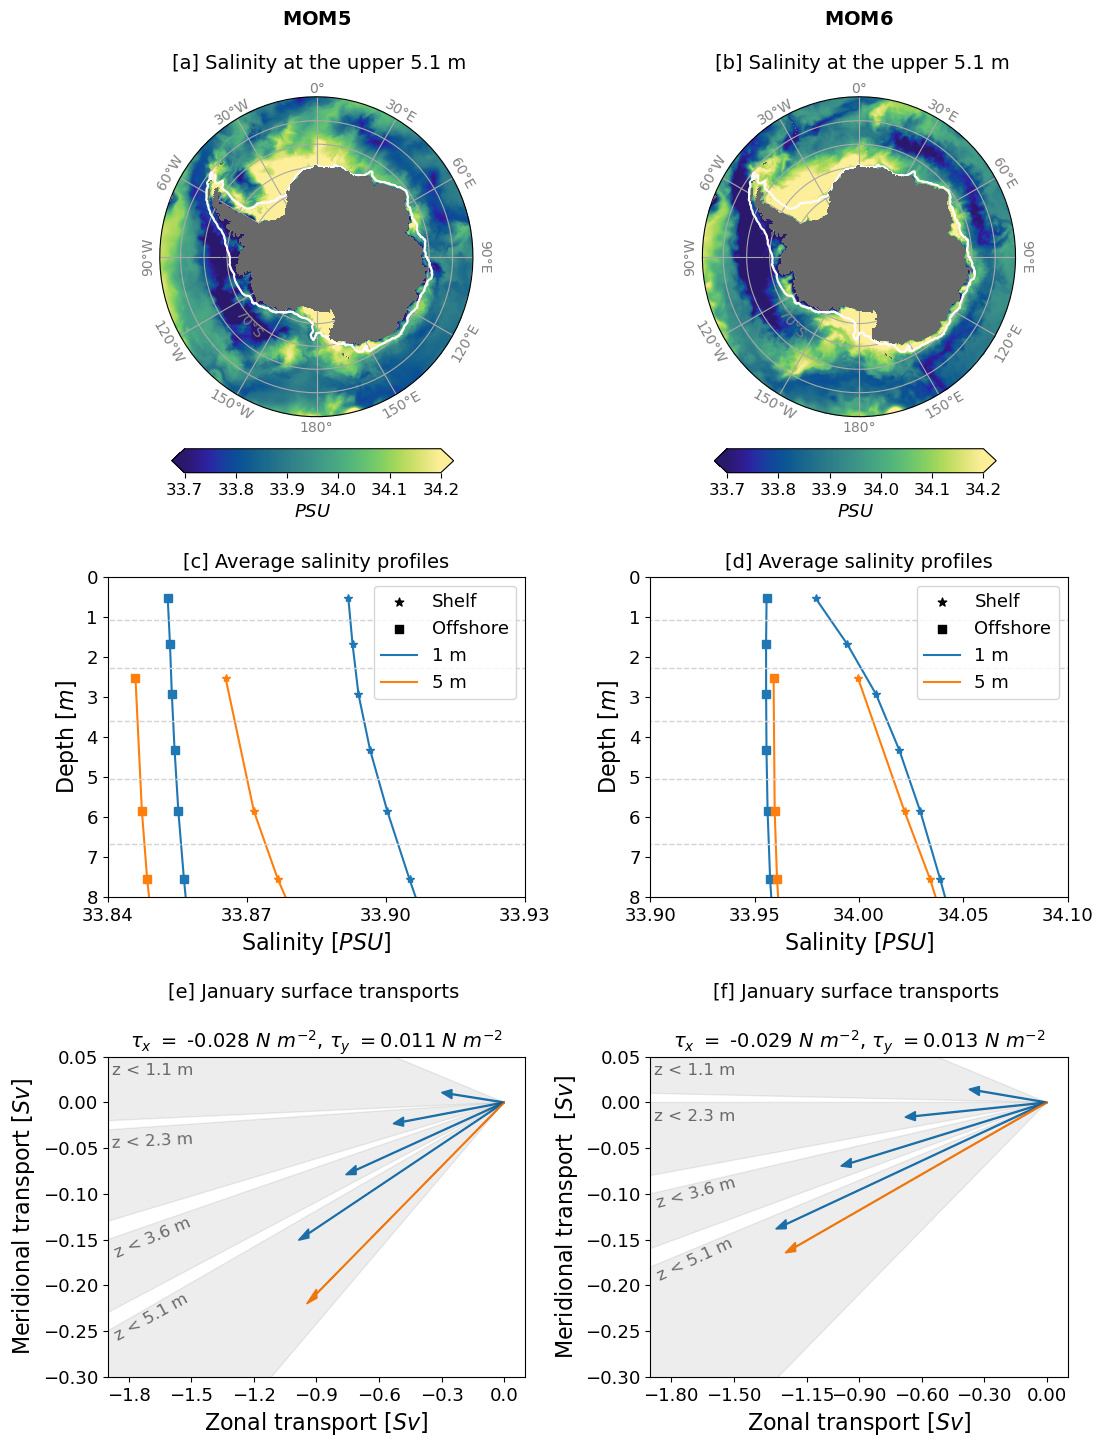

In [141]:
from functools import partial

figure = plt.figure(num = 1, figsize = (12, 16))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.5)



#maps WIth Jan Salinity in MOM5 ##########################################################################
proj = ccrs.PlateCarree()
ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax325.set_extent([-180, 180, -90, -55], proj)
ax325.set_boundary(circle, transform=ax325.transAxes)

gl = ax325.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                 -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)



ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'snow', linewidth=.7,
            transform=proj,)




p325 = ax325.pcolormesh(S_MOM5_1m_20m_mean.xt_ocean, S_MOM5_1m_20m_mean.yt_ocean,
                   S_MOM5_1m_20m_mean,\
                        vmin=33.7,vmax=34.2,cmap = cmo.haline
                   , transform=proj,
                   rasterized=True, zorder=1)






cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)






ax325.set_title(r"$\bf{MOM5}$" + '\n \n [a] Salinity at the upper 5.1 m', pad=20, fontsize=14)

pos = ax325.get_position()


cax_0T = plt.axes([pos.xmin+0.01, pos.ymin-0.035,
                .9*(pos.xmax-pos.xmin), 0.015])

cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax_0T, extend='both')
cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel(r'$PSU$',fontsize=13)





#maps WIth Jan Salinity in MOM6 ##############################################################
proj = ccrs.PlateCarree()
ax326 = plt.subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax326.set_extent([-180, 180, -90, -55], proj)
ax326.set_boundary(circle, transform=ax326.transAxes)

gl = ax326.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                 -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)



ax326.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'snow', linewidth=.7,
            transform=proj,)




p326 = ax326.pcolormesh(S_MOM6_1m_20m_mean.xh, S_MOM6_1m_20m_mean.yh,
                   S_MOM6_1m_20m_mean,\
                        vmin=33.7,vmax=34.2,cmap = cmo.haline
                   , transform=proj,
                   rasterized=True, zorder=1)






cb326.ax.tick_params(labelsize=12)
cb326.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)






ax326.set_title(r"$\bf{MOM6}$" + '\n \n [b] Salinity at the upper 5.1 m', pad=20, fontsize=14)

pos_2 = ax326.get_position()

cax_0T2 = plt.axes([pos_2.xmin+0.01, pos_2.ymin-0.035,
                .9*(pos_2.xmax-pos_2.xmin), 0.015])


cb326 = plt.colorbar(p326, orientation='horizontal',cax = cax_0T2, extend='both')
cb326.ax.tick_params(labelsize=12)
cb326.ax.set_xlabel(r'$PSU$',fontsize=13)






### plots of mean salinity on and off shelf

plt.subplot(3,2,3)

S_MOM5_1m_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:blue')
S_MOM5_5m_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:orange')


S_MOM5_1m_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:blue')
S_MOM5_5m_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:orange')

plt.scatter([0,0],[0,0],color='black',marker='*', s=40, label = 'Shelf')
plt.scatter([0,0],[0,0],color='black',marker='s', s=40, label = 'Offshore')
plt.plot([0,0],[0,0],color='tab:blue', label = '1 m')
plt.plot([0,0],[0,0],color='tab:orange', label = '5 m')

for n in range(6):
    plt.plot([33,34],[sw_ocean_1m[n], sw_ocean_1m[n]],color='lightgrey',linestyle='--',linewidth=1)

#plt.xticks(ticks = [33.60, 33.65,33.70,33.75,33.8,33.85,33.9,33.95,34,34.05,34.1,34.15], fontsize=13);
plt.xticks(ticks = [33.84,33.87,33.9,33.93], fontsize=13);
plt.ylim(8,0)
plt.xlim(33.84,33.93)#33.75,33.83
#plt.xlim(33.78,33.9)
plt.legend()
plt.xlabel(r'Salinity [$PSU$]', fontsize = 16)
plt.ylabel( r'Depth [$m$]', fontsize=16)
plt.legend(fontsize=13)
plt.title('[c] Average salinity profiles',fontsize=14)
plt.yticks(fontsize=13);



plt.subplot(3,2,4)
S_MOM6_1m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:blue')
S_MOM6_5m_shelfmean_day0.plot(y='z_l',marker='*',color='tab:orange')

S_MOM6_1m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:blue')
S_MOM6_5m_offshoremean_day0.plot(y='z_l',marker='s',color='tab:orange')


plt.scatter([0,0],[0,0],color='black',marker='*', s=40, label = 'Shelf')
plt.scatter([0,0],[0,0],color='black',marker='s', s=40, label = 'Offshore')
plt.plot([0,0],[0,0],color='tab:blue', label = '1 m')
plt.plot([0,0],[0,0],color='tab:orange', label = '5 m')

for n in range(6):
    plt.plot([33,35],[sw_ocean_1m[n], sw_ocean_1m[n]],color='lightgrey',linestyle='--',linewidth=1)

plt.xticks(ticks= [33.60,33.65,33.7,33.75,33.8,33.85,33.9,33.95,34,34.05,34.1,34.15], fontsize=13);
plt.ylim(8,0)
plt.xlim(33.9,34.1)
#plt.xlim(34.255,34.2555)
plt.legend()
plt.xlabel(r'Salinity [$PSU$]', fontsize = 16)
plt.ylabel( r'Depth [$m$]', fontsize=16)
plt.legend(fontsize=13)
plt.title('[d] Average salinity profiles',fontsize=14)
plt.yticks(fontsize=13);












### plots of mean transport, along the 1 KM isobath, in the top 10 m of each simulation


#5m polygons
MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.9,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)
MOM6_5m_poly = Polygon([(0,0), (-1.5,-.35),(-1.9,-.35), (-1.9,-.18)],color='black',edgecolor=None,alpha=0.07)

#3 cells polygons (3.6 m)
MOM5_3m_poly = Polygon([(0,0), (-1.9,-.23),(-1.9,-.15), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_3m_poly = Polygon([(0,0), (-1.9,-.16),(-1.9,-.1), (0,0)],color='black',edgecolor=None,alpha=0.07)

#2 cells polygons (2.3 m)
MOM5_2m_poly = Polygon([(0,0), (-1.9,-.13),(-1.9,-.03), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_2m_poly = Polygon([(0,0), (-1.9,-.08),(-1.9,0), (0,0)],color='black',edgecolor=None,alpha=0.07)

#1 cell polygons (1.1 m)
MOM5_1m_poly = Polygon([(0,0), (-1.9,-.02),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_1m_poly = Polygon([(0,0), (-1.9,0.01),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)


################# MOM5 transports ###############################################


ax5 = plt.subplot(325)



### first cell  1mtop
plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
          V_transport_1m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')
##### upper 2 cells 1mtop
plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
          V_transport_1m.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')
##### upper 3 cells 1mtop
plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
          V_transport_1m.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')




### top 5m 

plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
          V_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')
#plt.text(-1.33,-.19,str(Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
#         rotation = 29,fontsize=13)

plt.arrow(0,0,U_transport_5m.isel(st_ocean=0)/1e6,V_transport_5m.isel(st_ocean=0)/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:orange')

#plt.text(-1.27,-.27,str(Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
#         rotation = 34,fontsize=13)

ax5.add_patch(MOM5_5m_poly)
plt.text(-1.88, -0.26,r'z < 5.1 m ',rotation=29,  color='dimgray',fontsize=12)


ax5.add_patch(MOM5_3m_poly)
plt.text(-1.88, -0.17,r'z < 3.6 m ',rotation=23,  color='dimgray',fontsize=12)

ax5.add_patch(MOM5_2m_poly)
plt.text(-1.88, -0.05,r'z < 2.3 m ',rotation=3,  color='dimgray',fontsize=12)

ax5.add_patch(MOM5_1m_poly)
plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

plt.yticks(fontsize=13);
plt.xticks(ticks=[-1.8, -1.5, -1.2, -0.9, -0.6, -0.3, 0 ],fontsize=13);
plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
plt.xlim(-1.9,.1)
plt.ylim(-.3,.05)
plt.title('[e] January surface transports \n \n' + r'$\tau_x\ =$ ' + str(np.round(MOM5_𝜏xmean_1m.values,3)) +\
          r' $N\ m^{-2}$, $\tau_y\ =$' + str(np.round(MOM5_𝜏ymean_1m.values,3)) + r' $N\ m^{-2}$',fontsize=14)





############ MOM6 transports ###########################
ax6 = plt.subplot(326)

### top cell
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

### top 2 cells
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

### top 3 cells
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

### top 5m 
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

# plt.text(-1.63,-.19,str(MOM6_Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
#          rotation = 25,fontsize=13)

plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=0)/1e6,MOM6_V_transport_5m.isel(z_l=0)/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:orange')

# plt.text(-1.58,-.225,str(MOM6_Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
#          rotation = 23,fontsize=13)

ax6.add_patch(MOM6_5m_poly)
plt.text(-1.88, -0.195,r'z < 5.1 m ',rotation=25,color='dimgray',fontsize=12)

ax6.add_patch(MOM6_3m_poly)
plt.text(-1.88, -0.115,r'z < 3.6 m ',rotation=15,color='dimgray',fontsize=12)

ax6.add_patch(MOM6_2m_poly)
plt.text(-1.88, -0.02,r'z < 2.3 m ',  color='dimgray',fontsize=12)


ax6.add_patch(MOM6_1m_poly)
plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

plt.title('[f] January surface transports \n \n' + r'$\tau_x\ =$ ' + str(np.round(MOM6_𝜏xmean_1m.values,3)) +\
          r' $N\ m^{-2}$, $\tau_y\ =$' + str(np.round(MOM6_𝜏ymean_1m.values,3)) + r' $N\ m^{-2}$',fontsize=14)

plt.yticks(fontsize=13);
plt.xticks(ticks=[-1.8, -1.5, -1.15, -0.9, -0.6, -0.3, 0 ],fontsize=13);
plt.xlim(-1.9,.1)
plt.ylim(-.3,.05)
plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
plt.ylabel( r'Meridional transport  [$Sv$]', fontsize=16)

# plt.savefig(figpath+'Rv0_Figure_6.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'Rv0_Figure_6.pdf',dpi=300,bbox_inches='tight')


The figure above shows that offshore waters are significantly fresher thanshelf waters. This means that an increase Sothward Ekman transport could bring more freshwaters into the shelf

Let's to a version of that plot with the transports from 5m to deeper into the EKman layer (i.e., about ~20 m) for the suplementarry material

# Figure S2

Text(0, 0.5, 'Meridional transport  [$Sv$]')

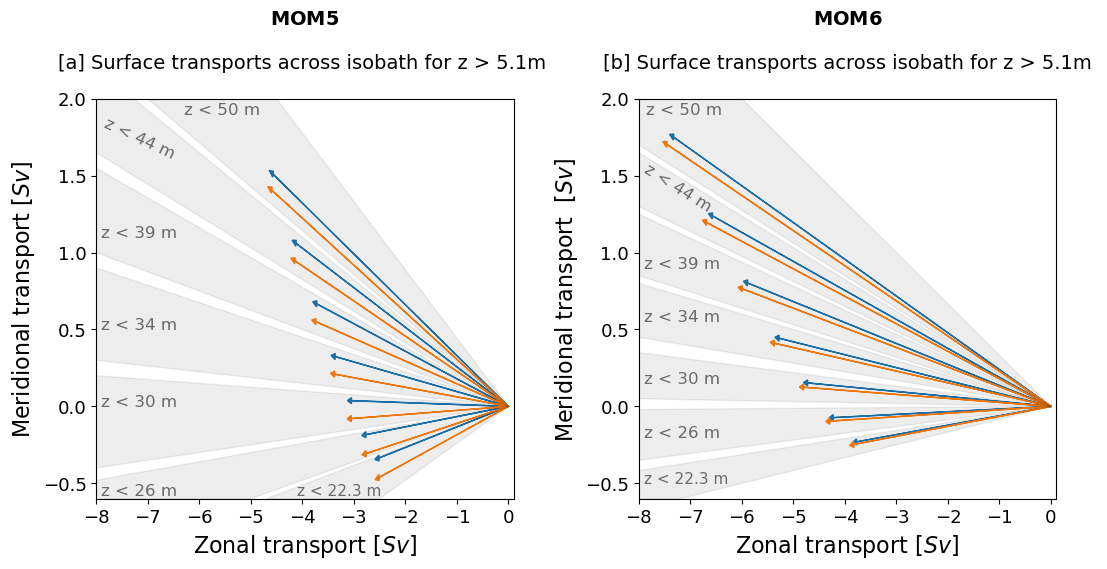

In [142]:
from functools import partial

figure = plt.figure(num = 1, figsize = (12, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.5)





#22m polygons
MOM5_22m_poly = Polygon([(0,0), (-2.5,-.6),(-4.7,-.6), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_22m_poly = Polygon([(0,0), (-7.2,-.6),(-11.5,-.6), (0,0)],color='black',edgecolor=None,alpha=0.07)

#26 cells polygons 
MOM5_26m_poly = Polygon([(0,0), (-5,-.6),(-10,-.6), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_26m_poly = Polygon([(0,0), (-8,-0.35),(-8, -.02), (0,0)],color='black',edgecolor=None,alpha=0.07)

#30 cells polygons 
MOM5_30m_poly = Polygon([(0,0), (-8,-.4),(-8,0.2), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_30m_poly = Polygon([(0,0), (-8,0.05),(-8,0.35), (0,0)],color='black',edgecolor=None,alpha=0.07)

#34 cell polygons 
MOM5_34m_poly = Polygon([(0,0), (-8,0.3),(-8,.9), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_34m_poly = Polygon([(0,0), (-8,0.45),(-8,.8), (0,0)],color='black',edgecolor=None,alpha=0.07)

#39 cell polygons 
MOM5_39m_poly = Polygon([(0,0), (-8,1),(-8,1.55), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_39m_poly = Polygon([(0,0), (-8,0.85),(-8,1.25), (0,0)],color='black',edgecolor=None,alpha=0.07)

#44 cell polygons 
MOM5_44m_poly = Polygon([(0,0), (-8,1.65),(-8,2.2), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_44m_poly = Polygon([(0,0), (-8,1.3),(-8,1.65), (0,0)],color='black',edgecolor=None,alpha=0.07)

#50 cell polygons 
MOM5_50m_poly = Polygon([(0,0), (-7,2),(-4.5,2), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_50m_poly = Polygon([(0,0), (-8,1.7),(-8,2), (-6,2),  (0,0)],color='black',edgecolor=None,alpha=0.07)

################# MOM5 transports ###############################################


ax5 = plt.subplot(121)





### below 5m
nn=11
nrage=7



for n in np.arange(nn,nn+nrage):
    plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,n)).sum('st_ocean')/1e6,\
              V_transport_1m.isel(st_ocean=slice(0,n)).sum('st_ocean')/1e6,\
              head_width=4e-2,head_length=8e-2,color='tab:blue')
    
    plt.arrow(0,0,U_transport_5m.isel(st_ocean=slice(0,n-3)).sum('st_ocean')/1e6,\
              V_transport_5m.isel(st_ocean=slice(0,n-3)).sum('st_ocean')/1e6,\
              head_width=4e-2,head_length=8e-2,color='tab:orange')




ax5.add_patch(MOM5_22m_poly)
plt.text(-4.1, -0.58,r'z < 22.3 m ',rotation=0,  color='dimgray',fontsize=11)

ax5.add_patch(MOM5_26m_poly)
plt.text(-7.9, -0.58,r'z < 26 m ',rotation=0,  color='dimgray',fontsize=12)

ax5.add_patch(MOM5_30m_poly)
plt.text(-7.9, 0,r'z < 30 m ',rotation=0,  color='dimgray',fontsize=12)

ax5.add_patch(MOM5_34m_poly)
plt.text(-7.9, 0.5,r'z < 34 m ',rotation=0,  color='dimgray',fontsize=12)


ax5.add_patch(MOM5_39m_poly)
plt.text(-7.9, 1.1,r'z < 39 m ',rotation=0,  color='dimgray',fontsize=12)

ax5.add_patch(MOM5_44m_poly)
plt.text(-7.9, 1.6,r'z < 44 m ',rotation=-25,  color='dimgray',fontsize=12)

ax5.add_patch(MOM5_50m_poly)
plt.text(-6.3, 1.9,r'z < 50 m ',rotation=0,  color='dimgray',fontsize=12)

plt.yticks(fontsize=13);
plt.xticks(ticks=[-8,-7,-6,-5,-4,-3,-2,-1,0 ],fontsize=13);
plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
plt.xlim(-8,.1)
plt.ylim(-.6,2)
plt.title(r'$\bf{MOM5}$' + '\n \n[a] Surface transports across isobath for z > 5.1m \n',fontsize=14)


############ MOM6 transports ###########################














ax6 = plt.subplot(122)



for n in np.arange(nn,nn+nrage):
    plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,n)).sum('z_l')/1e6,\
              MOM6_V_transport_1m.isel(z_l=slice(0,n)).sum('z_l')/1e6,\
              head_width=4e-2,head_length=8e-2,color='tab:blue')
    
    plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=slice(0,n-3)).sum('z_l')/1e6,\
              MOM6_V_transport_5m.isel(z_l=slice(0,n-3)).sum('z_l')/1e6,\
              head_width=4e-2,head_length=8e-2,color='tab:orange')

ax6.add_patch(MOM6_22m_poly)
plt.text(-7.9, -0.5,r'z < 22.3 m ',rotation=0,  color='dimgray',fontsize=11)

ax6.add_patch(MOM6_26m_poly)
plt.text(-7.9, -0.2,r'z < 26 m ',rotation=0,  color='dimgray',fontsize=12)

ax6.add_patch(MOM6_30m_poly)
plt.text(-7.9, 0.15,r'z < 30 m ',rotation=0,  color='dimgray',fontsize=12)


ax6.add_patch(MOM6_34m_poly)
plt.text(-7.9, 0.55 ,r'z < 34 m ',rotation=0,  color='dimgray',fontsize=12)


ax6.add_patch(MOM6_39m_poly)
plt.text(-7.9, 0.9 ,r'z < 39 m ',rotation=0,  color='dimgray',fontsize=12)

ax6.add_patch(MOM6_44m_poly)
plt.text(-7.95, 1.25 ,r'z < 44 m ',rotation=-32,  color='dimgray',fontsize=12)

ax6.add_patch(MOM6_50m_poly)
plt.text(-7.85, 1.9 ,r'z < 50 m ',rotation=-0,  color='dimgray',fontsize=12)

plt.title(r'$\bf{MOM6}$' + '\n \n [b] Surface transports across isobath for z > 5.1m \n',fontsize=14)


plt.yticks(fontsize=13);
plt.xticks(ticks=[-8,-7,-6,-5,-4,-3,-2,-1,0 ],fontsize=13);
plt.xlim(-8,.1)
plt.ylim(-.6,2)
plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
plt.ylabel( r'Meridional transport  [$Sv$]', fontsize=16)

# plt.savefig(figpath+'V10_Figure_S2.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'V10_Figure_S2.pdf',dpi=300,bbox_inches='tight')


____________________________
____________________________

# Figure 7

In [143]:
#### IMPORTING IT FOR THE FIRST YEAR
#Importing ocean surface boudnary layer in MOM5, OM2
ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht',session,n=1).fillna(0)
MLD_OM2_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'mld', \
                                 session, frequency = '1 monthly',chunks={"time":  '200MB'})\
.isel(time=slice(0,12)).sel(yt_ocean=lat_slice)

MLD_OM2_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'mld', \
                                 session, frequency = '1 monthly',chunks={"time":  '200MB'})\
.isel(time=slice(0,12)).sel(yt_ocean=lat_slice)



MLD_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'mlotst', session\
                                 ,frequency='1 monthly',chunks={"time":  '200MB'})\
.isel(time=slice(0,12)).sel(yh=lat_slice)

MLD_MOM6_5m  = cc.querying.getvar('mom6-panan', 'mlotst', temp_session\
                                  ,frequency='1 monthly',chunks= {"time":  '200MB'})\
.isel(time=slice(0,12)).sel(yh=lat_slice)

In [144]:
#creating a density mask. does that approach shows the locations of SWMT? for OM2
SWMT_mask_OM2 = swmt21mbath_shelf.sel(isopycnal_bins=σ0_ref,method='nearest').mean('time')
SWMT_mask_OM2 =((SWMT_mask_OM2.where(SWMT_mask_OM2 !=0)*0)+1).load()

In [145]:
SWMT_map_Panan = SHeat_1dz_shelf+ Ssalt_1dz_shelf 
SWMT_mask_Panan = SWMT_map_Panan.sel(isopycnal_bins=σ2_ref,method='nearest').mean('time')
SWMT_mask_Panan =((SWMT_mask_Panan.where(SWMT_mask_Panan !=0)*0)+1).load()

In [146]:
#masking off shelf MOM5
MLD_OM2_1m_shelf, shelf_map = shelf_mask_isobath_MOM5(MLD_OM2_1m)
MLD_OM2_5m_shelf, shelf_map = shelf_mask_isobath_MOM5(MLD_OM2_5m)

MLD_OM2_1m_shelf = MLD_OM2_1m_shelf*SWMT_mask_OM2 #masking off regions where we dont have SWMT
MLD_OM2_5m_shelf=MLD_OM2_5m_shelf*SWMT_mask_OM2 #masking off regions where we dont have SWMT
#masking the shelf MOM6
MLD_MOM6_1m_shelf = shelf_mask_isobathMOM6(MLD_MOM6_1m, 1000, '01', output_mask=False)
MLD_MOM6_1m_shelf = MLD_MOM6_1m_shelf.where(MLD_MOM6_1m_shelf>0)
MLD_MOM6_1m_shelf = MLD_MOM6_1m_shelf*SWMT_mask_Panan #masking off regions where we dont have SWMT
MLD_MOM6_5m_shelf = shelf_mask_isobathMOM6(MLD_MOM6_5m, 1000, '01', output_mask=False)
MLD_MOM6_5m_shelf = MLD_MOM6_5m_shelf.where(MLD_MOM6_5m_shelf>0)
MLD_MOM6_5m_shelf = MLD_MOM6_5m_shelf*SWMT_mask_Panan #masking off regions where we dont have SWMT

In [147]:
# Mean over the shelf
MLD_OM2_1m_shelf_mean = MLD_OM2_1m_shelf.weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean'))
MLD_OM2_5m_shelf_mean = MLD_OM2_5m_shelf.weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean'))

MLD_MOM6_1m_shelf_mean = MLD_MOM6_1m_shelf.weighted(areacello.fillna(0)).mean(('xh','yh'))
MLD_MOM6_5m_shelf_mean = MLD_MOM6_5m_shelf.weighted(areacello.fillna(0)).mean(('xh','yh'))

In [148]:
lat_slice2=slice(-90,-40)
ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=lat_slice).fillna(0).load()


In [149]:
expt_5mtop_abs = 'ryf_5mtop_abswinds_dzt'
expt_1mtop_abs = 'ryf_abswinds_dzt'

lat_slice_abs=slice(-87,-50)
depth_slice_30m=slice(0,30)
depth_slice_20m=slice(0,20)
depth_slice_10m=slice(0,10)
nmonths = 3 #first n months
ndays = 90
yt_ocean_slice_abs = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'yt_ocean', session,\
                                      n=1).isel(yt_ocean=slice(0,584))

In [150]:
#Salt nonlocal_KPP  ###############################

# sw_ocean
sw_ocean_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'sw_ocean', session,n=1)
st_ocean_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'st_ocean', session,n=1)
sw_ocean_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'sw_ocean', session,n=1)
st_ocean_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'st_ocean', session,n=1)

#mean dzt
#mean standard dzt for averaging
mean_dzt_1m = xr.concat((sw_ocean_1m.isel(sw_ocean=0),sw_ocean_1m.diff('sw_ocean')),dim='sw_ocean').\
rename({'sw_ocean':'st_ocean'})
mean_dzt_1m['st_ocean']=st_ocean_1m

mean_dzt_5m = xr.concat((sw_ocean_5m.isel(sw_ocean=0),sw_ocean_5m.diff('sw_ocean')),dim='sw_ocean').\
rename({'sw_ocean':'st_ocean'})
mean_dzt_5m['st_ocean']=st_ocean_5m


# #ds/dt for 1mtop
# salt_KPP_1m = cc.querying.getvar(expt_1mtop_abs, 'salt_nonlocal_KPP', temp_session,\
#                                       frequency='1 daily',chunks={"time": '200MB'})\
# .sel(st_ocean=depth_slice_10m).isel(time=slice(0,ndays)).rename({'xt_ocean_sub01':'xt_ocean','yt_ocean_sub01':'yt_ocean'})
# salt_KPP_1m['yt_ocean']=yt_ocean_slice_abs

# # #ds/dt for 5mtop
# salt_KPP_5m = cc.querying.getvar(expt_5mtop_abs, 'salt_nonlocal_KPP', temp_session,\
#                                       frequency='1 daily',chunks={"time": '200MB'})\
# .sel(st_ocean=depth_slice_10m).isel(time=slice(0,ndays)).rename({'xt_ocean_sub01':'xt_ocean','yt_ocean_sub01':'yt_ocean'})
# salt_KPP_5m['yt_ocean']=yt_ocean_slice_abs

# #masking off shelf
# salt_KPP_1m_shelf_surf, shelf_map = shelf_mask_isobath_MOM5(salt_KPP_1m)
# salt_KPP_5m_shelf_surf, shelf_map = shelf_mask_isobath_MOM5(salt_KPP_5m)

# #averaging horzontally
# salt_KPP_1m_shelf_surf_mean = (salt_KPP_1m_shelf_surf * tarea).sum(('xt_ocean','yt_ocean','st_ocean'))
# salt_KPP_5m_shelf_surf_mean = (salt_KPP_5m_shelf_surf * tarea).sum(('xt_ocean','yt_ocean','st_ocean'))

In [151]:
# %%time
# salt_KPP_1m_shelf_surf_mean.load()
# salt_KPP_5m_shelf_surf_mean.load()

([<matplotlib.axis.XTick at 0x1457cae9f5b0>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sep'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

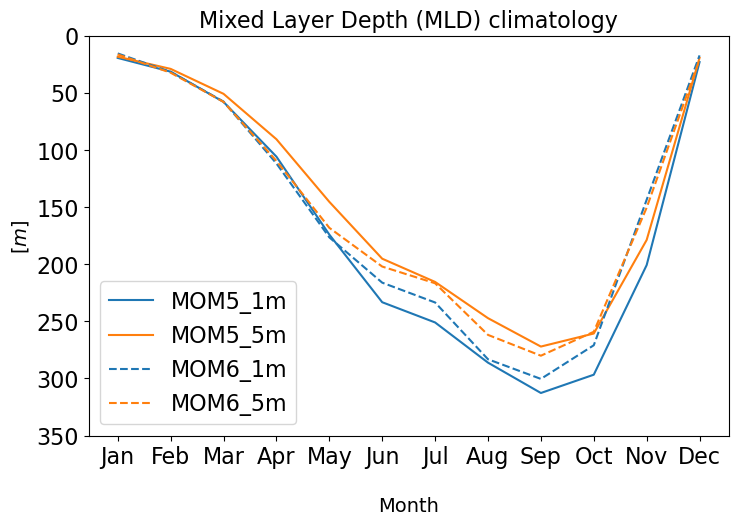

In [152]:
figure = plt.figure(num=1, figsize = (8, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)


plt.plot(np.arange(0,12), MLD_OM2_1m_shelf_mean,color='tab:blue',label='MOM5_1m')
plt.plot(np.arange(0,12), MLD_OM2_5m_shelf_mean,color='tab:orange',label='MOM5_5m')
plt.plot(np.arange(0,12), MLD_MOM6_1m_shelf_mean, color='tab:blue',linestyle='--',label='MOM6_1m')
plt.plot(np.arange(0,12), MLD_MOM6_5m_shelf_mean, color='tab:orange',linestyle='--',label='MOM6_5m')
plt.ylim(350,0); plt.title('Mixed Layer Depth (MLD) climatology', fontsize=16)
plt.legend(fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.xlabel('Month', fontsize=14, labelpad=20); 
plt.ylabel(r"[$m$]", fontsize=14)
plt.xticks(ticks=np.arange(0,12),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])



# plt.savefig(figpath+'V11_Figure_7.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'V11_Figure_7.pdf',dpi=300,bbox_inches='tight')

We can see above that in the 1m case, KPP is more efficient in removing salt from the surface than in 5m case. So the response of KPP to coarsening resolution on the shelf is to actually increase the surface salinity, and therefore cannot explain the DSW halting in 5mtop

_________________

# Figure 8

In [153]:
expt_FWF = 'ryf_FWFdist'
start_time_init = '1900-01'
end_time_init='1902-01'
time_slice_init=slice(start_time_init,end_time_init)

In [154]:
#Sea ice formation
FWFdist_wfi = cc.querying.getvar(expt_FWF, 'wfiform', temp_session,\
                                 start_time=start_time_init,end_time=end_time_init,frequency='1 monthly',chunks={'time':'200gb'}).sel(time=time_slice_init)*tarea
OM1mtop_wfi = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'wfiform', session,\
                                 start_time=start_time_init,end_time=end_time_init,frequency='1 monthly',chunks={'time':'200gb'}).sel(time=time_slice_init)*tarea
OM5mtop_wfi = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'wfiform', session, \
                                 start_time=start_time_init,end_time=end_time_init,frequency='1 monthly',chunks={'time':'200gb'}).sel(time=time_slice_init)*tarea

#sea ice melt
FWFdist_melt = cc.querying.getvar(expt_FWF, 'wfimelt', temp_session, \
                                  start_time=start_time_init,end_time=end_time_init,frequency='1 monthly',chunks={'time':'200gb'}).sel(time=time_slice_init)*tarea
OM1mtop_melt = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'wfimelt', session, \
                                  start_time=start_time_init,end_time=end_time_init,frequency='1 monthly',chunks={'time':'200gb'}).sel(time=time_slice_init)*tarea
OM5mtop_melt = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'wfimelt', session, \
                                  start_time=start_time_init,end_time=end_time_init,frequency='1 monthly',chunks={'time':'200gb'}).sel(time=time_slice_init)*tarea

2025-05-02 08:52:22,062 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-c6df6465-e50c-4884-9410-c02ba56dfc1e
Function:  execute_task
args:      ((<function apply at 0x148bc5536680>, <function open_dataset at 0x148ba437e830>, ['/scratch/v45/wf4500/simulations/RYF_1mtop_FWFdist/wf4500/access-om2/archive/ryf_FWFdist/output023/ocean/ocean_month.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['time', '200gb']])]])))
kwargs:    {}
Exception: "FileNotFoundError(2, 'No such file or directory')"

2025-05-02 08:52:22,062 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-552f7f09-2810-4dc2-b337-149455a4d85b
Function:  execute_task
args:      ((<function apply at 0x14f4deb2e680>, <function open_dataset at 0x14f4b00ac1f0>, ['/scratch/v45/wf4500/simulations/RYF_1mtop_FWFdist/wf4500/access-om2/archive/ryf_FWFdist/output020/ocean/ocean_month.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['time', '200gb']])]]

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch/v45/wf4500/simulations/RYF_1mtop_FWFdist/wf4500/access-om2/archive/ryf_FWFdist/output023/ocean/ocean_month.nc'

In [155]:
#extracting values along the shelf
FWFdist_wfi_shelf, shelf_mask = shelf_mask_isobath_MOM5(FWFdist_wfi)
OM1mtop_wfi_shelf, shelf_mask = shelf_mask_isobath_MOM5(OM1mtop_wfi)
OM5mtop_wfi_shelf, shelf_mask = shelf_mask_isobath_MOM5(OM5mtop_wfi)
FWFdist_melt_shelf, shelf_mask = shelf_mask_isobath_MOM5(FWFdist_melt)
OM1mtop_melt_shelf, shelf_mask = shelf_mask_isobath_MOM5(OM1mtop_melt)
OM5mtop_melt_shelf, shelf_mask = shelf_mask_isobath_MOM5(OM5mtop_melt)

#summing along the shelf
FWFdist_wfi_shelfT =  FWFdist_wfi_shelf.sum(('xt_ocean','yt_ocean'))
OM1mtop_wfi_shelfT =  OM1mtop_wfi_shelf.sum(('xt_ocean','yt_ocean'))
OM5mtop_wfi_shelfT =  OM5mtop_wfi_shelf.sum(('xt_ocean','yt_ocean'))
FWFdist_melt_shelfT =  FWFdist_melt_shelf.sum(('xt_ocean','yt_ocean'))
OM1mtop_melt_shelfT =  OM1mtop_melt_shelf.sum(('xt_ocean','yt_ocean'))
OM5mtop_melt_shelfT =  OM5mtop_melt_shelf.sum(('xt_ocean','yt_ocean'))


NameError: name 'FWFdist_wfi' is not defined

In [156]:
FWFdist_wfi_shelfT.load()
OM1mtop_wfi_shelfT.load()
OM5mtop_wfi_shelfT.load()
FWFdist_melt_shelfT.load()
OM1mtop_melt_shelfT.load()
OM5mtop_melt_shelfT.load()

NameError: name 'FWFdist_wfi_shelfT' is not defined

We will convert these freshwater fluxes from kg to SV for easier view

NameError: name 'OM1mtop_wfi_shelfT' is not defined

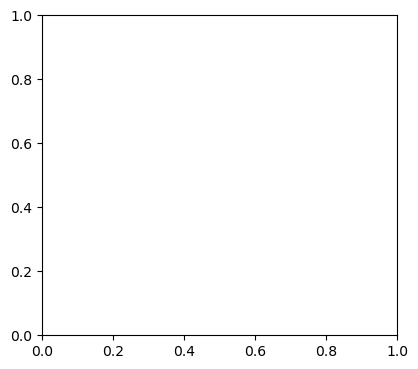

In [157]:
figure = plt.figure(num=1, figsize = (16, 4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
FWcolor='black'
year_init=slice(7,9)
σ_FW=1000 #kg m-3, density of freshwater

### plots of mean transport, along the 1 KM isobath, in the top 10 m of each simulation
MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')


plt.subplot(1,3,1)
plt.plot(np.arange(0,24),(((OM1mtop_wfi_shelfT + OM1mtop_melt_shelfT)/σ_FW)*1e-6),\
         color='tab:blue',label='1 m',linewidth= 2)
plt.plot(np.arange(0,24),(((OM5mtop_wfi_shelfT + OM5mtop_melt_shelfT)/σ_FW)*1e-6),\
          color='tab:orange', label='5 m',linewidth= 2)
plt.plot(np.arange(0,24),(((FWFdist_wfi_shelfT + FWFdist_melt_shelfT)/σ_FW)*1e-6),\
          color=FWcolor, label='FWFdist', linestyle = '--')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.grid(); plt.xticks(ticks = [0,12,24], labels=['0','1','2'])
plt.ylabel(r'$Sv$', fontsize = 14)
plt.xlabel('Simulation year', fontsize=14)
plt.title(r"[a] Freshwater flux from sea ice",fontsize=14)
plt.legend(fontsize=14); plt.xlim(0,24)

ax_132 = plt.subplot(1,3,2)
plt.plot(Overflowsum_OM1mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM1mtop.isopycnal_bins, color='tab:blue', label='MOM5_1m')
plt.plot(Overflowsum_OM5mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM5mtop.isopycnal_bins,color='tab:orange', label='MOM5_5m')
plt.plot(Overflowsum_FWFdist.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM5mtop.isopycnal_bins,color=FWcolor, label='MOM5_1m_FWFdist', linestyle = '--')
ax_132.add_patch(MOM5_σ0_poly)
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
plt.xlim(-1,7); #plt.legend(fontsize=12)
plt.ylim((28.2,27)); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Transport across 1km isobath (Sv)', fontsize=14)
plt.title(r"[b] Overflow: years 8 to 10",fontsize=14)

plt.subplot(1,3,3)
#overflow:
(Overflowsum_OM1mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_OM1mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:blue',label='1 m')
(Overflowsum_OM5mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_OM5mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:orange',label='5 m')
(Overflowsum_FWFdist.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_FWFdist.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color=FWcolor,label='FWFdist', linestyle = '--')
plt.xlim(1990.5,2000); plt.ylim(0,8)
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel(r'$SV$', fontsize=14); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.title("[c] DSW Overflow",fontsize=14)
plt.xlabel('Simulation year', fontsize=14)

# plt.savefig(figpath+'V10_Figure_8.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'V10_Figure_8.pdf',dpi=300,bbox_inches='tight')



In [158]:
(Overflowsum_OM1mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM1mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)[9].values,\
\
(Overflowsum_FWFdist.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_FWFdist.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)[9].values


(array(2.2383542), array(2.02491536))

## Fig S1

In [159]:
#OM2_21mbath (1mtop
gl =sorted(glob.glob(basedir + "/ryf_noSrestoring/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:60]
OM2Norest_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

Overflowsum_OM2norest=OM2Norest_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))

In [160]:
#OM2_21mbath (5mtop
gl =sorted(glob.glob("/g/data/ik11/users/wf4500/DSW_collaborative/Daily_mass_transports/ryf_5mtop_noSrestoring/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:60]
OM2Norest_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

Overflowsum_OM2norest_5m=OM2Norest_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))

Supplementary

Importing the SWMT and mass flux for the case without salt restoring


In [161]:

gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_noSrestoring/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
No_rest=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


#masking outside the shelf
swmtNorest_shelf, shelf_mask = shelf_mask_isobath_MOM5(No_rest.surface_water_mass_transformation)


#multiplying SWMT by area to get m3/s
swmtNorest_sum = ((swmtNorest_shelf  * area_t )/ 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmtNorest_sum['time'] = swmt21mbath_sum.time[:5]

5 netcdf data files


In [162]:
gl =sorted(glob.glob("/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/ryf_5mtop_noSrestoring/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
No_rest_5m=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


#masking outside the shelf
swmtNorest_shelf_5m, shelf_mask = shelf_mask_isobath_MOM5(No_rest_5m.surface_water_mass_transformation)


#multiplying SWMT by area to get m3/s
swmtNorest_sum_5m = ((swmtNorest_shelf_5m  * area_t )/ 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmtNorest_sum_5m['time'] = swmt21mbath_sum.time[:5]

5 netcdf data files


In [163]:
swmtNorest_sum_DSW = swmtNorest_sum.where(swmtNorest_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmtNorest_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)

In [164]:
swmtNorest_sum_DSW_5m = swmtNorest_sum_5m.where(swmtNorest_sum_5m.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmtNorest_sum_5m.isopycnal_bins<=σ0_DSW_1m_maxdens)

In [165]:
year_init=slice(0,5)

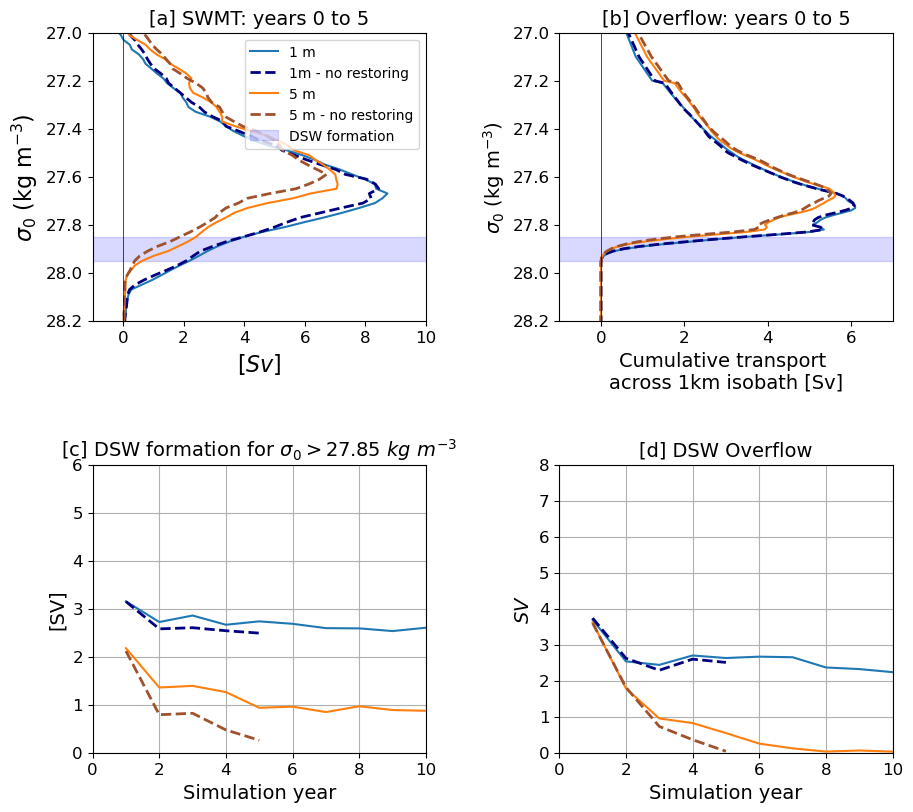

In [178]:
figure = plt.figure(num=1, figsize = (10,9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')


ax_221 = plt.subplot(2,2,1)
plt.plot(swmt21mbath_sum.isel(time=year_init).mean('time'), \
         isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(swmtNorest_sum.isel(time=year_init).mean('time'),\
         swmtNorest_sum.isopycnal_bins, color='navy',label='1m - no restoring',linestyle='--',linewidth=2)
plt.plot(swmt5mtop_sum.isel(time=year_init).mean('time'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')
plt.plot(swmtNorest_sum_5m.isel(time=year_init).mean('time'), isopycnal_bin_midmom5_5mtop[0,:],linestyle='--',linewidth=2, color='sienna',label='5 m - no restoring')
ax_221.add_patch(MOM5_σ0_poly)
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27)); plt.legend(fontsize=10)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=16)
plt.title(r"[a] SWMT: years 0 to 5",fontsize=14)


MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15)

ax_222 = plt.subplot(2,2,2)
plt.plot(Overflowsum_OM1mtop.isel(year=year_init).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM1mtop.isopycnal_bins, color='tab:blue')
plt.plot(Overflowsum_OM2norest.isel(year=year_init).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM2norest.isopycnal_bins, color='navy',linestyle='--',linewidth=2)
plt.plot(Overflowsum_OM5mtop.isel(year=year_init).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM5mtop.isopycnal_bins, color='tab:orange')
#Overflowsum_OM2norest_5m
plt.plot(Overflowsum_OM2norest_5m.isel(year=year_init).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM2norest_5m.isopycnal_bins, color='sienna',linestyle='--',linewidth=2)


ax_222.add_patch(MOM5_σ0_poly)
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
plt.xlim(-1,7); #plt.legend(fontsize=12)
plt.ylim((28.2,27)); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Cumulative transport \nacross 1km isobath [Sv]', fontsize=14)
plt.title(r"[b] Overflow: years 0 to 5",fontsize=14)




plt.subplot(2,2,3)
#SWMT:
(swmt21mbath_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:blue',label=r"1 m")
(swmtNorest_sum_DSW.mean('isopycnal_bins')\
).plot(color='navy',label=r"1m - no restoring",linestyle='--',linewidth=2)
(swmt5mtop_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:orange',label=r"5m")
(swmtNorest_sum_DSW_5m.mean('isopycnal_bins')\
).plot(color='sienna',label=r"5m - no restoring",linestyle='--',linewidth=2)

plt.xlim(1990.5,2000); plt.ylim(0,6)
#plt.legend(fontsize=10); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14)
plt.title("[c] DSW formation for " + r'$\sigma_0>$' + str(σ0_ref) + r' $kg \ m^{-3}$',fontsize=14)
plt.xlabel('Simulation year', fontsize=14)





plt.subplot(2,2,4)
#overflow:
(Overflowsum_OM1mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_OM1mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:blue',label='1 m')
(Overflowsum_OM2norest.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_OM2norest.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='navy',label='1m - no restoring',linestyle='--',linewidth=2)
(Overflowsum_OM5mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_OM5mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:orange',label='5 m')
(Overflowsum_OM2norest_5m.vol_trans_across_contour_binned.cumsum('isopycnal_bins').where(Overflowsum_OM2norest_5m.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='sienna',label='5m - no restoring',linestyle='--',linewidth=2)

plt.xlim(1990.5,2000); plt.ylim(0,8)
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel(r'$SV$', fontsize=14); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.title("[d] DSW Overflow",fontsize=14)
plt.xlabel('Simulation year', fontsize=14)
#plt.legend(fontsize=14); 

plt.savefig(figpath+'R0_Figure_S1.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'R0_Figure_S1.pdf',dpi=300,bbox_inches='tight')


Restoring then have a low impact, but still seem to limit the DSW formation sensitivity to surface cell thickness.

_________________

In [188]:
%%time
direct_session = cc.database.create_session('/home/156/wf4500/databases/access/DIRECT_DSW.db')
weakwinds_session = cc.database.create_session('/home/156/wf4500/databases/access/panan01_5m_weakwinds.db')

### 1m ###
u_MOM6_1m = cc.querying.getvar('panan01_1mtop_daily', 'uo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
v_MOM6_1m = cc.querying.getvar('panan01_1mtop_daily', 'vo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()



rho0_MOM6_1m_x = (cc.querying.getvar('panan01_1mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_1m.xq).drop('xh').load() 
rho0_MOM6_1m_y = (cc.querying.getvar('panan01_1mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_1m.yq).drop('yh').load() 


umo_MOM6_1m = (cc.querying.getvar('panan01_1mtop_daily', 'umo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_x).load() #m3/s

vmo_MOM6_1m = (cc.querying.getvar('panan01_1mtop_daily', 'vmo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m) / rho0_MOM6_1m_y).load() #m3/s


𝜏x_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'tauuo', session, n=1,frequency='1 monthly',chunks = {})\
.sel(yh=lat_slice).isel(time=0).load()
𝜏y_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'tauvo', session, n=1,frequency='1 monthly',chunks = {})\
.sel(yq=lat_slice).isel(time=0).load()



### 5m ###
u_MOM6_5m = cc.querying.getvar('panan01_5mtop_daily', 'uo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()
v_MOM6_5m = cc.querying.getvar('panan01_5mtop_daily', 'vo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).\
mean('time').sel(z_l_sub01=depth_slice_20m).rename({'z_l_sub01':'z_l'}).load()


rho_MOM6_5m_x = (cc.querying.getvar('panan01_5mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_5m.xq).drop('xh').load() #m3/s
rho_MOM6_5m_y = (cc.querying.getvar('panan01_5mtop_daily', 'rhopot0', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_5m.yq).drop('yh').load() #m3/s


umo_MOM6_5m = (cc.querying.getvar('panan01_5mtop_daily', 'umo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yh=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)/rho_MOM6_5m_x ).load() #m3/s

vmo_MOM6_5m = (cc.querying.getvar('panan01_5mtop_daily', 'vmo', direct_session, n=31,frequency='1 daily',chunks = {})\
.sel(yq=lat_slice).isel(time=slice(0,31)).mean('time').sel(z_l=depth_slice_20m)/rho_MOM6_5m_y ).load() #m3/s



𝜏x_MOM6_5m = cc.querying.getvar('mom6-panan', 'tauuo', temp_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yh=lat_slice).isel(time=0).load()
𝜏y_MOM6_5m = cc.querying.getvar('mom6-panan', 'tauvo', temp_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yq=lat_slice).isel(time=0).load()



### 5m weak winds###

rho_MOM6_5m_x_weakwinds  = (cc.querying.getvar('mom6-panan', 'rhopot0', weakwinds_session, frequency='1 monthly',chunks = {})\
.sel(yh=lat_slice).isel(time=0).sel(z_l=depth_slice_20m)).interp(xh=u_MOM6_5m.xq).drop('xh').load() #m3/s
rho_MOM6_5m_y_weakwinds  = (cc.querying.getvar('mom6-panan', 'rhopot0', weakwinds_session, frequency='1 monthly',chunks = {})\
.sel(yh=lat_slice).isel(time=0).sel(z_l=depth_slice_20m)).interp(yh=v_MOM6_5m.yq).drop('yh').load() #m3/s


umo_MOM6_5m_weakwinds  = (cc.querying.getvar('mom6-panan', 'umo', weakwinds_session,frequency='1 monthly',ncfile='%month_z%',chunks = {})\
.sel(yh=lat_slice).isel(time=0).sel(z_l=depth_slice_20m)/rho_MOM6_5m_x_weakwinds  ).load() #m3/s

vmo_MOM6_5m_weakwinds  = (cc.querying.getvar('mom6-panan', 'vmo', weakwinds_session,frequency='1 monthly',ncfile='%month_z%',chunks = {})\
.sel(yq=lat_slice).isel(time=0).sel(z_l=depth_slice_20m)/rho_MOM6_5m_y_weakwinds  ).load() #m3/s


2025-04-24 13:50:21,725 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-804f32ad-2978-478a-92be-73553fe5c222
Function:  execute_task
args:      ((<function apply at 0x14e3437ea680>, <function open_dataset at 0x14e314f1bb50>, ['/scratch/x77/wf4500/rundir/panan01_5m_weakwindsoutputs/wf4500/mom6/archive/mom6-panan/output002/19910301.ocean_month_z.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [])]])))
kwargs:    {}
Exception: "FileNotFoundError(2, 'No such file or directory')"

2025-04-24 13:50:21,725 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-32dc4572-4c06-416a-be56-9a65edf0c99c
Function:  execute_task
args:      ((<function apply at 0x14e2969a6680>, <function open_dataset at 0x14e27a86c820>, ['/scratch/x77/wf4500/rundir/panan01_5m_weakwindsoutputs/wf4500/mom6/archive/mom6-panan/output019/19980701.ocean_month_z.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [])]])))
kwargs:    {}
Exception:

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch/x77/wf4500/rundir/panan01_5m_weakwindsoutputs/wf4500/mom6/archive/mom6-panan/output019/19980701.ocean_month_z.nc'

In [187]:
#for MOM6_1m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_1m.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_1m.rename({'yq':'y','xh':'x'})*mask_y_transport)\
                    .stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_1m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')

del x_transport_1d_i, y_transport_1d_i

#for MOM6_5m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_5m.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_5m.rename({'yq':'y','xh':'x'})*mask_y_transport)\
.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_5m = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')


del x_transport_1d_i, y_transport_1d_i
#for MOM6_5m
# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = (umo_MOM6_5m_weakwinds.rename({'yh':'y','xq':'x'})*mask_x_transport)\
.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = (vmo_MOM6_5m_weakwinds.rename({'yq':'y','xh':'x'})*mask_y_transport)\
.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

MOM6_vol_trans_across_contour_5m_weakwinds = xr.concat((x_transport_1d_i, y_transport_1d_i), dim='contour_index').sum('contour_index')

NameError: name 'umo_MOM6_5m_weakwinds' is not defined

In [186]:
MOM6_Transport_1m_5mdepth = np.round((MOM6_vol_trans_across_contour_1m_into5*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_5m_5mdepth = np.round((MOM6_vol_trans_across_contour_5m*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_5m_5mdepth_weakwinds = np.round((MOM6_vol_trans_across_contour_5m_weakwinds*1e-6).\
                                isel(z_l=0).values,2)

MOM6_Transport_1m_5mdepth ,MOM6_Transport_5m_5mdepth 

NameError: name 'MOM6_vol_trans_across_contour_5m_weakwinds' is not defined

NameError: name 'MOM6_Transport_5m_5mdepth_weakwinds' is not defined

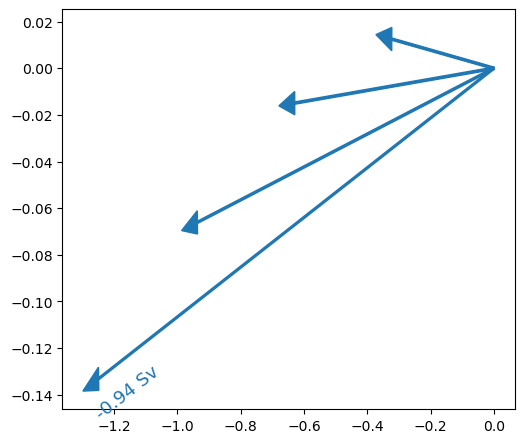

In [185]:
figure = plt.figure(num=1, figsize = (13,5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)

inityear=7
endyear=9
timeind_weakwinds=slice(inityear,endyear)

#5m polygons
MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.9,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)
MOM6_5m_poly = Polygon([(0,0), (-1.5,-.35),(-1.9,-.35), (-1.9,-.18)],color='black',edgecolor=None,alpha=0.07)

#3 cells polygons (3.6 m)
MOM5_3m_poly = Polygon([(0,0), (-1.9,-.23),(-1.9,-.15), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_3m_poly = Polygon([(0,0), (-1.9,-.16),(-1.9,-.1), (0,0)],color='black',edgecolor=None,alpha=0.07)

#2 cells polygons (2.3 m)
MOM5_2m_poly = Polygon([(0,0), (-1.9,-.13),(-1.9,-.03), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_2m_poly = Polygon([(0,0), (-1.9,-.08),(-1.9,0), (0,0)],color='black',edgecolor=None,alpha=0.07)

#1 cell polygons (1.1 m)
MOM5_1m_poly = Polygon([(0,0), (-1.9,-.02),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)
MOM6_1m_poly = Polygon([(0,0), (-1.9,0.01),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)






ax6 = plt.subplot(121)

### top cell
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,1)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')


### top 2 cells
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,2)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

### top 3 cells
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,3)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

### top 5m 
plt.arrow(0,0,MOM6_U_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          MOM6_V_transport_1m.isel(z_l=slice(0,4)).sum('z_l')/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:blue')

plt.text(-1.27,-.15,str(MOM6_Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
         rotation = 38,fontsize=13)

plt.text(-1.175,-.112,str(MOM6_Transport_5m_5mdepth_weakwinds) + ' Sv',color='olive',\
         rotation = 34,fontsize=13)

plt.arrow(0,0,MOM6_U_transport_5m.isel(z_l=0)/1e6,MOM6_V_transport_5m.isel(z_l=0)/1e6,\
          head_width=1e-2,head_length=5e-2,color='tab:orange')


plt.arrow(0,0,MOM6_U_transport_5m_weakwinds.isel(z_l=0)/1e6,MOM6_V_transport_5m_weakwinds.isel(z_l=0)/1e6,\
          head_width=1e-2,head_length=5e-2,color='olive')


plt.text(-1.20,-.17,str(MOM6_Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
         rotation = 40,fontsize=13)

ax6.add_patch(MOM6_5m_poly)
plt.text(-1.88, -0.19,r'z < 5.1 m ',rotation=32,color='dimgray',fontsize=12)

ax6.add_patch(MOM6_3m_poly)
plt.text(-1.88, -0.115,r'z < 3.6 m ',rotation=15,color='dimgray',fontsize=12)

ax6.add_patch(MOM6_2m_poly)
plt.text(-1.88, -0.02,r'z < 2.3 m ',  color='dimgray',fontsize=12)


ax6.add_patch(MOM6_1m_poly)
plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

plt.yticks(fontsize=13);
plt.xticks(ticks=[-1.8, -1.5, -1.15, -0.9, -0.6, -0.3, 0 ],fontsize=13);
plt.xlim(-1.9,.1)
plt.ylim(-.2,.05)
plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
plt.ylabel( r'Meridional transport  [$Sv$]', fontsize=16)


plt.title('[a] Surface transports for z > 5.1m \n',fontsize=14)











MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')





ax_422 = plt.subplot(1,2,2)
plt.plot(ShelfWMT_1dz.isel(time=timeind_weakwinds).mean('time')/1e6, ShelfWMT_1dz.isopycnal_bins, color='tab:blue',label='1 m')
plt.plot(ShelfWMT_5dz.isel(time=timeind_weakwinds).mean('time')/1e6, ShelfWMT_5dz.isopycnal_bins, color='tab:orange',label='5 m')
plt.plot(ShelfWMT_5dz_weakwinds.isel(time=timeind_weakwinds).mean('time')/1e6, ShelfWMT_5dz_weakwinds.isopycnal_bins, color='olive',\
         label=r'5 m, $\tau_{96 \%}$')
plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)
ax_422.add_patch(MOM6_σ2_poly)
#plt.plot([-1, 10], [σ2_ref,σ2_ref], 'b', linewidth=0.5,label=r'$\sigma_2 =$'+str(σ2_ref)); 
plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((37.55,36.8)); plt.legend(fontsize=10)
plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title(r"[b] SWMT: years " + str(inityear) + ' to ' + str(endyear) ,fontsize=14)



# plt.savefig(figpath+'V13_Figure_8.png',dpi=300,bbox_inches='tight')
# plt.savefig(figpath+'V13_Figure_8.pdf',dpi=300,bbox_inches='tight')
